In [1]:
#Importamos cada uno de los paquetes/librería que vayamos a usar en el código

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from google.colab.patches import cv2_imshow
!pip install -qq flow_vis
import flow_vis
from pathlib import Path
from tqdm import tqdm

# 1. Corrección de distorsiones en imágenes de llenado de campo

En este apartado vamos a generar una imagen ideal de llenado de campo a la que posteriormente vamos a aplicar distorsiones. Idealemente, una imagen de llenado de campo sin distorsiones consiste en una red de puntos distribuidos acorde la malla de cristales centelleadores que se está usando. En este caso, nuestra malla en un cuadrado de NxN cristales.

In [4]:
N = 10  # Número de puntos en cada dirección

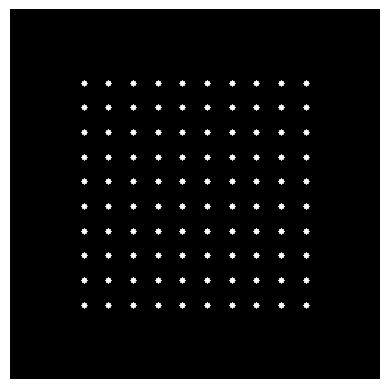

In [5]:
def create_uniform_points_image(size=(400, 400), grid_size=(14,14)): #Función para generar una imagen con círculos
    img = np.zeros(size, dtype=np.uint8) #Generamos una matriz de ceros
    h, w = size #Definimos nuestros límites en los ejes x e y
    y_coords = np.linspace(h * 0.2, h * 0.8, grid_size[0]) #Creamos un array con todos los valores posibles en y
    x_coords = np.linspace(w * 0.2, w * 0.8, grid_size[1]) #Creamos un array con todos los valores posibles en x
    for y in y_coords:
        for x in x_coords:
            cv2.circle(img, (int(x), int(y)), 3, 255, -1) #Recorremos el grid formado por nuestras coordenadas x e y, dibujando un círculo en cada una de las posiciones
    return img #Devolvemos la imagen

original_img = create_uniform_points_image(grid_size=(N,N)) #Creamos una imagen con con NxN círculos

original_img_32 =original_img.astype(np.float32) / 255.0 # Pasamos el formato de la imagen a float32 normalizado para que sea compatible con pytorch.

# Mostramos y guardamos las imágenes

out_dir = Path("data/originals")
out_dir.mkdir(parents=True, exist_ok=True)
plt.imshow(original_img, cmap='gray')
plt.axis('off')
plt.show()
cv2.imwrite("data/originals/uniform_points.png", original_img)
np.save(out_dir / f"uniform_points.npy", original_img_32)


Las imágenes se guardan en formato uint8 para su visualización, pero el estudio se va a realizar sobre imágenes en float32, las cuales son compatibles con Pytorch

## 1.1 Distorsiones aplicadas a la imagen original

A continuación vienen recogidas una lista de distorsiones que se pueden aplicar a la imagen de llenado de campo, aunque no se han utilizado todas para el trabajo. Cada uno de estos apartados recoge la función que introduce la distorsión, junto con la función aplicada a la imagen para ver el tipo de distorsión que introduce.

### 1.1.1 Distorsión en los ejes con aleatoriedad y ruido (se ha usado para el entrenamiento)

Esta distorsión deforma los puntos en los bordes y disminuye su intensidad. El efecto es mayor a medida que nos alejamos más del centro.

In [6]:

def apply_combined_edge_distortion_with_noise(
    img: np.ndarray, # Imagen a la que se le introduce una distorsíon
    falloff_strength: float = 0.6, # Atenuación de intensidad hacia los boredes
    displacement_strength: float = 10, # Fuerza del desplazamiento radial de cada píxel hacia fuera
    random_intensity_noise: float = 0.1, # Variación aleatoria de la intensidad
    random_displacement_noise: float = 0.1 # Variación aleatoria en el desplazamiento radial
) -> np.ndarray:

    h, w = img.shape
    cx, cy = w // 2, h // 2

    # Detectamos los centros de los puntos (círculos blancos)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centers = [tuple(map(int, np.mean(cnt.reshape(-1, 2), axis=0))) for cnt in contours]

    # Generamon un jitter de intensidad por cada punto
    rng = np.random.default_rng(seed=42)
    jitters = {center: np.clip(rng.normal(1.0, random_intensity_noise), 0.7, 1.3)
               for center in centers}

    mask = np.ones((h, w), dtype=np.float32)
    map_x = np.zeros_like(img, dtype=np.float32)
    map_y = np.zeros_like(img, dtype=np.float32)

    for y in range(h):
        for x in range(w):
            # Distancia normalizada al borde
            dist_to_edge = min(x, w - x, y, h - y)
            normalized_dist = dist_to_edge / (min(h, w) / 2)

            # Atenuación base
            attenuation_base = falloff_strength + (1 - falloff_strength) * normalized_dist

            # Aplicamos el jitter solo en los puntos detectados
            if (x, y) in jitters:
                attenuation = attenuation_base * jitters[(x, y)]
            else:
                attenuation = attenuation_base
            mask[y, x] = attenuation

            # Desplazamiento radial con ruido global
            dx = x - cx
            dy = y - cy
            base_factor = 1 - (1 - normalized_dist) * (displacement_strength / (min(h, w) / 2))
            noise_factor = np.clip(rng.normal(1.0, random_displacement_noise), 0.8, 1.2)
            factor = base_factor * noise_factor
            map_x[y, x] = cx + dx * factor
            map_y[y, x] = cy + dy * factor

    # Remapeo e intensidad
    remapped = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    corrupted = (remapped.astype(np.float32) * mask)

    # Convertimos a uint8 para salida
    return np.clip(corrupted, 0, 255).astype(np.uint8)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
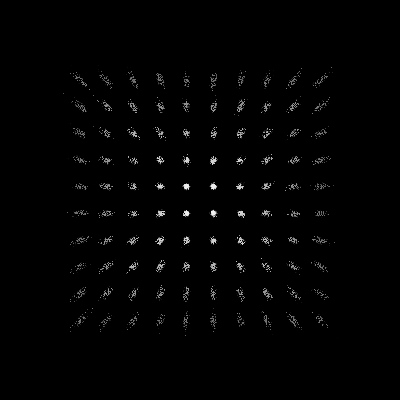

In [7]:
apply_combined_edge_distortion_with_noise(original_img,
                                          falloff_strength=0.1,
                                          displacement_strength=0,
                                          random_intensity_noise=0,
                                          random_displacement_noise=0.03)

### 1.1.2 Difusión gaussiana no uniforme (no se ha usado para el entrenamiento)

Este código aplica un desenfoque gaussiano no uniforme sobre la imagen.

In [8]:
def apply_nonuniform_blur(img, max_sigma=2.5):
    rng = np.random.default_rng(seed=42)
    h, w = img.shape
    blurred = np.zeros_like(img, dtype=np.float32)
    for y in range(0, h, 50):
        for x in range(0, w, 50):
            sigma = rng.uniform(0.5, max_sigma)
            roi = img[y:y+50, x:x+50]
            blur_roi = cv2.GaussianBlur(roi, (5, 5), sigmaX=sigma)
            blurred[y:y+50, x:x+50] = blur_roi
    return blurred.astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
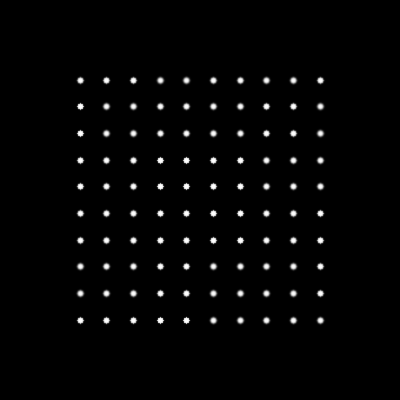

In [9]:
apply_nonuniform_blur(original_img, max_sigma=1)

### 1.1.3 Ruido tipo sal pimienta (no se ha usado en el entrenamiento)

Este código añade píxeles blancos de manera aleatoria en la imagen.

In [10]:
def apply_salt_and_pepper(img, amount=0.005, grid_fraction=(0.2, 0.8)):
    rng = np.random.default_rng(seed=42)
    noisy = img.copy()
    h, w = img.shape

    # Definir límites de la malla
    y_min, y_max = int(h * grid_fraction[0]), int(h * grid_fraction[1])
    x_min, x_max = int(w * grid_fraction[0]), int(w * grid_fraction[1])

    # Número total de píxeles a modificar
    num_pixels = int(amount * img.size)

    # Generar coordenadas dentro del área de la malla
    y_coords = rng.integers(y_min, y_max, num_pixels)
    x_coords = rng.integers(x_min, x_max, num_pixels)

    # Intensidades aleatorias entre 1 y 255
    intensities = rng.integers(1, 256, num_pixels)

    # Asignar los valores a la imagen
    noisy[y_coords, x_coords] = intensities

    return noisy



array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
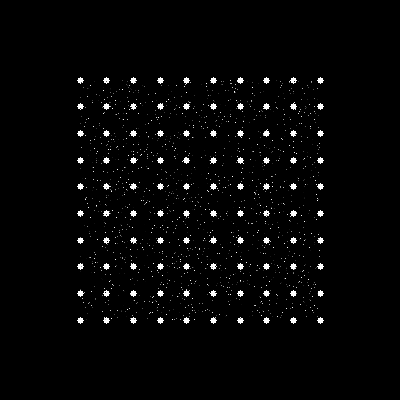

In [11]:
apply_salt_and_pepper(original_img, amount=0.01)

### 1.1.4 Distorsión de compresión en bordes (se ha usado en el entrenamiento)

Este código desplaza los centroides ubicados en el borde de la malla, alejandolos o acercándolos pero manteniendo la alineación de los puntos.

In [12]:
def apply_axis_aligned_border_compression(img,
                                          base_strength=0.2, # Fuerza de desplazamiento: negativo aleja, positivo acerca
                                          border_layers=2 # Número de filas/columnas del borde que sufren las distorsión
                                          ):
    h, w = img.shape
    cx, cy = w // 2, h // 2
    output = np.zeros_like(img)

    # Detectamos los centroides
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centers = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        x = int(M["m10"] / M["m00"])
        y = int(M["m01"] / M["m00"])
        centers.append((x, y))

    centers = np.array(centers)

    # Detectamos las columnas y las filas únicas (grupos)
    unique_x = np.sort(np.unique(centers[:, 0]))
    unique_y = np.sort(np.unique(centers[:, 1]))

    x_tol = 4
    y_tol = 4

    # Creamos mapas de índice
    # Capa para bordes horizontales

    x_index_to_layer = {}
    for layer in range(border_layers):
        left_val = unique_x[layer]
        right_val = unique_x[-(layer + 1)]
        for i, (x, _) in enumerate(centers):
            if abs(x - left_val) < x_tol or abs(x - right_val) < x_tol:
                x_index_to_layer[i] = layer

    # Capa para bordes verticales

    y_index_to_layer = {}
    for layer in range(border_layers):
        top_val = unique_y[layer]
        bottom_val = unique_y[-(layer + 1)]
        for i, (_, y) in enumerate(centers):
            if abs(y - top_val) < y_tol or abs(y - bottom_val) < y_tol:
                y_index_to_layer[i] = layer

    for i, (x, y) in enumerate(centers):
        new_x, new_y = x, y

        # Comprimimos horizontalmente
        if i in x_index_to_layer:
            layer = x_index_to_layer[i]
            strength = base_strength * (1 - layer / border_layers)
            new_x = int(cx + (x - cx) * (1 - strength))

        # Comprimimos verticalmente
        if i in y_index_to_layer:
            layer = y_index_to_layer[i]
            strength = base_strength * (1 - layer / border_layers)
            new_y = int(cy + (y - cy) * (1 - strength))

        cv2.circle(output, (new_x, new_y), 3, 255, -1)

    return output








array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
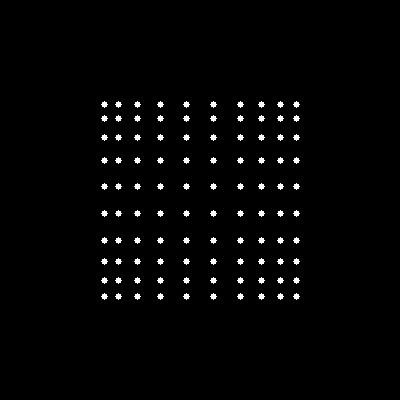

In [13]:
apply_axis_aligned_border_compression(original_img, base_strength=0.20, border_layers=3)

### 1.1.5 Gradiente de intensidad artificial (no se ha usado en el entrenamiento)

Este código introduce un gradiente de intensidad en la imagen, variando la intensidad de los puntos según el tipo de gradiente especificado:

In [14]:
def apply_intensity_gradient(img,
                             direction='radial', # Tipo de gradiente de intensidad
                             strength=0.4 # Fuerza de atenuación de la intensidad
                             ):
    h, w = img.shape
    y, x = np.indices((h, w))
    cx, cy = w // 2, h // 2
    if direction == 'radial':
        dist = np.sqrt((x - cx)**2 + (y - cy)**2)
        max_dist = np.sqrt(cx**2 + cy**2)
        mask = 1 - strength * (dist / max_dist)
    elif direction == 'left-right':
        mask = 1 - strength * (x / w)
    elif direction == 'top-bottom':
        mask = 1 - strength * (y / h)
    else:
        mask = np.ones_like(img, dtype=np.float32)
    mask = np.clip(mask, 0.3, 1.0)
    return (img.astype(np.float32) * mask).astype(np.uint8)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
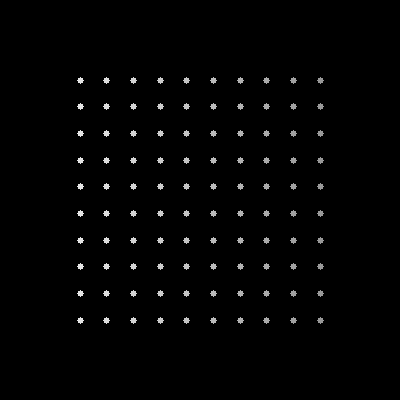

In [15]:
apply_intensity_gradient(original_img, direction='left-right', strength=0.5)

### 1.1.6 Distorsión de rejilla (Crystal misalignment) (se ha usado en el entrenamiento)

Este código introduce un desplazamiento aleatorio de los puntos de la imagen de llenado de campo (por bloques, por filas o por columnas).

In [16]:
def apply_structured_crystal_misalignment(img,
                                          max_displacement=5, # Desplazamiento máximo que puede producirse
                                          pattern='row' # Patrón de desplazamiento (bloques, filas, columnas)
                                          ):

    h, w = img.shape
    output = np.zeros_like(img)
    rng = np.random.default_rng(seed=42)

    # Detectamos puntos (centroides)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centers = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        x = int(M["m10"] / M["m00"])
        y = int(M["m01"] / M["m00"])
        centers.append((x, y))

    centers = np.array(centers)

    # Agrupamos por patrón
    if pattern == 'row':
        unique_rows = np.unique(centers[:, 1])
        for row_y in unique_rows:
            dy = int(rng.uniform(-max_displacement, max_displacement))
            dx = int(rng.uniform(-max_displacement, max_displacement))
            for x, y in centers:
                if abs(y - row_y) < 4:
                    new_x = np.clip(x + dx, 0, w - 1)
                    new_y = np.clip(y + dy, 0, h - 1)
                    cv2.circle(output, (new_x, new_y), 3, 255, -1)

    elif pattern == 'column':
        unique_cols = np.unique(centers[:, 0])
        for col_x in unique_cols:
            dy = int(rng.uniform(-max_displacement, max_displacement))
            dx = int(rng.uniform(-max_displacement, max_displacement))
            for x, y in centers:
                if abs(x - col_x) < 4:
                    new_x = np.clip(x + dx, 0, w - 1)
                    new_y = np.clip(y + dy, 0, h - 1)
                    cv2.circle(output, (new_x, new_y), 3, 255, -1)

    elif pattern == 'block':
        # Crear bloques 4x4 o 5x5 aproximadamente
        centers_sorted = centers[np.lexsort((centers[:, 0], centers[:, 1]))]
        grid = centers_sorted.reshape(-1, 4, 2)
        for block in grid:
            dx = int(rng.uniform(-max_displacement, max_displacement))
            dy = int(rng.uniform(-max_displacement, max_displacement))
            for x, y in block:
                new_x = np.clip(x + dx, 0, w - 1)
                new_y = np.clip(y + dy, 0, h - 1)
                cv2.circle(output, (new_x, new_y), 3, 255, -1)

    else:
        raise ValueError("pattern debe ser 'row', 'column' o 'block'")

    return output



array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
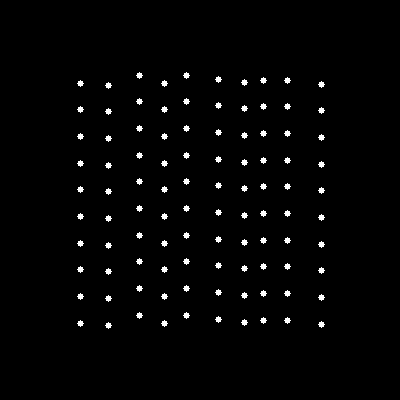

In [17]:
apply_structured_crystal_misalignment(original_img, max_displacement=7, pattern='column')

### 1.1.7 Distorsión óptica radial (no se ha usado en el entrenamiento)

Como bien indica, este código introduce una distorsión radial en los píxeles de una imagen, deformando los puntos según se alejan del centro.

In [18]:
def apply_radial_distortion(img, k=-0.0001):  # k<0 barril, k>0 cojín
    h, w = img.shape
    cx, cy = w // 2, h // 2
    distorted = np.zeros_like(img)

    for y in range(h):
        for x in range(w):
            if img[y, x] > 0:
                dx = x - cx
                dy = y - cy
                r2 = dx*dx + dy*dy
                scale = 1 + k * r2
                new_x = int(cx + dx * scale)
                new_y = int(cy + dy * scale)
                if 0 <= new_x < w and 0 <= new_y < h:
                    distorted[new_y, new_x] = img[y, x]

    return distorted


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
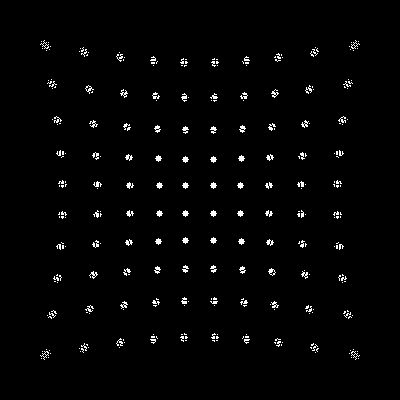

In [19]:
apply_radial_distortion(original_img, k=0.00001)

### 1.1.8 Distorsión personalizada (no se ha usado en el entrenamiento)

In [20]:
def apply_custom_distortion(img, dist, display, k_max=30):
    h, w = img.shape[:2]
    center_x, center_y = w / 2, h / 2
    max_radius = np.sqrt(center_x**2 + center_y**2)

    # Creamos un grid de coordenadas
    x = np.arange(w)
    y = np.arange(h)
    x_grid, y_grid = np.meshgrid(x, y)

    x_norm = x_grid - center_x
    y_norm = y_grid - center_y
    r = np.sqrt(x_norm**2 + y_norm**2)
    theta = np.arctan2(y_norm, x_norm)

    # Radio normalizado
    r_norm = r / max_radius

    # Tipo de distorsión

    if dist == 'seno':
        k_r = k_max * np.sin(np.pi * r_norm)
    elif dist == 'coseno':
        k_r = k_max * np.cos(np.pi * r_norm)
    elif dist == 'exponente':
        k_r = k_max * np.exp(-r_norm)

    r_distorted = r + k_r
    x_distorted = center_x + r_distorted * np.cos(theta)
    y_distorted = center_y + r_distorted * np.sin(theta)

    # Convertimos los mapas a float32
    map_x = x_distorted.astype(np.float32)
    map_y = y_distorted.astype(np.float32)

    # Remapeamos la imagen
    distorted_img = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    # Crear figura normalmente
    comparación = plt.figure(figsize=(15, 5))

    # Añadir subplots
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Distorted Image')
    plt.imshow(distorted_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Overlapped')
    superpuesta = 0.5 *img + 0.5 * distorted_img
    plt.imshow(superpuesta, cmap='hot')
    plt.axis('off')

    if display == 'Oculto':
      plt.close()

    # NO ponemos plt.show()

    return distorted_img, comparación

### 1.1.9 Combinación de distorsiones

Por último, este código combina las distorsiones utilizadas en este trabajo para el entreno de la red neuronal, excepto la del gradiente, que la incluye pero no se ha llegado a aplicar en ningún caso. Para ello, la función recoge todas las variables de cada una de las distorsiones, junto con una variable que indida si la distorsión se aplica o no, para poder hacer combinaciones a nuestro antojo. En caso de querer introducir alguna distorsión más, el procedimiento sería el mismo.

In [21]:
def apply_combined_distortions(
    img,
    apply_edge_distortion=True,
    falloff_strength=0.6,
    displacement_strength=10,
    random_intensity_noise=0.1,
    random_displacement_noise=0.1,
    apply_border_compression=True,
    base_strength=0.2,
    border_layers=2,
    apply_misalignment=True,
    max_displacement=5,
    pattern='row',
    apply_gradient=True,
    direction='radial',
    strength=0.4

):
    result = img.copy()

    if apply_misalignment: # Aplica distorsión de rejilla
        result = apply_structured_crystal_misalignment(result, max_displacement=max_displacement, pattern=pattern)
    if apply_border_compression: # Aplica distorsión de compresión/alejamiento de los bordes
        result = apply_axis_aligned_border_compression(result, base_strength=base_strength, border_layers=border_layers)
    if apply_edge_distortion: # Aplica distorsión de ruido y atenuación en los bordes
        result = apply_combined_edge_distortion_with_noise(result, falloff_strength=falloff_strength, displacement_strength=displacement_strength, random_intensity_noise=random_intensity_noise, random_displacement_noise=random_displacement_noise)
    if apply_gradient: # Aplica distorsión de gradiente de intensidad.
        result = apply_intensity_gradient(result, direction=direction, strength=strength)
    return result

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
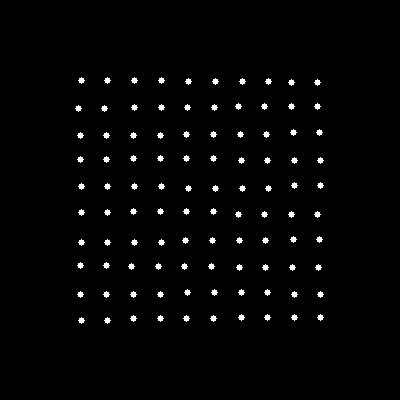

In [22]:
apply_combined_distortions(original_img,
                  apply_edge_distortion=False, falloff_strength=0.05, displacement_strength=1,random_intensity_noise=0.1, random_displacement_noise=0.01,
                  apply_border_compression=True, base_strength=0.01,
                  apply_misalignment=True, max_displacement=3, pattern='block',
                  apply_gradient=False, direction='left-rigth', strength = 0.4,
                           )

# 2. Corrección de distorsión en imágenes satelitales (VIIRS)

## 2.1 Imagen original del VIIRS

Vamos introducir una imagen sin distorsión y luego le aplicamos las distorsiones. La imagen la hemos descargado de NASA Worldview, y el código siguiente la introduce en el cuaderno.

Downloading...
From: https://drive.google.com/uc?id=1MJtjRNjosWoDzUvfLHw3Ris4IdhFNBOr
To: /content/Imagen_Referencia.png
100% 7.99M/7.99M [00:00<00:00, 83.0MB/s]


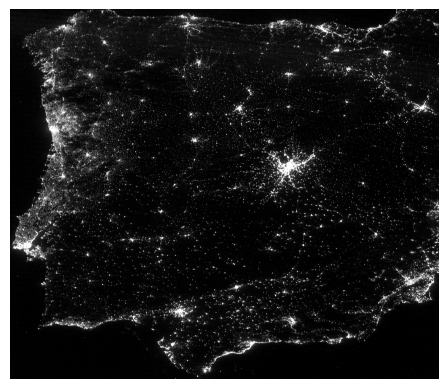

VIIRS shape=  (7062, 8186)  type = uint8


In [23]:
# ID del archivo
file_id = "1MJtjRNjosWoDzUvfLHw3Ris4IdhFNBOr"

# Descargar usando gdown
!gdown https://drive.google.com/uc?id={file_id}

VIIRS = cv2.imread('Imagen_Referencia.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(VIIRS, cmap='gray')
plt.axis('off')
plt.show()

print("VIIRS shape= ",np.shape(VIIRS)," type =",VIIRS.dtype)

En vez de utilizar varias imágenes, el siguiente código divide la imagen en distintas regiones, las cuales usaremos como imagenes originales a las que introducirles las distorsiones.

In [24]:
def split_image_into_regions(img: np.ndarray,
                             n_regions: int = 10 # Número de regiones
                             ):
    h, w = img.shape
    n_rows = 2
    n_cols = 5
    assert n_rows * n_cols == n_regions

    region_height = h // n_rows
    region_width = w // n_cols

    regions = []
    for i in range(n_rows):
        for j in range(n_cols):
            y1, y2 = i * region_height, (i + 1) * region_height
            x1, x2 = j * region_width, (j + 1) * region_width
            regions.append(img[y1:y2, x1:x2])
    return regions

## 2.2 Distorsiones a las imágenes satelitales

El código siguiente introduce una distorsión geométrica suave y aleatoria, la cual simula turbulencias atmosféricas u ópticas imperfectas

In [25]:
def generate_smooth_random_distorsion(img: np.ndarray, max_shift: float = 4.0, blur_ksize: int = 201, seed: int = None) -> tuple:
    if seed is not None:
        np.random.seed(seed)

    h, w = img.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))

    dx = cv2.GaussianBlur(np.random.randn(h, w).astype(np.float32), (blur_ksize, blur_ksize), 0)
    dy = cv2.GaussianBlur(np.random.randn(h, w).astype(np.float32), (blur_ksize, blur_ksize), 0)

    dx = max_shift * dx / np.max(np.abs(dx))
    dy = max_shift * dy / np.max(np.abs(dy))

    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)

    distorted_img = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    return distorted_img, dx, dy

# 3. Generación de las imágenes con distorsión

Una vez definidas todas las distorsiones, a continuación se generan todos los conjuntos de imágenes que se han utilizado para entrenar, validas y probar las redes neuronales

## 3.1 Llenado de campo

Para las imágenes de llenado de campo, el siguiente código genera distorsiones aleatorias a partir de las definidas anteriormente, usando la combinación de estas, y las guarda en una carpeta.

In [26]:
def generate_random_distortions(
    img: np.ndarray,
    n_samples: int,
    out_dir: Path,
    basename: str,
    seed: int = None,
    apply_misalignment: bool = True,
    apply_border_compression: bool = False,
    apply_edge_distortion: bool = False,
    apply_gradient: bool = False
):
    if seed is not None:
        np.random.seed(seed)

    # Crear carpetas separadas
    png_dir = out_dir / "png"
    npy_dir = out_dir / "npy"
    png_dir.mkdir(parents=True, exist_ok=True)
    npy_dir.mkdir(parents=True, exist_ok=True)

    if img.dtype in (np.float32, np.float64): # Nos aseguramos que las imágenes están en el formato correcto para aplicar las distorsiones
        base_uint8 = (np.clip(img, 0, 1) * 255).round().astype(np.uint8)
    else:
        base_uint8 = img.copy()

    for i in tqdm(range(n_samples), desc=f"{basename}"):
        # Verifica que al menos una distorsión está activada
        if not any([apply_misalignment, apply_border_compression, apply_edge_distortion, apply_gradient]): # NOs aseguramos que por lo menos se aplica una distorsión siempre
            raise ValueError("Debe activarse al menos una distorsión.")

        # Definimos todos los parámetros que regulan nuestras distorsiones, con unos valores límite que indica en rango en el que estos parámetros pueden variar de forma aleatoria

        params = {
            'max_displacement':         np.random.uniform(6, 10),
            'pattern':                  np.random.choice(['row', 'column', 'block']),
            'base_strength':            np.random.uniform(-0.15, 0.15),
            'border_layers':            np.random.randint(1, 3),
            'falloff_strength':         np.random.uniform(0.3, 0.8),
            'displacement_strength':    np.random.uniform(5, 25),
            'random_intensity_noise':   np.random.uniform(0.0, 0.2),
            'random_displacement_noise':np.random.uniform(0.0, 0.03),
            'direction':                np.random.choice(['radial', 'left-right', 'top-bottom']),
            'strength':                 np.random.uniform(0.1, 0.5)
        }



        # Generamos la imagen distorsionada

        out = apply_combined_distortions(
            base_uint8.copy(),
            apply_misalignment=apply_misalignment,
            max_displacement=params['max_displacement'],
            pattern=params['pattern'],
            apply_border_compression=apply_border_compression,
            base_strength=params['base_strength'],
            border_layers=params['border_layers'],
            apply_edge_distortion=apply_edge_distortion,
            falloff_strength=params['falloff_strength'],
            displacement_strength=params['displacement_strength'],
            random_intensity_noise=params['random_intensity_noise'],
            random_displacement_noise=params['random_displacement_noise'],
            apply_gradient=apply_gradient,
            direction=params['direction'],
            strength=params['strength']
        )

        # Convertimos la imagen en float32 (.npy)
        if out.dtype != np.float32:
            out_float = out.astype(np.float32) / 255.0
        else:
            out_float = np.clip(out, 0, 1)

        # Guardar .png para inspección
        out_uint8 = (np.clip(out_float, 0, 1) * 255).round().astype(np.uint8)
        cv2.imwrite(str(png_dir / f"distorted_image_{i:03d}.png"), out_uint8)

        # Guardar .npy para entrenamiento
        np.save(npy_dir / f"distorted_image_{i:03d}.npy", out_float)





### 3.1.1 Cristal missalignment

Generamos las imágenes de entrenamiento y validación con la distorsión de rejilla. No es necesario ejecutar este código, ya que estos conjuntos se han usado solo para entrenar las redes neuronales, cosa que ya se ha realizado. En caso de querer seguir entrenando, si que es necesario ejecutarlas. El parámetro seed debe ser distinto para generar conjuntos distintos de imágenes, porque si no, el conjunto de entrenamiento y el de validación tendrían las mismas imágenes

In [27]:
from pathlib import Path
import cv2

# Definimos las carpetas donde se van a guardar los conjuntos de imágenes

if __name__ == "__main__":
    src_dir   = Path("data/originals")
    train_dir = Path("data/Cristal_Miss/distorted_train")
    val_dir   = Path("data/Cristal_Miss/distorted_val")


    train_dir.mkdir(parents=True, exist_ok=True)
    val_dir.mkdir(parents=True, exist_ok=True)

    # Elegimos el número de imágenes que queremos utilizar, de las cuales el 75% se usarán para entrenar y el resto para validar

    samples_per_img = 200
    val_fraction    = 0.25

    for img_path in src_dir.glob("*.png"):

        img = (cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
               .astype(np.float32) / 255.0)

        n_train = int(samples_per_img * (1 - val_fraction))
        n_val   = samples_per_img - n_train

        # Generamos los conjuntos, asegurándonos de solo introducir la distorsión deseada

        generate_random_distortions(
            img,
            n_samples=n_train,
            out_dir=train_dir,
            basename=img_path.stem,
            seed=42,
            apply_misalignment=True,
            apply_border_compression=False,
            apply_edge_distortion=False,
            apply_gradient=False
        )

        generate_random_distortions(
            img,
            n_samples=n_val,
            out_dir=val_dir,
            basename=img_path.stem,
            seed=42,
            apply_misalignment=True,
            apply_border_compression=False,
            apply_edge_distortion=False,
            apply_gradient=False
        )



uniform_points: 100%|██████████| 50/50 [00:00<00:00, 133.39it/s]


El siguiente código es análogo al anterior, y sirve para crear el conjunto de prueba, que es el que vamos a usar para comparar con los algorimos tradicionales

In [28]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm


if __name__ == "__main__":
    # Directorio de entrada con imágenes originales
    src_dir = Path("data/originals")

    # Directorio de salida solicitado
    out_dir = Path("data/Cristal_Miss") / "Pruebas"

    # Crear carpeta de salida
    out_dir.mkdir(parents=True, exist_ok=True)

    # Número de imágenes

    samples_per_img = 30

    for img_path in src_dir.glob("*.png"):

        img = (cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
               .astype(np.float32) / 255.0)


        generate_random_distortions(
            img=img,
            n_samples=samples_per_img,
            out_dir=out_dir,
            basename=img_path.stem,
            seed=100,
            apply_misalignment=True,
            apply_border_compression=False,
            apply_edge_distortion=False,
            apply_gradient=False
        )


uniform_points: 100%|██████████| 30/30 [00:00<00:00, 146.71it/s]


### 3.1.2 Border compression

Generamos las imágenes de entrenamiento y validación con la distorsión de compresión/alejamiento de los bordes . No es necesario ejecutar este código, ya que estos conjuntos se han usado solo para entrenar las redes neuronales, cosa que ya se ha realizado. En caso de querer seguir entrenando, si que es necesario ejecutarlas. El parámetro seed debe ser distinto para generar conjuntos distintos de imágenes, porque si no, el conjunto de entrenamiento y el de validación tendrían las mismas imágenes

In [29]:
from pathlib import Path
import cv2

if __name__ == "__main__":
    src_dir   = Path("data/originals")
    train_dir = Path("data/Compression/distorted_train")
    val_dir   = Path("data/Compression/distorted_val")


    train_dir.mkdir(parents=True, exist_ok=True)
    val_dir.mkdir(parents=True, exist_ok=True)

    samples_per_img = 200
    val_fraction    = 0.25

    for img_path in src_dir.glob("*.png"):

        img = (cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
               .astype(np.float32) / 255.0)

        n_train = int(samples_per_img * (1 - val_fraction))
        n_val   = samples_per_img - n_train

        generate_random_distortions(
            img,
            n_samples=n_train,
            out_dir=train_dir,
            basename=img_path.stem,
            seed=42,
            apply_misalignment=False,
            apply_border_compression=True,
            apply_edge_distortion=False,
            apply_gradient=False
        )

        generate_random_distortions(
            img,
            n_samples=n_val,
            out_dir=val_dir,
            basename=img_path.stem,
            seed=42,
            apply_misalignment=False,
            apply_border_compression=True,
            apply_edge_distortion=False,
            apply_gradient=False
        )



uniform_points: 100%|██████████| 50/50 [00:00<00:00, 189.70it/s]


El siguiente código es análogo al anterior, y sirve para crear el conjunto de prueba, que es el que vamos a usar para comparar con los algorimos tradicionales

In [30]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Asegúrate de tener esta función definida en tu entorno:
# from your_module import generate_random_distortions

if __name__ == "__main__":
    # Directorio de entrada con imágenes originales
    src_dir = Path("data/originals")

    # Directorio de salida solicitado
    out_dir = Path("data/Compression") / "Prueba"

    # Crear carpeta de salida
    out_dir.mkdir(parents=True, exist_ok=True)

    # Parámetros de generación
    samples_per_img = 30  # Puedes ajustarlo a lo que necesites

    for img_path in src_dir.glob("*.png"):
        # Leer imagen en escala de grises y normalizar
        img = (cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
               .astype(np.float32) / 255.0)

        # Generar distorsiones con solo "misalignment" activado
        generate_random_distortions(
            img=img,
            n_samples=samples_per_img,
            out_dir=out_dir,
            basename=img_path.stem,
            seed=123,  # Usa otro valor si quieres más variación
            apply_misalignment=False,
            apply_border_compression=True,
            apply_edge_distortion=False,
            apply_gradient=False
        )


uniform_points: 100%|██████████| 30/30 [00:00<00:00, 168.55it/s]


### 3.1.3 Pérdida de brillo y ruido en los bordes

Generamos las imágenes de entrenamiento y validación con la distorsión de ruido y atenuación de los bordes. No es necesario ejecutar este código, ya que estos conjuntos se han usado solo para entrenar las redes neuronales, cosa que ya se ha realizado. En caso de querer seguir entrenando, si que es necesario ejecutarla. El parámetro seed debe ser distinto para generar conjuntos distintos de imágenes, porque si no, el conjunto de entrenamiento y el de validación tendrían las mismas imágenes

In [31]:
from pathlib import Path
import cv2

if __name__ == "__main__":
    src_dir   = Path("data/originals")
    train_dir = Path("data/Border_Noise/distorted_train")
    val_dir   = Path("data/Border_Noise/distorted_val")


    train_dir.mkdir(parents=True, exist_ok=True)
    val_dir.mkdir(parents=True, exist_ok=True)

    samples_per_img = 200
    val_fraction    = 0.25

    for img_path in src_dir.glob("*.png"):

        img = (cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
               .astype(np.float32) / 255.0)

        n_train = int(samples_per_img * (1 - val_fraction))
        n_val   = samples_per_img - n_train

        generate_random_distortions(
            img,
            n_samples=n_train,
            out_dir=train_dir,
            basename=img_path.stem,
            seed=42,
            apply_misalignment=False,
            apply_border_compression=False,
            apply_edge_distortion=True,
            apply_gradient=False
        )

        generate_random_distortions(
            img,
            n_samples=n_val,
            out_dir=val_dir,
            basename=img_path.stem,
            seed=42,
            apply_misalignment=False,
            apply_border_compression=False,
            apply_edge_distortion=True,
            apply_gradient=False
        )



uniform_points: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


El siguiente código es análogo al anterior, y sirve para crear el conjunto de prueba, que es el que vamos a usar para comparar con los algorimos tradicionales

In [32]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Asegúrate de tener esta función definida en tu entorno:
# from your_module import generate_random_distortions

if __name__ == "__main__":
    # Directorio de entrada con imágenes originales
    src_dir = Path("data/originals")

    # Directorio de salida solicitado
    out_dir = Path("data/Border_Noise") / "Prueba"

    # Crear carpeta de salida
    out_dir.mkdir(parents=True, exist_ok=True)

    # Parámetros de generación
    samples_per_img = 30  # Puedes ajustarlo a lo que necesites

    for img_path in src_dir.glob("*.png"):
        # Leer imagen en escala de grises y normalizar
        img = (cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
               .astype(np.float32) / 255.0)

        # Generar distorsiones con solo "misalignment" activado
        generate_random_distortions(
            img=img,
            n_samples=samples_per_img,
            out_dir=out_dir,
            basename=img_path.stem,
            seed=123,  # Usa otro valor si quieres más variación
            apply_misalignment=False,
            apply_border_compression=False,
            apply_edge_distortion=True,
            apply_gradient=False
        )

uniform_points: 100%|██████████| 30/30 [00:40<00:00,  1.36s/it]


### 3.1.4 Combinación de distorsiones

Generamos las imágenes de entrenamiento y validación con la combinación de distorsiones. No es necesario ejecutar este código, ya que estos conjuntos se han usado solo para entrenar las redes neuronales, cosa que ya se ha realizado. En caso de querer seguir entrenando, si que es necesario ejecutarlas. El parámetro seed debe ser distinto para generar conjuntos distintos de imágenes, porque si no, el conjunto de entrenamiento y el de validación tendrían las mismas imágenes

In [33]:
from pathlib import Path
import cv2

if __name__ == "__main__":
    src_dir   = Path("data/originals")
    train_dir = Path("data/Combi/distorted_train")
    val_dir   = Path("data/Combi/distorted_val")


    train_dir.mkdir(parents=True, exist_ok=True)
    val_dir.mkdir(parents=True, exist_ok=True)

    samples_per_img = 250
    val_fraction    = 0.25

    for img_path in src_dir.glob("*.png"):

        img = (cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
               .astype(np.float32) / 255.0)

        n_train = int(samples_per_img * (1 - val_fraction))
        n_val   = samples_per_img - n_train

        generate_random_distortions(
            img,
            n_samples=n_train,
            out_dir=train_dir,
            basename=img_path.stem,
            seed=42,
            apply_misalignment=True,
            apply_border_compression=True,
            apply_edge_distortion=True,
            apply_gradient=False
        )

        generate_random_distortions(
            img,
            n_samples=n_val,
            out_dir=val_dir,
            basename=img_path.stem,
            seed=42,
            apply_misalignment=True,
            apply_border_compression=True,
            apply_edge_distortion=True,
            apply_gradient=False
        )

uniform_points: 100%|██████████| 63/63 [01:24<00:00,  1.35s/it]


El siguiente código es análogo al anterior, y sirve para crear el conjunto de prueba, que es el que vamos a usar para comparar con los algorimos tradicionales

In [34]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Asegúrate de tener esta función definida en tu entorno:
# from your_module import generate_random_distortions

if __name__ == "__main__":
    # Directorio de entrada con imágenes originales
    src_dir = Path("data/originals")

    # Directorio de salida solicitado
    out_dir = Path("data/Combi") / "Prueba"

    # Crear carpeta de salida
    out_dir.mkdir(parents=True, exist_ok=True)

    # Parámetros de generación
    samples_per_img = 20  # Puedes ajustarlo a lo que necesites

    for img_path in src_dir.glob("*.png"):
        # Leer imagen en escala de grises y normalizar
        img = (cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
               .astype(np.float32) / 255.0)

        # Generar distorsiones con solo "misalignment" activado
        generate_random_distortions(
            img=img,
            n_samples=samples_per_img,
            out_dir=out_dir,
            basename=img_path.stem,
            seed=123,  # Usa otro valor si quieres más variación
            apply_misalignment=True,
            apply_border_compression=True,
            apply_edge_distortion=True,
            apply_gradient=False
        )

uniform_points: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


## 3.2 Imágenes satelitales

De la misma manera que para las imágenes satelitales, esta celda aplica la distorsión aplicada a las imágenes satelitales, y guardas las imágenes distorsionadas para su análisis posterior. Para ello, es necesario dividir primero la imagen original en regiones

In [35]:
from pathlib import Path
import numpy as np
import cv2

# Directorio base
base_dir = Path("data/sat")
base_dir.mkdir(parents=True, exist_ok=True)

# Dividir imagen en regiones
regions = split_image_into_regions(VIIRS, n_regions=10)

for idx, region in enumerate(regions):
    region_name = f"region{idx+1}"
    region_dir = base_dir / region_name

    # Guardar imagen original
    original_dir = region_dir / "original"
    original_dir.mkdir(parents=True, exist_ok=True)
    original_path = original_dir / f"{region_name}_original.png"
    cv2.imwrite(str(original_path), region)

    # Crear carpeta para distorsiones
    distorted_dir = region_dir / "distorted"
    distorted_dir.mkdir(parents=True, exist_ok=True)

    for i in range(3):  # Número de imágenes por región = 3
        seed = idx * 100 + i  # reproducibilidad única por región + muestra

        distorted_img, dx, dy = generate_smooth_random_distorsion(
            img=region.astype(np.float32) / 255.0,
            max_shift=4.0,
            blur_ksize=201,
            seed=seed
        )

        # Convertir a uint8 para guardar
        distorted_uint8 = (np.clip(distorted_img, 0, 1) * 255).astype(np.uint8)
        dist_name = f"{region_name}_distorted_{i+1}.png"
        dist_path = distorted_dir / dist_name
        cv2.imwrite(str(dist_path), distorted_uint8)

        # Guardar campos de desplazamiento
        np.save(distorted_dir / f"{region_name}_dx_{i+1}.npy", dx)
        np.save(distorted_dir / f"{region_name}_dy_{i+1}.npy", dy)

# 4 Algoritmos tradicionales de corrección de imágenes

## 4.0 Rueda de color

Antes de desarrollar las celdas con cada uno de los algoritmos tradiciones, primero vamos a definir la rueda de color que vamos a usar para representar los flujos. El siguiente código genera la función, además de una figura para entender como se genera.

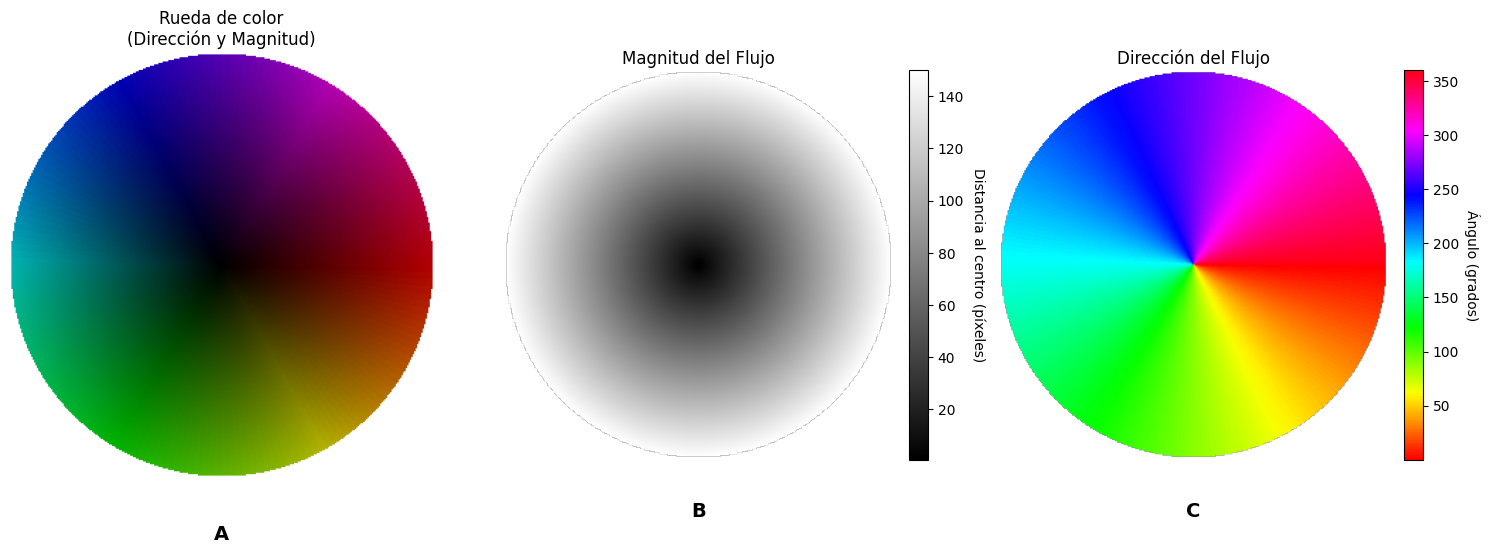

In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def dibujar_flechas(img, p0, p1, color=(0, 255, 0)):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for (x0, y0), (x1, y1) in zip(p0, p1):
        cv2.arrowedLine(img_rgb, (int(x1), int(y1)), (int(x0), int(y0)), color, 1, tipLength=0.3)
    return img_rgb

def flow_to_rgb2(flow):
    dx, dy = flow[0], flow[1]
    mag, ang = cv2.cartToPolar(dx, dy, angleInDegrees=True)

    hsv = np.zeros((flow.shape[1], flow.shape[2], 3), dtype=np.uint8)
    hsv[..., 0] = ang / 2  # OpenCV usa [0, 180] para H
    hsv[..., 1] = 255
    hsv[..., 2] = np.clip(mag * 255 / np.max(mag), 0, 255).astype(np.uint8) if np.max(mag) > 0 else 0
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), mag, ang

def generate_color_wheel(size=300):
    radius = size // 2
    x = np.linspace(-radius, radius, size)
    y = np.linspace(-radius, radius, size)
    X, Y = np.meshgrid(x, y)

    flow = np.zeros((2, size, size), dtype=np.float32)
    flow[0] = X
    flow[1] = Y

    color_wheel, mag, ang = flow_to_rgb2(flow)

    # Enmascarar fuera del círculo
    mask = X**2 + Y**2 > radius**2
    color_wheel[mask] = 255
    mag[mask] = np.nan
    ang[mask] = np.nan

    return color_wheel, mag, ang

# Generar datos
color_wheel, mag, ang = generate_color_wheel(300)

# Crear figura
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Rueda de color
axs[0].imshow(color_wheel)
axs[0].axis('off')
axs[0].set_title("Rueda de color\n(Dirección y Magnitud)")
axs[0].text(0.5, -0.15, "A", transform=axs[0].transAxes,
            fontsize=14, fontweight='bold', ha='center')

# Magnitud en escala de grises
mag_img = axs[1].imshow(mag, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Magnitud del Flujo")
axs[1].text(0.5, -0.15, "B", transform=axs[1].transAxes,
            fontsize=14, fontweight='bold', ha='center')
cbar1 = plt.colorbar(mag_img, ax=axs[1], fraction=0.046, pad=0.04)
cbar1.set_label("Distancia al centro (píxeles)", rotation=270, labelpad=15)

# Ángulo en colormap HSV
ang_img = axs[2].imshow(ang, cmap='hsv')
axs[2].axis('off')
axs[2].set_title("Dirección del Flujo")
axs[2].text(0.5, -0.15, "C", transform=axs[2].transAxes,
            fontsize=14, fontweight='bold', ha='center')
cbar2 = plt.colorbar(ang_img, ax=axs[2], fraction=0.046, pad=0.04)
cbar2.set_label("Ángulo (grados)", rotation=270, labelpad=15)

# Guardar imagen
plt.tight_layout()
plt.savefig("rueda_color_flujo_optico_completa.png", dpi=300, bbox_inches='tight')
plt.show()


## 4.1 Lucas Kanade Algorithm

La celda a continuación recoge la función de Lucas-Kanade para el cálculo de flujo óptico escaso. Para que devolviese la imagen corregida junto con el flujo, la corrección se realiza a partir de parches los cuales se desplazan según el flujo calculado.

In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_grid_points(size=(400, 400), grid_size=(10, 10)):
    h, w = size
    y_coords = np.linspace(h * 0.2, h * 0.8, grid_size[0])
    x_coords = np.linspace(w * 0.2, w * 0.8, grid_size[1])
    points = np.array([[x, y] for y in y_coords for x in x_coords], dtype=np.float32)
    return points.reshape(-1, 1, 2)

def Lucas_Kanade_Interpolado_Corregir(img_ref, img_dist, N, lk_params, patch_size=6):

    h, w = img_ref.shape

    # Rejilla de puntos “ideales”

    p0 = get_grid_points(size=(h, w), grid_size=(N, N))

    # LK escaso: flujo desde imagen de referencia a imagen

    p1, st, _ = cv2.calcOpticalFlowPyrLK(img_ref, img_dist, p0, None, **lk_params)
    if p1 is None or st.sum() < 4:
        print("Pocos puntos válidos")
        return img_dist.copy(), None

    p0g = np.squeeze(p0[st==1])   # (M,2) originales
    p1g = np.squeeze(p1[st==1])   # (M,2) distorsionados

    # Parches de la imagen
    r = patch_size // 2
    corrected = np.zeros_like(img_ref)

    for (x0, y0), (x1, y1) in zip(p0g, p1g):
        x0, y0 = int(round(x0)), int(round(y0))
        x1, y1 = int(round(x1)), int(round(y1))

        # límites en distorsionada
        x1_min, x1_max = max(0, x1-r), min(w, x1+r+1)
        y1_min, y1_max = max(0, y1-r), min(h, y1+r+1)
        patch = img_dist[y1_min:y1_max, x1_min:x1_max]

        # dónde pegar en la corregida
        x0_min, x0_max = x0 - (x1 - x1_min), x0 + (x1_max - x1)
        y0_min, y0_max = y0 - (y1 - y1_min), y0 + (y1_max - y1)

        # límite por si superamos bordes
        x0_min, x0_max = max(0, x0_min), min(w, x0_max)
        y0_min, y0_max = max(0, y0_min), min(h, y0_max)

        corrected[y0_min:y0_max, x0_min:x0_max] = patch

    flow_img = dibujar_flechas(img_dist, p0g, p1g)

    # Generamos una figura con la imagen distorsionada, la corregida y el flujo.

    fig, axs = plt.subplots(1,3,figsize=(12,5))
    axs[0].imshow(img_dist, cmap='gray'); axs[0].set_title("Imagen distorsionada"); axs[0].axis('off')
    axs[1].imshow(corrected, cmap='gray'); axs[1].set_title("Imagen Corregida (Lucas-Kanade)"); axs[1].axis('off')
    axs[2].imshow(flow_img); axs[2].set_title("Flujo óptico escaso (Lucas Kanade)"); axs[2].axis('off')


    plt.tight_layout()

    return corrected, fig





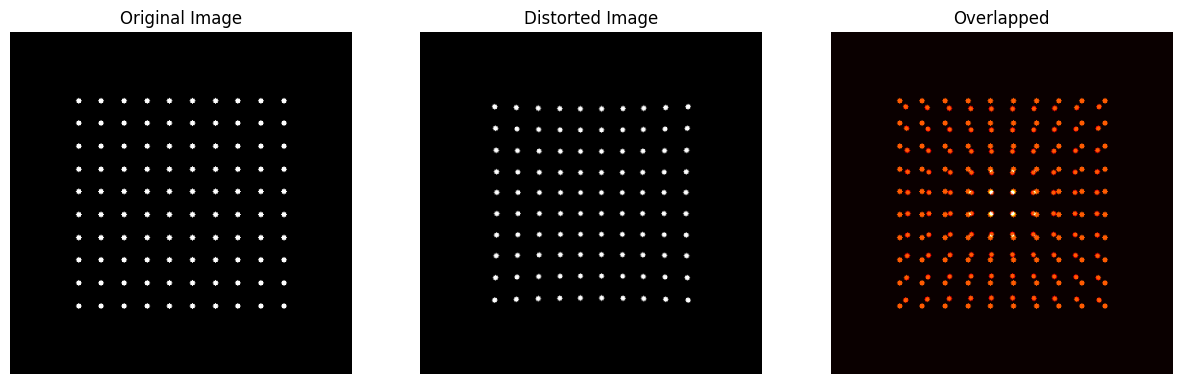

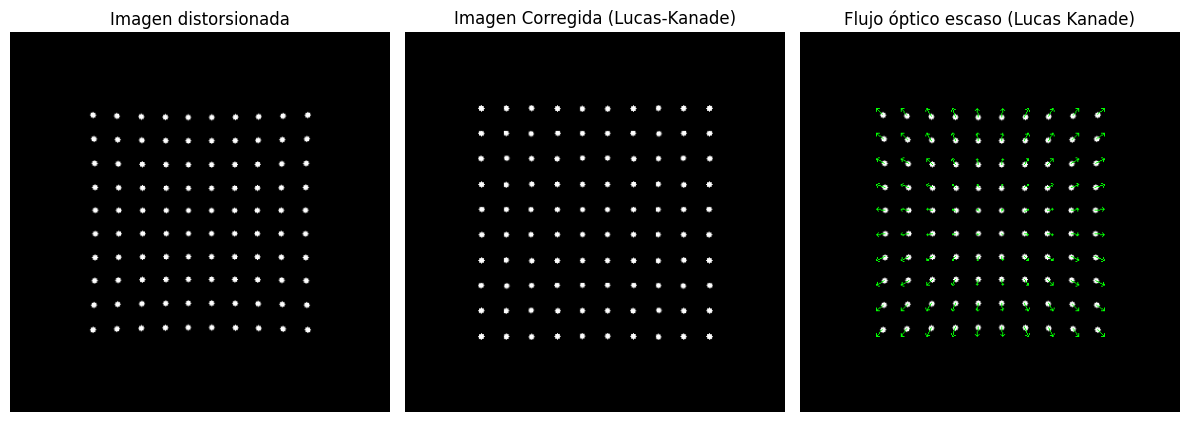

In [40]:
lk_params = dict( winSize = (9, 9), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

Flood_Histogram_Prueba,_=apply_custom_distortion(original_img, dist='seno', display='oculto', k_max=10)
_,Corrección_Kanade_Prueba=Lucas_Kanade_Interpolado_Corregir(original_img,Flood_Histogram_Prueba,N,
            lk_params=lk_params)

Corrección_Kanade_Prueba.savefig("Corrección Prueba.jpg")

## 4.2 Gunnar-Farneback Algorithm

El siguiente código presenta el método de Gunnar-Farneback para calcular el flujo óptico denso

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def Gunnar_Farneback_Optimizado(
    img_ref, img_dist,
    pyr_scale=0.5, levels=3, winsize=19, iterations=3,
    poly_n=7, poly_sigma=1.5, gaussian=0
):
    gray1 = img_ref if img_ref.ndim == 2 else cv2.cvtColor(img_ref, cv2.COLOR_BGR2GRAY)
    gray2 = img_dist if img_dist.ndim == 2 else cv2.cvtColor(img_dist, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(
        gray1, gray2, None,
        pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, gaussian
    )  # shape [H, W, 2]

    h, w = gray1.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + flow[:, :, 0]).astype(np.float32)
    map_y = (grid_y + flow[:, :, 1]).astype(np.float32)
    corrected = cv2.remap(img_dist, map_x, map_y, interpolation=cv2.INTER_LINEAR)


    flow_inverse = cv2.calcOpticalFlowFarneback(
        gray2, gray1, None,
        pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, gaussian)
    flow_full = flow_inverse.transpose(2, 0, 1)  # shape [2, H, W]
    flow_rgb,_,_ = flow_to_rgb2(flow_full)

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].imshow(img_dist, cmap='gray'); axs[0].set_title("Imagen distorsionada"); axs[0].axis('off')
    axs[1].imshow(corrected, cmap='gray'); axs[1].set_title("Imagen corregida (Gunnar-Farneback)"); axs[1].axis('off')
    axs[2].imshow(flow_rgb); axs[2].set_title("Flujo RGB (Gunnar-Farneback)"); axs[2].axis('off')


    plt.tight_layout()


    return corrected, fig




## 4.3 Corrección a las distorsiones generadas en los conjuntos de prueba para imagenes de llenado de campo

Vamos a usar estos método para corregir las imágenes de los conjuntos de prueba. Para ello, se han generado las siguiente celdas las cuales varían los parámetros de cada una de las funciones (LK o GF) con el objetivo de encontrar una combinación de parámetros que nos devuelva la mejor corrección posible. Antes de ejecutar estas celdas, primero es necesario ejecutar la función compute_l1_ssim() que se encuentra en el apartado 6.

### 4.3.1 Distorsión de rejilla

A partir del conjunto de prueba de imágenes con distorsión de rejilla, el siguiente código toma esas imágenes y les aplica LK y GF para intentar corregirlas, guardando las mejores correcciones juntos las métricas de corrección.


🖼️ Procesando distorted_image_000.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185


/tmp/ipython-input-41-1628399652.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(12, 5))


🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_001.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0945250019, SSIM = 0.99713, L2 = 21.44193

🖼️ Procesando distorted_image_002.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_003.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_004.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_005.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_006.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Proce

KeyboardInterrupt: 

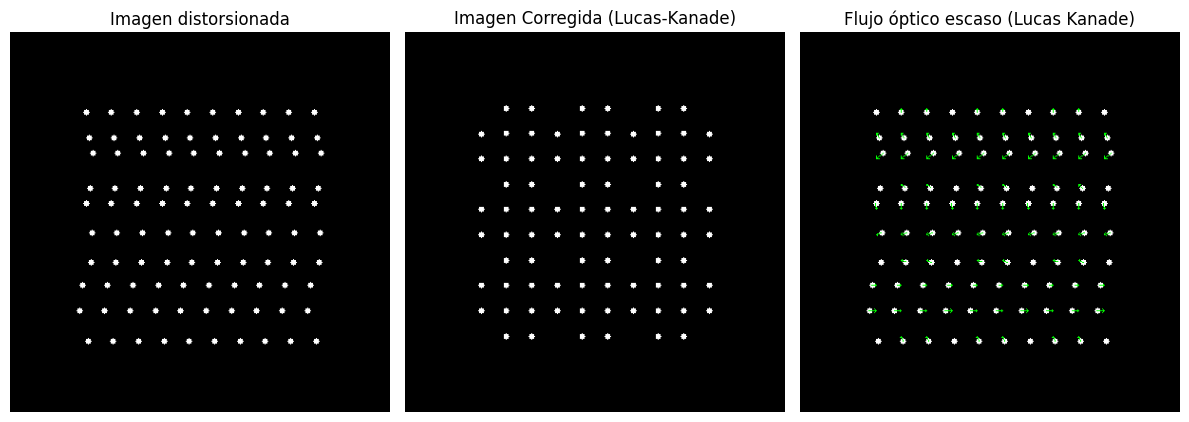

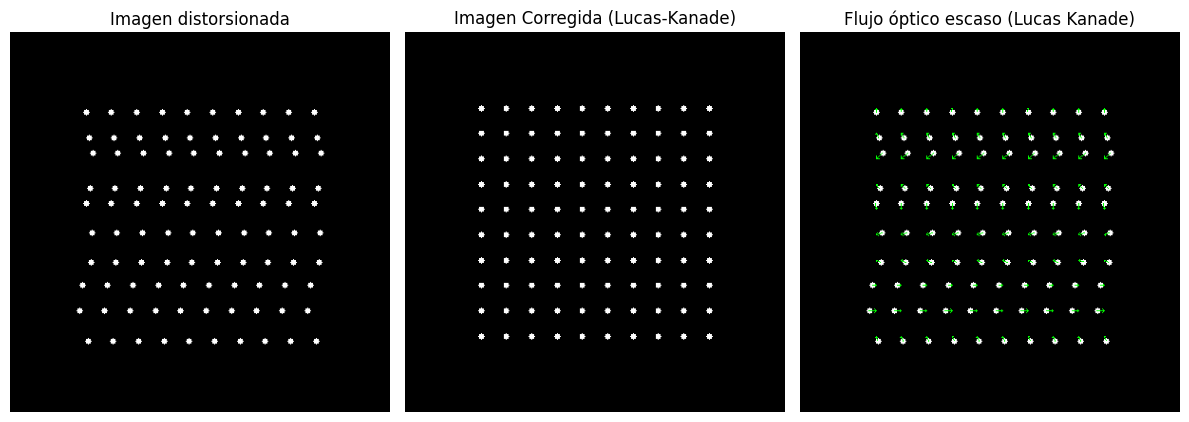

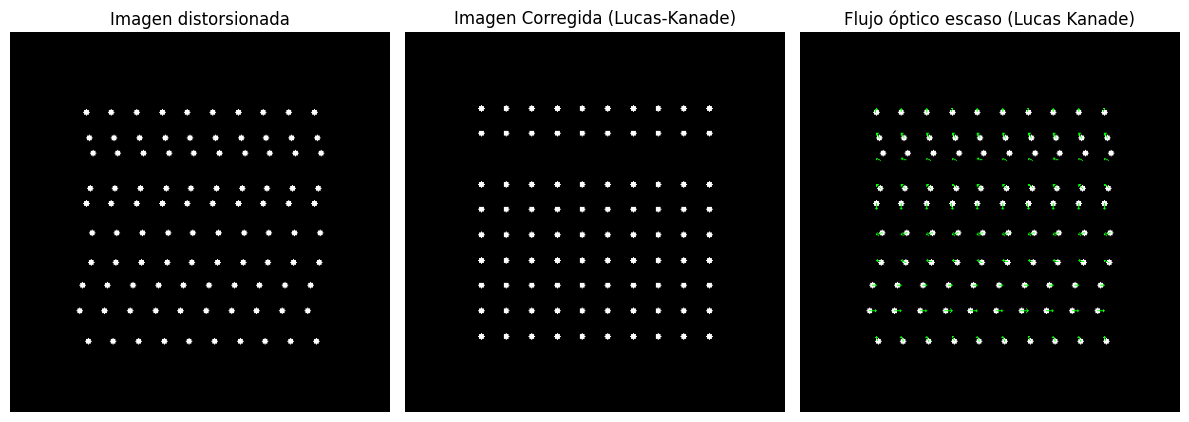

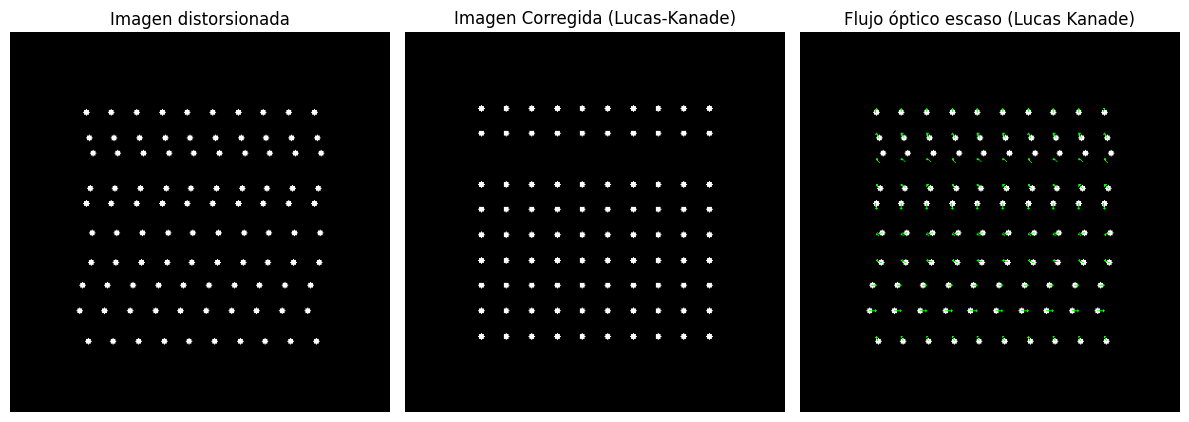

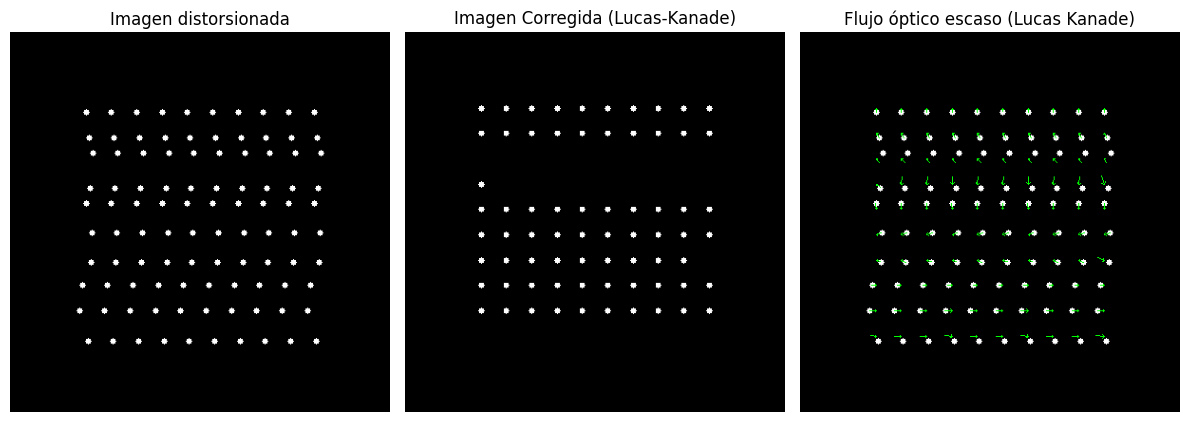

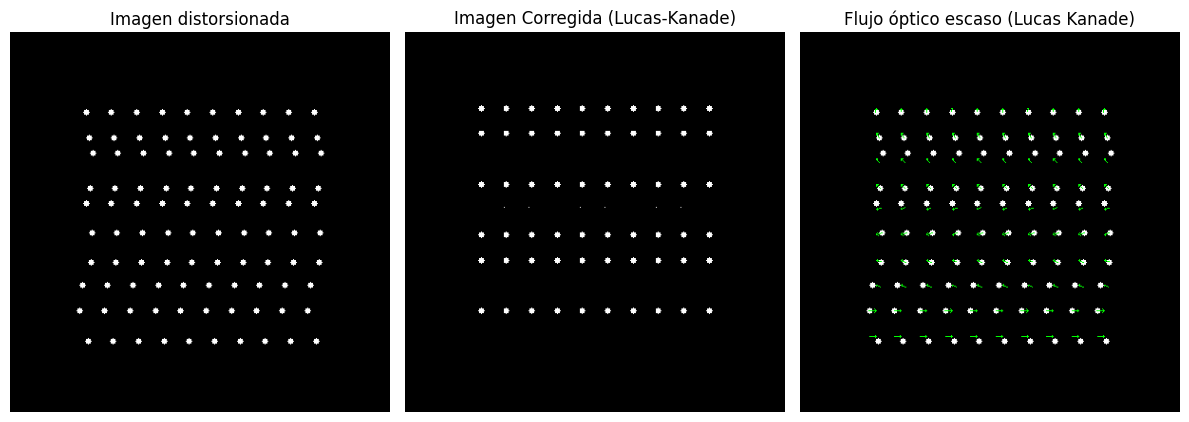

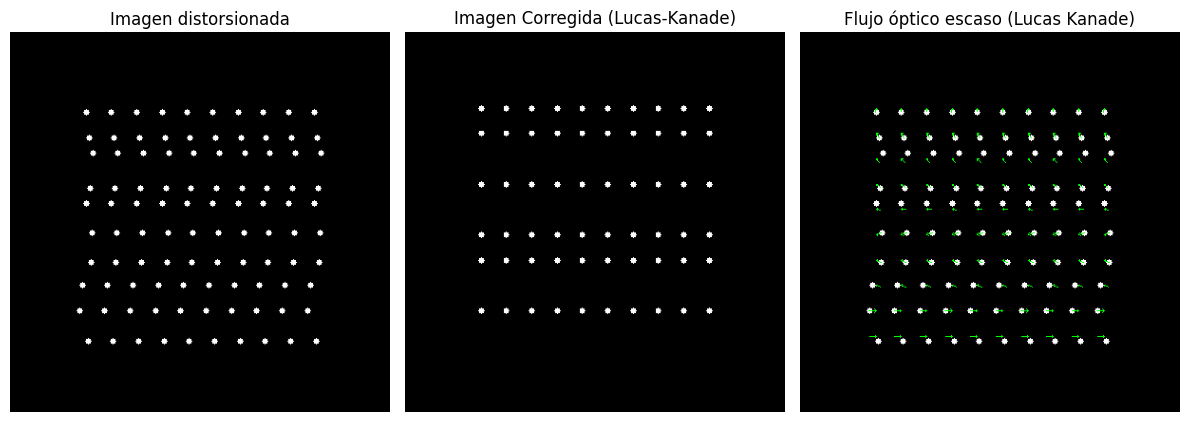

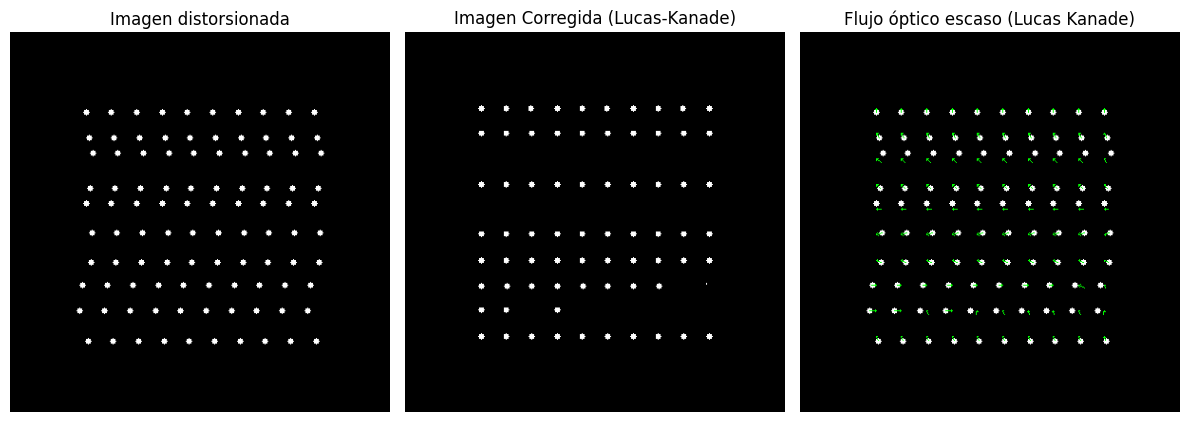

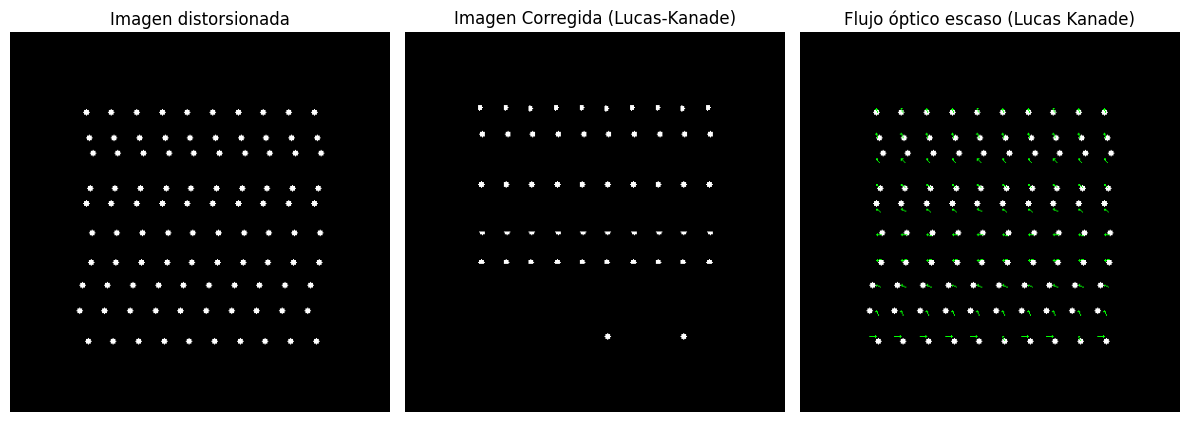

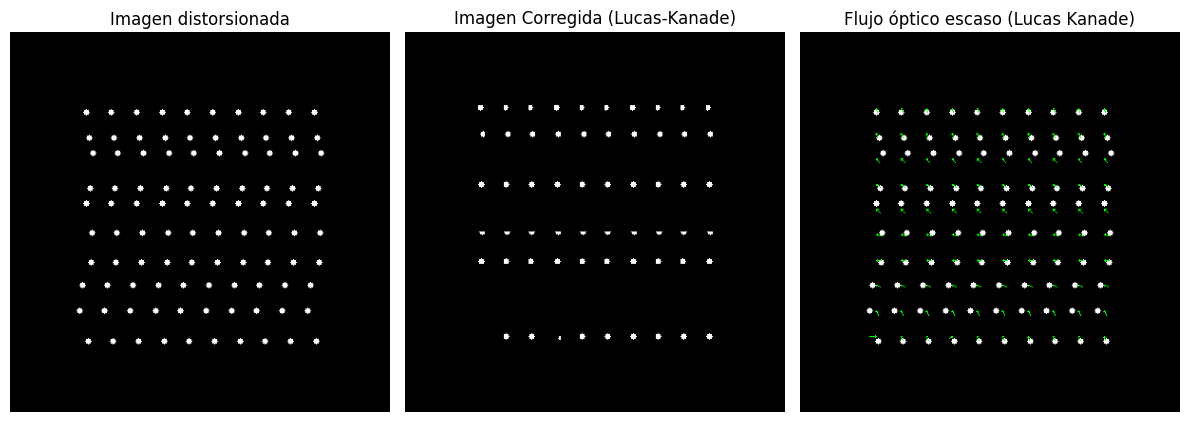

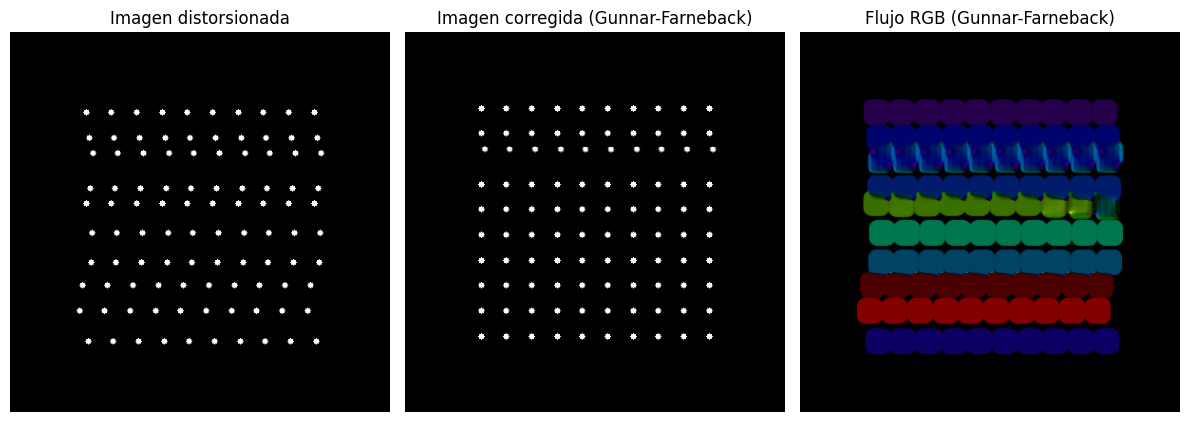

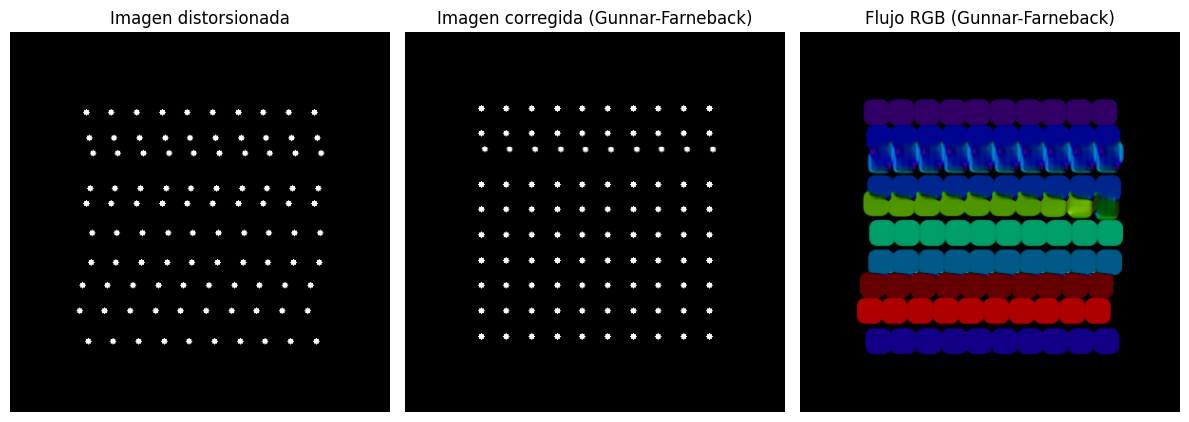

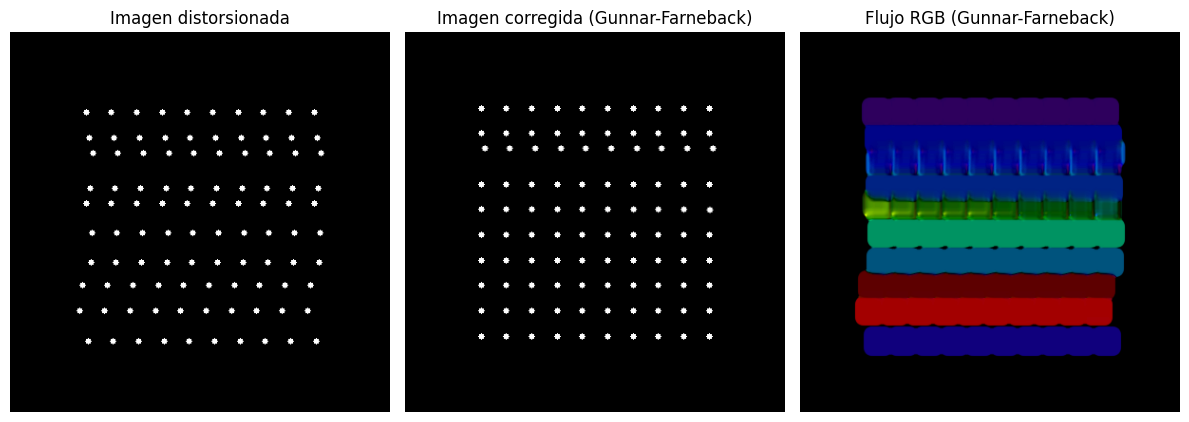

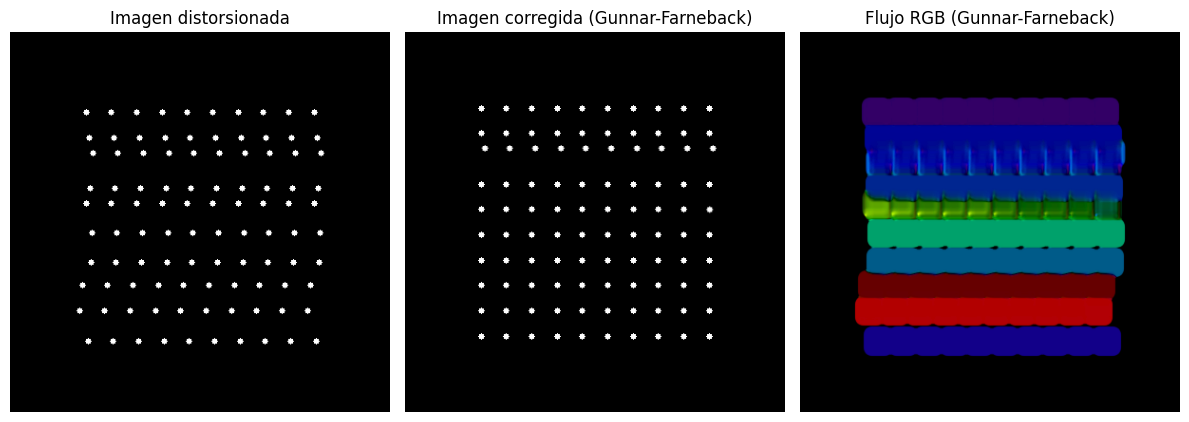

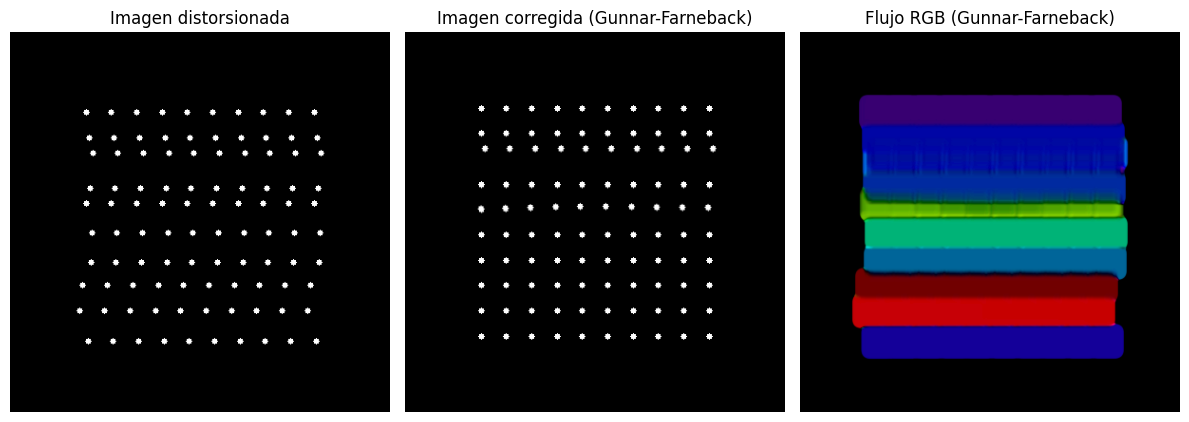

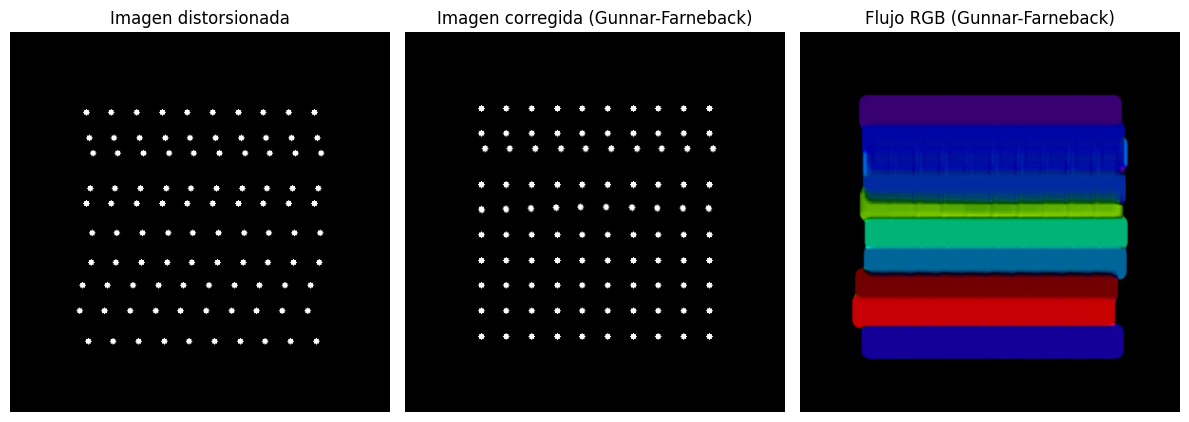

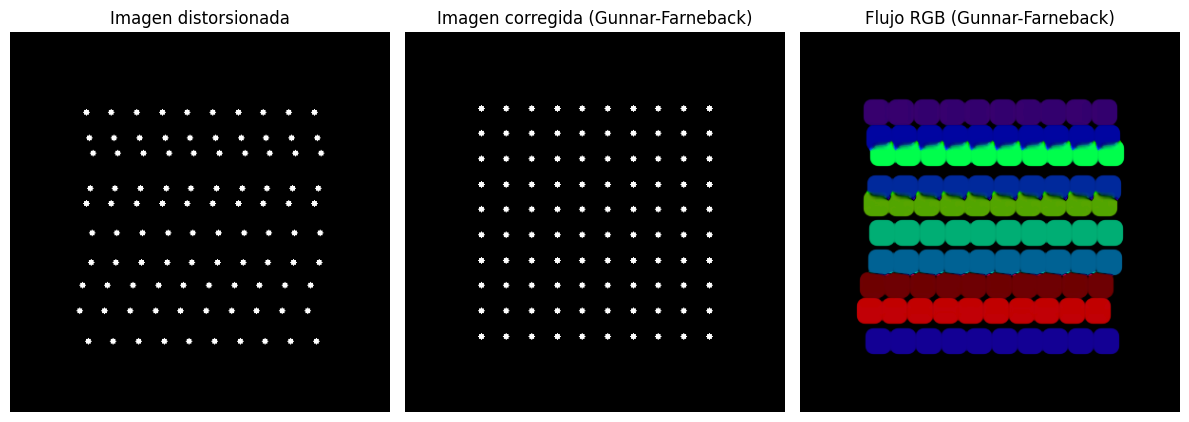

Error in callback <function flush_figures at 0x7858a2829800> (for post_execute):


KeyboardInterrupt: 

In [42]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
import pandas as pd

base_path = Path("data/Cristal_Miss/Pruebas")
dist_path = base_path / "npy"
orig_path = Path("data/originals/uniform_points.npy")

lk_img_dir = base_path / "Corrected_LK" / "imagenes"
lk_fig_dir = base_path / "Corrected_LK" / "figuras"
gf_img_dir = base_path / "Corrected_GF" / "imagenes"
gf_fig_dir = base_path / "Corrected_GF" / "figuras"

# Creamos las carpetas
for d in [lk_img_dir, lk_fig_dir, gf_img_dir, gf_fig_dir]:
    d.mkdir(parents=True, exist_ok=True)

# Cargamos la imagen original

img_ref = np.load(orig_path)
if img_ref.ndim == 3:
    img_ref = img_ref[0]
img_ref = img_ref.astype(np.float32)
img_ref = img_ref / 255.0 if img_ref.max() > 1 else img_ref
img_ref_8u = img_as_ubyte(img_ref)

# Combinaciones de parámetros de las funciones (se pueden modificar si queremos más valores)

lk_win_grid = [
    dict(winSize=(w, w), maxLevel=2,
         criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    for w in [3, 6, 9, 15, 21, 27, 33, 39, 50, 70, 100]
]

gf_param_grid = [
    dict(pyr_scale=ps, winsize=ws, poly_n=pn)
    for ps in [0.3, 0.5, 0.7]
    for ws in [15, 19, 25]
    for pn in [5, 7]
]

# Generamos el almacenamiento de las métricas de corrección para su posterior análisis
metricas = {
    "filename": [],
    "L1_LK": [],
    "L2_LK": [],
    "SSIM_LK": [],
    "L1_GF": [],
    "L2_GF": [],
    "SSIM_GF": [],
}

# Procesamos las imágenes

for file in sorted(dist_path.glob("*.npy")):
    img_dist = np.load(file)
    if img_dist.ndim == 3:
        img_dist = img_dist[0]
    img_dist = img_dist.astype(np.float32)
    img_dist = img_dist / img_dist.max() if img_dist.max() > 1 else img_dist
    img_dist_8u = img_as_ubyte(img_dist)

    print(f"\n🖼️ Procesando {file.name}...")

    # LK- busca la mejor combinación de parámetros que devuelven la mejor corrección, y guarda la imagen y la figura generadas por la función de LK
    best_l1_lk = np.inf
    best_l2_lk = np.inf
    best_ssim_lk = -1
    best_corr_lk, best_fig_lk = None, None

    for lk_params in lk_win_grid:
        corrected, fig = Lucas_Kanade_Interpolado_Corregir(
            img_ref_8u, img_dist_8u, N, lk_params)
        if corrected is None:
            continue
        l1, ssim_val, l2 = compute_l1_ssim(corrected, img_ref_8u)
        if l1 < best_l1_lk:
            best_l1_lk = l1
            best_l2_lk = l2
            best_ssim_lk = ssim_val
            best_corr_lk = corrected.copy()
            best_fig_lk = fig

    if best_corr_lk is not None:
        np.save(lk_img_dir / file.name.replace(".npy", "_corrected.npy"), best_corr_lk)
        best_fig_lk.savefig(lk_fig_dir / file.name.replace(".npy", "_figura.png"))
        plt.close(best_fig_lk)
        print(f"🔹 LK: L1 = {best_l1_lk:.10f}, SSIM = {best_ssim_lk:.5f}, L2 = {best_l2_lk:.10f}")

    # GF- busca la mejor combinación de parámetros que devuelven la mejor corrección, y guarda la imagen y la figura generadas por la función de GF
    best_l1_gf = np.inf
    best_l2_gf = np.inf
    best_ssim_gf = -1
    best_corr_gf, best_fig_gf = None, None

    for params in gf_param_grid:
        corrected, fig = Gunnar_Farneback_Optimizado(
            img_ref_8u, img_dist_8u,
            pyr_scale=params['pyr_scale'],
            winsize=params['winsize'],
            poly_n=params['poly_n'],
            poly_sigma=1.5, gaussian=0
        )
        if corrected is None:
            continue
        l1, ssim_val, l2 = compute_l1_ssim(corrected, img_ref_8u)
        if l1 < best_l1_gf:
            best_l1_gf = l1
            best_l2_gf = l2
            best_ssim_gf = ssim_val
            best_corr_gf = corrected.copy()
            best_fig_gf = fig

    if best_corr_gf is not None:
        np.save(gf_img_dir / file.name.replace(".npy", "_corrected.npy"), best_corr_gf)
        best_fig_gf.savefig(gf_fig_dir / file.name.replace(".npy", "_figura.png"))
        plt.close(best_fig_gf)
        print(f"🔹 GF: L1 = {best_l1_gf:.10f}, SSIM = {best_ssim_gf:.5f}, L2 = {best_l2_gf:.5f}")

    # Guardamos las métricas de corrección para las imágenes corregidas más parecidas a la original

    metricas["filename"].append(file.name)
    metricas["L1_LK"].append(best_l1_lk)
    metricas["L2_LK"].append(best_l2_lk)
    metricas["SSIM_LK"].append(best_ssim_lk)
    metricas["L1_GF"].append(best_l1_gf)
    metricas["L2_GF"].append(best_l2_gf)
    metricas["SSIM_GF"].append(best_ssim_gf)

df_metrics = pd.DataFrame(metricas)
df_metrics.to_csv(base_path / "metricas_correccion.csv", index=False)

print("\n✅ Procesamiento, optimización y guardado de métricas completados.")






### 4.3.2 Border compression

A partir del conjunto de prueba de imágenes con distorsión de compresión en los bordes, el siguiente código toma esas imágenes y les aplica LK y GF para intentar corregirlas, guardando las mejores correcciones juntos las métricas de corrección.


🖼️ Procesando distorted_image_000.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185


/tmp/ipython-input-41-1628399652.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(12, 5))


🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_001.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_002.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_003.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_004.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_005.npy...
🔹 LK: L1 = 0.0956249982, SSIM = 0.99623, L2 = 24.3843746185
🔹 GF: L1 = 0.0000000000, SSIM = 1.00000, L2 = 0.00000

🖼️ Procesando distorted_image_006.npy...
🔹 LK: L1 = 0.8255624771, SSIM = 0.98127, L2 = 210.5184478760
🔹 GF: L1 = 0.3663625121, SSIM = 0.98582, L2 = 66.47935

🖼️ Proc

KeyboardInterrupt: 

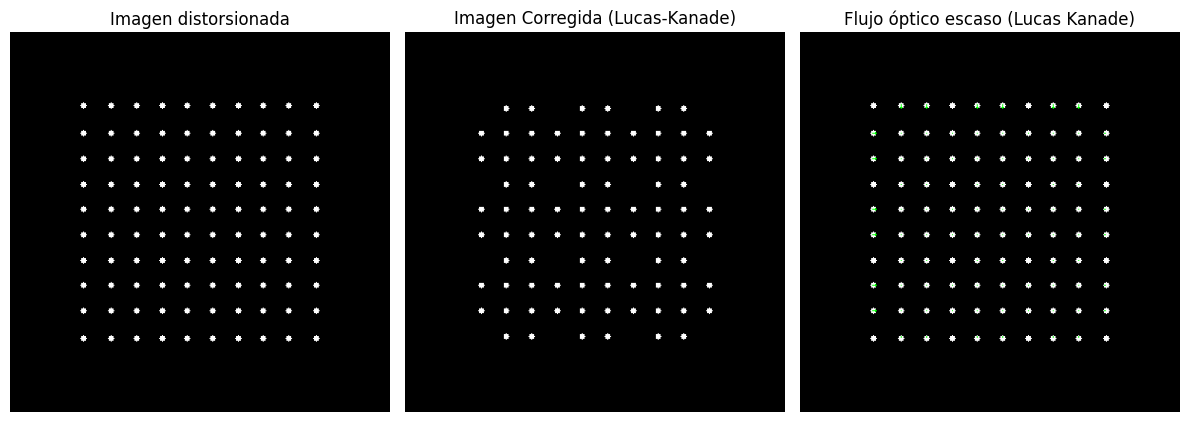

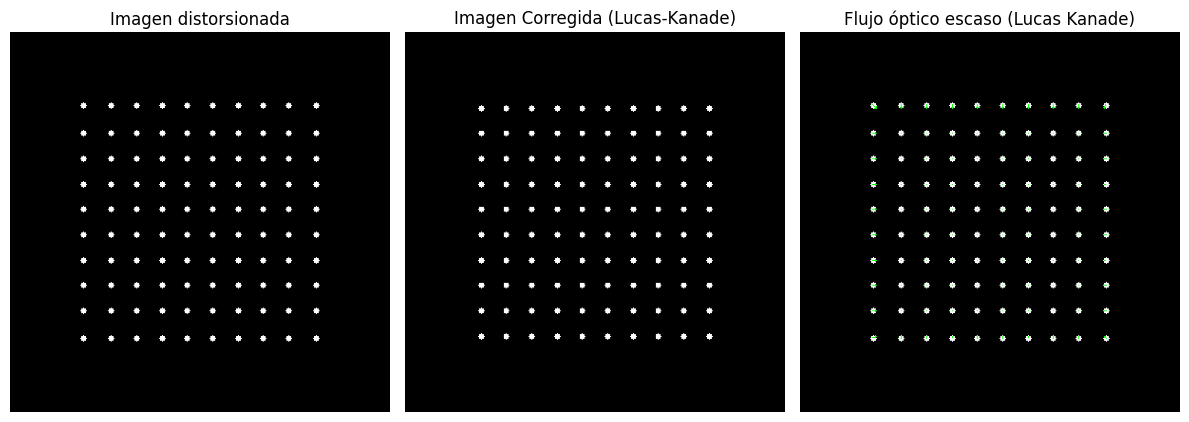

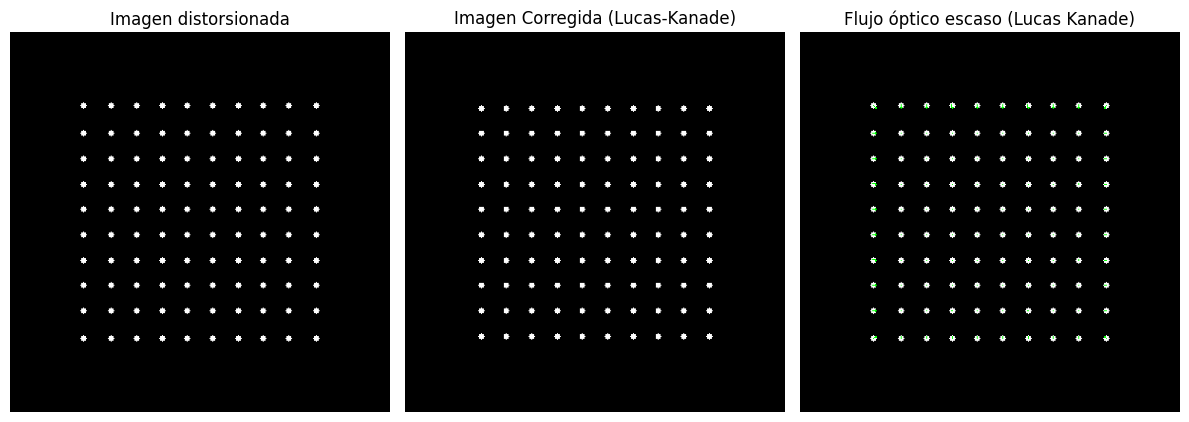

Error in callback <function flush_figures at 0x7858a2829800> (for post_execute):


KeyboardInterrupt: 

In [43]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
import pandas as pd

base_path = Path("data/Compression/Prueba")
dist_path = base_path / "npy"
orig_path = Path("data/originals/uniform_points.npy")

lk_img_dir = base_path / "Corrected_LK" / "imagenes"
lk_fig_dir = base_path / "Corrected_LK" / "figuras"
gf_img_dir = base_path / "Corrected_GF" / "imagenes"
gf_fig_dir = base_path / "Corrected_GF" / "figuras"


for d in [lk_img_dir, lk_fig_dir, gf_img_dir, gf_fig_dir]:
    d.mkdir(parents=True, exist_ok=True)


img_ref = np.load(orig_path)
if img_ref.ndim == 3:
    img_ref = img_ref[0]
img_ref = img_ref.astype(np.float32)
img_ref = img_ref / 255.0 if img_ref.max() > 1 else img_ref
img_ref_8u = img_as_ubyte(img_ref)


N = 10

lk_win_grid = [
    dict(winSize=(w, w), maxLevel=2,
         criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    for w in [3, 6, 9, 15, 21, 27, 33, 39, 50, 70, 100]
]

gf_param_grid = [
    dict(pyr_scale=ps, winsize=ws, poly_n=pn)
    for ps in [0.3, 0.5, 0.7]
    for ws in [15, 19, 25]
    for pn in [5, 7]
]


metricas = {
    "filename": [],
    "L1_LK": [],
    "L2_LK": [],
    "SSIM_LK": [],
    "L1_GF": [],
    "L2_GF": [],
    "SSIM_GF": [],
}


for file in sorted(dist_path.glob("*.npy")):
    img_dist = np.load(file)
    if img_dist.ndim == 3:
        img_dist = img_dist[0]
    img_dist = img_dist.astype(np.float32)
    img_dist = img_dist / img_dist.max() if img_dist.max() > 1 else img_dist
    img_dist_8u = img_as_ubyte(img_dist)

    print(f"\n🖼️ Procesando {file.name}...")


    best_l1_lk = np.inf
    best_l2_lk = np.inf
    best_ssim_lk = -1
    best_corr_lk, best_fig_lk = None, None

    for lk_params in lk_win_grid:
        corrected, fig = Lucas_Kanade_Interpolado_Corregir(
            img_ref_8u, img_dist_8u, N, lk_params)
        if corrected is None:
            continue
        l1, ssim_val, l2 = compute_l1_ssim(corrected, img_ref_8u)
        if l1 < best_l1_lk:
            best_l1_lk = l1
            best_l2_lk = l2
            best_ssim_lk = ssim_val
            best_corr_lk = corrected.copy()
            best_fig_lk = fig

    if best_corr_lk is not None:
        np.save(lk_img_dir / file.name.replace(".npy", "_corrected.npy"), best_corr_lk)
        best_fig_lk.savefig(lk_fig_dir / file.name.replace(".npy", "_figura.png"))
        plt.close(best_fig_lk)
        print(f"🔹 LK: L1 = {best_l1_lk:.10f}, SSIM = {best_ssim_lk:.5f}, L2 = {best_l2_lk:.10f}")


    best_l1_gf = np.inf
    best_l2_gf = np.inf
    best_ssim_gf = -1
    best_corr_gf, best_fig_gf = None, None

    for params in gf_param_grid:
        corrected, fig = Gunnar_Farneback_Optimizado(
            img_ref_8u, img_dist_8u,
            pyr_scale=params['pyr_scale'],
            winsize=params['winsize'],
            poly_n=params['poly_n'],
            poly_sigma=1.5, gaussian=0
        )
        if corrected is None:
            continue
        l1, ssim_val, l2 = compute_l1_ssim(corrected, img_ref_8u)
        if l1 < best_l1_gf:
            best_l1_gf = l1
            best_l2_gf = l2
            best_ssim_gf = ssim_val
            best_corr_gf = corrected.copy()
            best_fig_gf = fig

    if best_corr_gf is not None:
        np.save(gf_img_dir / file.name.replace(".npy", "_corrected.npy"), best_corr_gf)
        best_fig_gf.savefig(gf_fig_dir / file.name.replace(".npy", "_figura.png"))
        plt.close(best_fig_gf)
        print(f"🔹 GF: L1 = {best_l1_gf:.10f}, SSIM = {best_ssim_gf:.5f}, L2 = {best_l2_gf:.5f}")


    metricas["filename"].append(file.name)
    metricas["L1_LK"].append(best_l1_lk)
    metricas["L2_LK"].append(best_l2_lk)
    metricas["SSIM_LK"].append(best_ssim_lk)
    metricas["L1_GF"].append(best_l1_gf)
    metricas["L2_GF"].append(best_l2_gf)
    metricas["SSIM_GF"].append(best_ssim_gf)


df_metrics = pd.DataFrame(metricas)
df_metrics.to_csv(base_path / "metricas_correccion.csv", index=False)

print("\n✅ Procesamiento, optimización y guardado de métricas completados.")

### 4.3.3 Aberración en los bordes

A partir del conjunto de prueba de imágenes con distorsión de ruido y atenuación de los bordes, el siguiente código toma esas imágenes y les aplica LK y GF para intentar corregirlas, guardando las mejores correcciones juntos las métricas de corrección.


🖼️ Procesando distorted_image_000.npy...
🔹 LK: L1 = 3.17900, SSIM = 0.93669, L2 = 620.95056


/tmp/ipython-input-41-1628399652.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(12, 5))


🔹 GF: L1 = 4.6621499062, SSIM = 0.86119, L2 = 637.17236

🖼️ Procesando distorted_image_001.npy...
🔹 LK: L1 = 2.82756, SSIM = 0.94459, L2 = 484.94965
🔹 GF: L1 = 3.5193374157, SSIM = 0.91418, L2 = 447.33951

🖼️ Procesando distorted_image_002.npy...
🔹 LK: L1 = 2.58833, SSIM = 0.95259, L2 = 384.17474
🔹 GF: L1 = 2.9789500237, SSIM = 0.93851, L2 = 327.85815

🖼️ Procesando distorted_image_003.npy...
🔹 LK: L1 = 1.98382, SSIM = 0.96568, L2 = 246.18030
🔹 GF: L1 = 2.3236062527, SSIM = 0.95471, L2 = 196.12918

🖼️ Procesando distorted_image_004.npy...
🔹 LK: L1 = 2.34119, SSIM = 0.95845, L2 = 327.89951
🔹 GF: L1 = 2.8090374470, SSIM = 0.94275, L2 = 291.09396

🖼️ Procesando distorted_image_005.npy...
🔹 LK: L1 = 2.76230, SSIM = 0.94767, L2 = 442.93015
🔹 GF: L1 = 3.3106000423, SSIM = 0.92410, L2 = 396.77731

🖼️ Procesando distorted_image_006.npy...
🔹 LK: L1 = 2.69692, SSIM = 0.95031, L2 = 432.62640
🔹 GF: L1 = 3.4673936367, SSIM = 0.91737, L2 = 409.00110

🖼️ Procesando distorted_image_007.npy...
🔹 LK: L1

KeyboardInterrupt: 

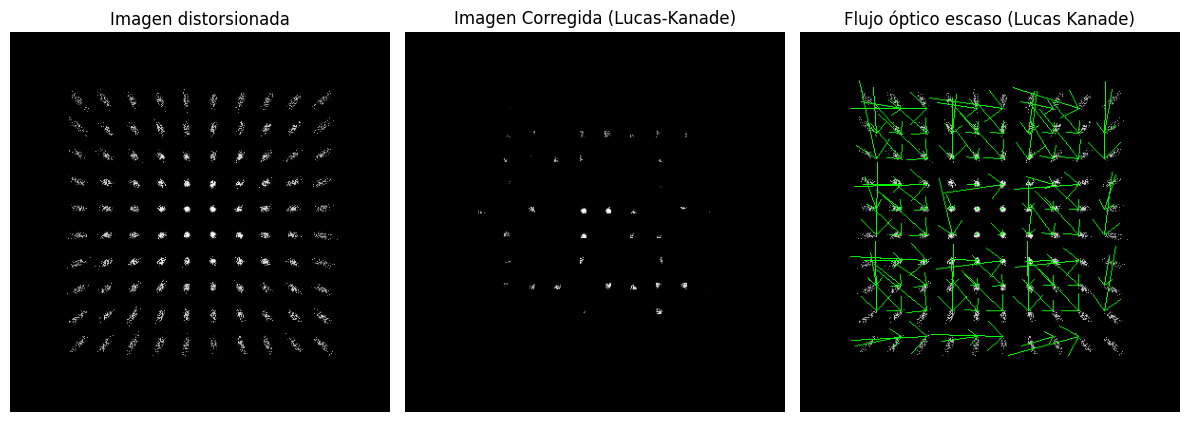

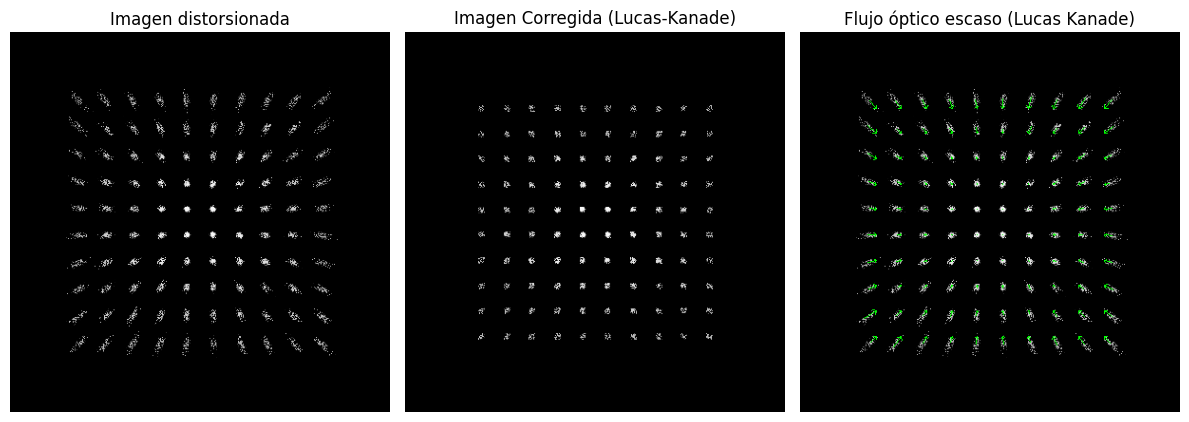

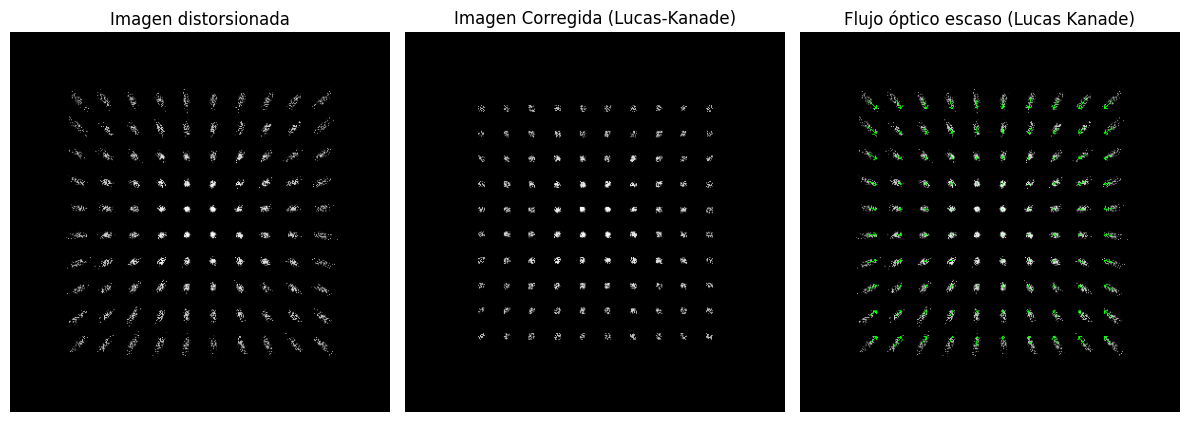

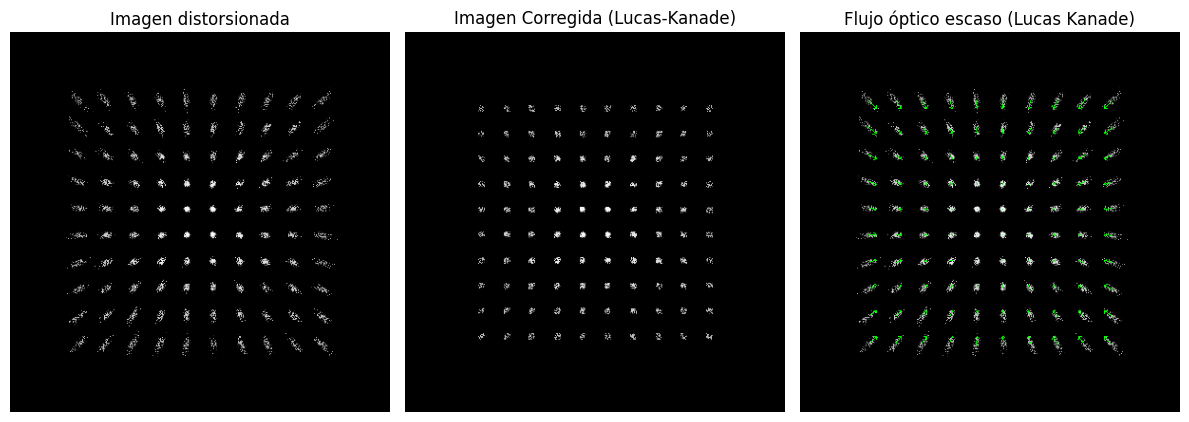

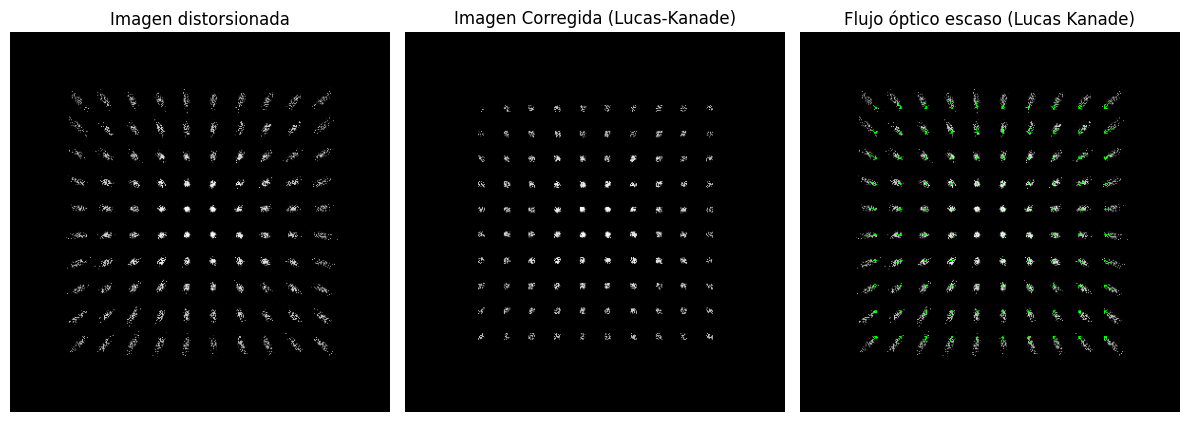

Error in callback <function flush_figures at 0x7858a2829800> (for post_execute):


KeyboardInterrupt: 

In [44]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
import pandas as pd

base_path = Path("data/Border_Noise/Prueba")
dist_path = base_path / "npy"
orig_path = Path("data/originals/uniform_points.npy")

lk_img_dir = base_path / "Corrected_LK" / "imagenes"
lk_fig_dir = base_path / "Corrected_LK" / "figuras"
gf_img_dir = base_path / "Corrected_GF" / "imagenes"
gf_fig_dir = base_path / "Corrected_GF" / "figuras"


for d in [lk_img_dir, lk_fig_dir, gf_img_dir, gf_fig_dir]:
    d.mkdir(parents=True, exist_ok=True)


img_ref = np.load(orig_path)
if img_ref.ndim == 3:
    img_ref = img_ref[0]
img_ref = img_ref.astype(np.float32)
img_ref = img_ref / 255.0 if img_ref.max() > 1 else img_ref
img_ref_8u = img_as_ubyte(img_ref)


N = 10

lk_win_grid = [
    dict(winSize=(w, w), maxLevel=2,
         criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    for w in [3, 6, 9, 15, 21, 27, 33, 39, 50, 70, 100]
]

gf_param_grid = [
    dict(pyr_scale=ps, winsize=ws, poly_n=pn)
    for ps in [0.3, 0.5, 0.7]
    for ws in [15, 19, 25]
    for pn in [5, 7]
]


metricas = {
    "filename": [],
    "L1_LK": [],
    "L2_LK": [],
    "SSIM_LK": [],
    "L1_GF": [],
    "L2_GF": [],
    "SSIM_GF": [],
}


for file in sorted(dist_path.glob("*.npy")):
    img_dist = np.load(file)
    if img_dist.ndim == 3:
        img_dist = img_dist[0]
    img_dist = img_dist.astype(np.float32)
    img_dist = img_dist / img_dist.max() if img_dist.max() > 1 else img_dist
    img_dist_8u = img_as_ubyte(img_dist)

    print(f"\n🖼️ Procesando {file.name}...")


    best_l1_lk = np.inf
    best_l2_lk = np.inf
    best_ssim_lk = -1
    best_corr_lk, best_fig_lk = None, None

    for lk_params in lk_win_grid:
        corrected, fig = Lucas_Kanade_Interpolado_Corregir(
            img_ref_8u, img_dist_8u, N, lk_params)
        if corrected is None:
            continue
        l1, ssim_val, l2 = compute_l1_ssim(corrected, img_ref_8u)
        if l1 < best_l1_lk:
            best_l1_lk = l1
            best_l2_lk = l2
            best_ssim_lk = ssim_val
            best_corr_lk = corrected.copy()
            best_fig_lk = fig

    if best_corr_lk is not None:
        np.save(lk_img_dir / file.name.replace(".npy", "_corrected.npy"), best_corr_lk)
        best_fig_lk.savefig(lk_fig_dir / file.name.replace(".npy", "_figura.png"))
        plt.close(best_fig_lk)
        print(f"🔹 LK: L1 = {best_l1_lk:.5f}, SSIM = {best_ssim_lk:.5f}, L2 = {best_l2_lk:.5f}")


    best_l1_gf = np.inf
    best_l2_gf = np.inf
    best_ssim_gf = -1
    best_corr_gf, best_fig_gf = None, None

    for params in gf_param_grid:
        corrected, fig = Gunnar_Farneback_Optimizado(
            img_ref_8u, img_dist_8u,
            pyr_scale=params['pyr_scale'],
            winsize=params['winsize'],
            poly_n=params['poly_n'],
            poly_sigma=1.5, gaussian=0
        )
        if corrected is None:
            continue
        l1, ssim_val, l2 = compute_l1_ssim(corrected, img_ref_8u)
        if l1 < best_l1_gf:
            best_l1_gf = l1
            best_l2_gf = l2
            best_ssim_gf = ssim_val
            best_corr_gf = corrected.copy()
            best_fig_gf = fig

    if best_corr_gf is not None:
        np.save(gf_img_dir / file.name.replace(".npy", "_corrected.npy"), best_corr_gf)
        best_fig_gf.savefig(gf_fig_dir / file.name.replace(".npy", "_figura.png"))
        plt.close(best_fig_gf)
        print(f"🔹 GF: L1 = {best_l1_gf:.10f}, SSIM = {best_ssim_gf:.5f}, L2 = {best_l2_gf:.5f}")


    metricas["filename"].append(file.name)
    metricas["L1_LK"].append(best_l1_lk)
    metricas["L2_LK"].append(best_l2_lk)
    metricas["SSIM_LK"].append(best_ssim_lk)
    metricas["L1_GF"].append(best_l1_gf)
    metricas["L2_GF"].append(best_l2_gf)
    metricas["SSIM_GF"].append(best_ssim_gf)


df_metrics = pd.DataFrame(metricas)
df_metrics.to_csv(base_path / "metricas_correccion.csv", index=False)

print("\n✅ Procesamiento, optimización y guardado de métricas completados.")

## 4.4 Correccion de las distorsiones aplicadas a las imágenes satelitales con los algoritmos tradicionales.

La siguiente celda aplica el algoritmo de Gunnar-Farneback para corregir las distorsiones generadas en las imágense satelitales, guardando tanto la imagen corregida como el flujo óptico

In [45]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np



# Ruta base de las regiones
base_dir = Path("data/sat")

# Opciones de parámetros
param_combinations = [
    {"pyr_scale": 0.5, "levels": 3, "winsize": 15},
    {"pyr_scale": 0.5, "levels": 4, "winsize": 21},
    {"pyr_scale": 0.4, "levels": 3, "winsize": 17},
    {"pyr_scale": 0.6, "levels": 2, "winsize": 11},
    {"pyr_scale": 0.5, "levels": 3, "winsize": 13},
]

# Iteramos  sobre todas las regiones
for region_dir in sorted(base_dir.glob("region*")):
    region_name = region_dir.name
    print(f"Procesando {region_name}...")

    # Cargamos la imagen original
    original_path = region_dir / "original" / f"{region_name}_original.png"
    original = cv2.imread(str(original_path), cv2.IMREAD_GRAYSCALE)

    # Directorio con imágenes distorsionadas
    distorted_dir = region_dir / "distorted"

    # Directorio donde guardamos resultados
    output_dir = region_dir / "flow_output"
    output_dir.mkdir(parents=True, exist_ok=True)

    # Iteramos sobre todas las distorsiones de esta región
    for dist_path in sorted(distorted_dir.glob(f"{region_name}_distorted_*.png")):
        dist_name = dist_path.stem
        print(f"  → Distorsión: {dist_name}")

        dist_img = cv2.imread(str(dist_path), cv2.IMREAD_GRAYSCALE)

        best_ssim = -1.0
        best_corrected = None
        best_fig = None


        for i, params in enumerate(param_combinations):
            try:
                corrected, fig = Gunnar_Farneback_Optimizado(original, dist_img, **params)
                _, ssim_val, _ = compute_l1_ssim(original, corrected)

                if ssim_val > best_ssim:
                    best_ssim = ssim_val
                    best_corrected = corrected
                    best_fig = fig
            except Exception as e:
                print(f"    ⚠️ Error con parámetros {params}: {e}")
                continue

        if best_corrected is not None:
            # Guardamos la imagen corregida
            corrected_path = output_dir / f"{dist_name}_corrected.png"
            cv2.imwrite(str(corrected_path), best_corrected)

            # Guardamos la figura comparativa
            fig_path = output_dir / f"{dist_name}_results.png"
            best_fig.savefig(str(fig_path))
            plt.close(best_fig)
        else:
            print(f"    ❌ No se pudo corregir la imagen {dist_name}.")



Procesando region1...
  → Distorsión: region1_distorted_1
  → Distorsión: region1_distorted_2
  → Distorsión: region1_distorted_3
Procesando region10...
  → Distorsión: region10_distorted_1
  → Distorsión: region10_distorted_2


/tmp/ipython-input-41-1628399652.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(12, 5))


  → Distorsión: region10_distorted_3
Procesando region2...
  → Distorsión: region2_distorted_1
  → Distorsión: region2_distorted_2
  → Distorsión: region2_distorted_3
Procesando region3...
  → Distorsión: region3_distorted_1
  → Distorsión: region3_distorted_2
  → Distorsión: region3_distorted_3
Procesando region4...
  → Distorsión: region4_distorted_1
  → Distorsión: region4_distorted_2
  → Distorsión: region4_distorted_3
Procesando region5...
  → Distorsión: region5_distorted_1
  → Distorsión: region5_distorted_2
  → Distorsión: region5_distorted_3
Procesando region6...
  → Distorsión: region6_distorted_1
  → Distorsión: region6_distorted_2
  → Distorsión: region6_distorted_3
Procesando region7...
  → Distorsión: region7_distorted_1
  → Distorsión: region7_distorted_2
  → Distorsión: region7_distorted_3
Procesando region8...
  → Distorsión: region8_distorted_1
  → Distorsión: region8_distorted_2
  → Distorsión: region8_distorted_3
Procesando region9...
  → Distorsión: region9_distort

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7858a2829800> (for post_execute):


KeyboardInterrupt: 

# 5. Redes neuronales

Ahora entrenaremos las redes neuronales para resolver las distorsiones de las imágenes de llenado de campo

## 5.1 Instalaciones

Importamos y descargamos todas las librerías que vamos a utilizar

In [46]:
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from pathlib import Path
from tqdm import tqdm
from torchvision.transforms.functional import resize
import torch.nn.functional as F

In [47]:
pip install torch torchvision kornia


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 926.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 770.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 81.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [48]:
pip install pytorch-msssim

In [49]:
pip install segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.9 MB/s eta 0:00:00


In [50]:
pip install -U kornia


## 5.2 Distorsión de rejilla resuelta por una red neuronal

Esta celda genera, tanto los datasets para el entranamiento, como el modelo de red usado para resolver la distorsión de rejilla

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset

class DistortedPointsDataset(Dataset):
    def __init__(self, npy_dir, original_npy_path, grid_size=(10,10), h=400, w=400):
        self.npy_files = list(Path(npy_dir).glob('*.npy'))
        self.original = np.load(original_npy_path).astype(np.float32)
        ys = np.linspace(h*0.2, h*0.8, grid_size[0]) / h
        xs = np.linspace(w*0.2, w*0.8, grid_size[1]) / w
        self.centroids = np.stack(np.meshgrid(xs, ys), -1).reshape(-1,2)

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        distorted = np.load(self.npy_files[idx]).astype(np.float32)
        x = torch.from_numpy(distorted).unsqueeze(0)
        y = torch.from_numpy(self.original).unsqueeze(0)
        centroids = torch.from_numpy(self.centroids).float()
        return x, y, centroids

# Modelo Spatial Transformer

class SpatialTransformer(nn.Module):
    def __init__(self, height, width):
        super().__init__()
        grid_y, grid_x = torch.meshgrid(
            torch.linspace(-1,1,height), torch.linspace(-1,1,width), indexing='ij'
        )
        self.register_buffer('base_grid', torch.stack((grid_x, grid_y), dim=2))

    def forward(self, img, flow):
        grid = self.base_grid.unsqueeze(0) + flow.permute(0,2,3,1)
        return F.grid_sample(img, grid, align_corners=True)

# U-Net para el flujo

class UNetFlow(nn.Module):
    def __init__(self, in_ch=1, wf=32, depth=4):
        super().__init__()
        self.downs, self.ups = nn.ModuleList(), nn.ModuleList()
        for i in range(depth):
            c_in = in_ch if i==0 else wf*(2**(i-1))
            c_out = wf*(2**i)
            self.downs.append(nn.Sequential(
                nn.Conv2d(c_in, c_out,3,padding=1), nn.ReLU(),
                nn.Conv2d(c_out, c_out,3,padding=1), nn.ReLU()))
        self.bottleneck = nn.Sequential(
            nn.Conv2d(wf*(2**(depth-1)), wf*(2**depth),3,padding=1), nn.ReLU(),
            nn.Conv2d(wf*(2**depth), wf*(2**depth),3,padding=1), nn.ReLU())
        for i in range(depth):
            c_in = wf*(2**(depth-i))
            c_out = wf*(2**(depth-i-1))
            self.ups.append(nn.ConvTranspose2d(c_in, c_out,2,stride=2))
            self.ups.append(nn.Sequential(
                nn.Conv2d(c_out*2, c_out,3,padding=1), nn.ReLU(),
                nn.Conv2d(c_out, c_out,3,padding=1), nn.ReLU()))
        self.flow_head = nn.Conv2d(wf,2,3,padding=1)

    def forward(self,x):
        feats=[]; out=x
        for conv in self.downs:
            out=conv(out); feats.append(out); out=F.max_pool2d(out,2)
        out=self.bottleneck(out)
        for i in range(0,len(self.ups),2):
            out=self.ups[i](out)
            enc=feats[-(i//2+1)]
            out=torch.cat([out,enc],dim=1)
            out=self.ups[i+1](out)
        return torch.tanh(self.flow_head(out))*0.1

# Extraemos los centroides

def extract_centroids(img_batch, threshold=0.5):
    coords = []
    for img in img_batch[:,0]:
        ys, xs = (img > threshold).nonzero(as_tuple=True)
        coords.append((torch.stack([xs.float(), ys.float()], dim=1)
                       / torch.tensor([img.shape[1], img.shape[0]], device=img.device)))
    return coords

# Generamos una función para visualizar el flujo, del mismo modo que hemos hecho para los algoritmos tradicionales

def flow_to_rgb(flow):
    flow = flow.cpu().numpy()
    dx, dy = flow[0], flow[1]
    mag, ang = cv2.cartToPolar(dx, dy, angleInDegrees=True)
    hsv = np.zeros((flow.shape[1], flow.shape[2], 3), dtype=np.uint8)
    hsv[..., 0] = ang / 2
    hsv[..., 1] = 255
    hsv[..., 2] = np.clip(mag * 255 / np.max(mag), 0, 255) if np.max(mag) > 0 else 0
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

# Bucle de entranamiento.
def train_flow_model(
    train_dir, val_dir, original_npy_path, grid_size=(10,10),
    epochs=50, batch_size=8, lr=1e-3, height=400, width=400,
    checkpoint_path = "flow_centroid_alignment.pth"
):
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_ds=DistortedPointsDataset(train_dir, original_npy_path, grid_size, height,width)
    val_ds  =DistortedPointsDataset(val_dir,   original_npy_path, grid_size, height,width)
    train_loader=DataLoader(train_ds,batch_size,shuffle=True)
    val_loader  =DataLoader(val_ds,  batch_size)

    model=UNetFlow().to(device)

    # Cargamos el checkpoint si existe
    if Path(checkpoint_path).exists():
        print(f"Cargando pesos desde {checkpoint_path}")
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))

    transformer=SpatialTransformer(height,width).to(device)
    opt=torch.optim.Adam(model.parameters(),lr=lr)

    λc,λs=1.0,0.1
    centroids_gt = torch.from_numpy(train_ds.centroids).to(device)

    for ep in range(epochs):
        model.train()
        total_loss=0.0; n_batches=0
        for x,y,cent in tqdm(train_loader, desc=f"Train {ep+1}/{epochs}"):
            x,y=x.to(device),y.to(device)
            flow=model(x)
            xw=transformer(x,flow)

            lrec=F.mse_loss(xw,y)
            coords_pred = extract_centroids(xw.detach())
            losses = []
            n_cent = centroids_gt.shape[0]
            for cp in coords_pred:
                if cp.shape[0] >= n_cent:
                    losses.append(F.mse_loss(cp[:n_cent], centroids_gt))
            lc = torch.stack(losses).mean() if losses else torch.tensor(0., device=device)
            ls=(flow[:,:,1:,:]-flow[:,:,:-1,:]).abs().mean() \
               + (flow[:,:,:,1:]-flow[:,:,:,:-1]).abs().mean()

            loss=lrec + λc*lc + λs*ls
            opt.zero_grad(); loss.backward(); opt.step()

            total_loss += loss.item()
            n_batches += 1

        avg_train_loss = total_loss / n_batches
        print(f"Ep{ep+1} avg_train_loss={avg_train_loss:.4f}")

        model.eval()
        total_mse=0.0; vbatches=0
        with torch.no_grad():
            for x,y,cent in val_loader:
                x,y=x.to(device),y.to(device)
                xw=transformer(x,model(x))
                total_mse += F.mse_loss(xw,y).item()
                vbatches += 1
        avg_val_mse = total_mse / vbatches
        print(f"Ep{ep+1} avg_val_mse={avg_val_mse:.4f}")

        # Visualización de los resultados a lo largo del entrenamientos

        idx = np.random.randint(len(val_ds))
        xv,_,_ = val_ds[idx]
        xv = xv.unsqueeze(0).to(device)
        flow_vis = model(xv)[0]  # mantener en GPU
        xw = transformer(xv, flow_vis.unsqueeze(0))

        d = xv[0,0].cpu().detach().numpy()
        c = xw[0,0].cpu().detach().numpy()
        f_rgb = flow_to_rgb(flow_vis.detach().cpu())

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(d, cmap='gray'); plt.title('Dist'); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(c, cmap='gray'); plt.title('Corr'); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(f_rgb); plt.title('Flow'); plt.axis('off')
        plt.show()

    return model








Una vez ejecutada la celda de arriba, la siguiente celda realiza el entrenamiento al introducir las rutas de los conjuntos de entrenamiento, validación y la imagen original. La celda siguiente realiza el entranamiento según un número de épocas, y el tamaño de los batches, parámetros que se puede modificar. En el caso de que se proporcionen los pesos de la red ya entrenada (flow_centroid_alignment.pth), no es necesario ejecutar la celda siguiente. Podemos variar el número de epochs o el batch size en cada uno de los entrenamientos.

Cargando pesos desde flow_centroid_alignment.pth


Train 1/100: 100%|██████████| 38/38 [11:08<00:00, 17.58s/it]


Ep1 avg_train_loss=0.0925
Ep1 avg_val_mse=0.0000


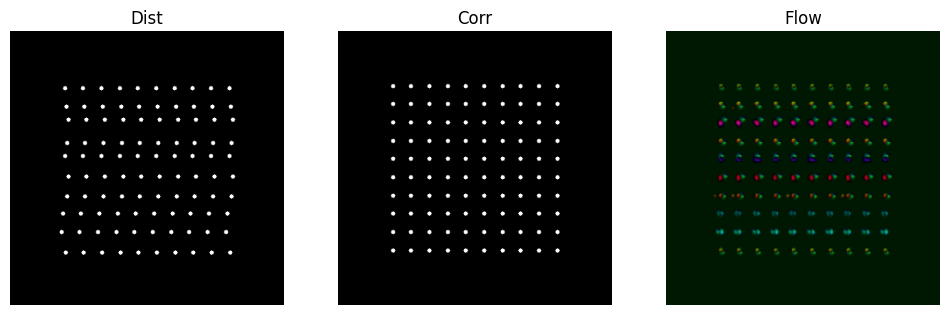

Train 2/100: 100%|██████████| 38/38 [10:44<00:00, 16.95s/it]


Ep2 avg_train_loss=0.0904
Ep2 avg_val_mse=0.0000


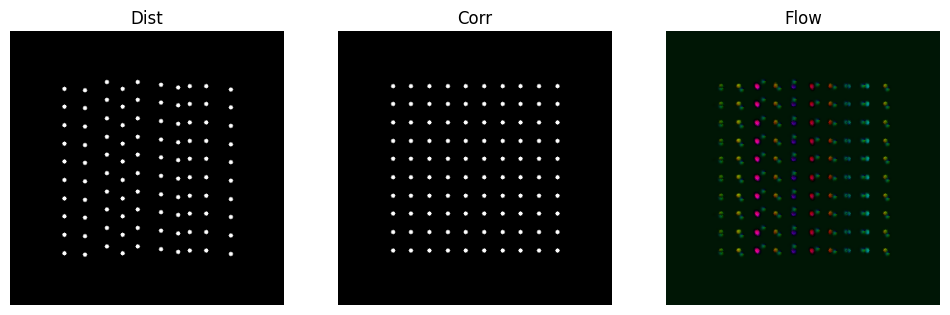

Train 3/100:   8%|▊         | 3/38 [01:15<14:37, 25.08s/it]


KeyboardInterrupt: 

In [52]:
if __name__=='__main__':
    model = train_flow_model(
        'data/Cristal_Miss/distorted_train/npy', 'data/Cristal_Miss/distorted_val/npy',
        'data/originals/uniform_points.npy', grid_size=(10,10),
        epochs=100, batch_size=4
    )
    torch.save(model.state_dict(), 'flow_centroid_alignment.pth')

A continuación definimos una función para aplicar la red neuronal sobre nuestro conjunto de prueba, en cada caso, de tal manera que al ejecutarlo, introduciendo el modelo de red entrenado, la ruta de las imágenes a resolver y la ruta de los resultados, podemos ejecutar esta función para que devuelva la imagen corregida junto con una figura comparativa donde se muestra la imagen distorsionada, la corregida y el flujo obtenido, es decir, el mapa de corrección

In [53]:
import numpy as np
import torch
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

def apply_and_save(model_class, model_path, input_npy_dir, output_npy_dir, output_fig_dir=None, height=400, width=400):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    transformer = SpatialTransformer(height, width).to(device)

    inp_dir = Path(input_npy_dir)
    out_dir = Path(output_npy_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    if output_fig_dir:
        only_corr_dir = Path(output_fig_dir) / "only_corr"
        triple_dir = Path(output_fig_dir) / "triple"
        only_corr_dir.mkdir(parents=True, exist_ok=True)
        triple_dir.mkdir(parents=True, exist_ok=True)

    for npy_file in sorted(inp_dir.glob('*.npy')):
        data = np.load(npy_file).astype(np.float32)
        x = torch.from_numpy(data).unsqueeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            flow = model(x)
            x_corr = transformer(x, flow)

        corr = x_corr.squeeze().cpu().numpy()
        np.save(out_dir / npy_file.name, corr)

        if output_fig_dir:
            dist_img = np.clip(data * 255.0, 0, 255).astype(np.uint8)
            corr_img = np.clip(corr * 255.0, 0, 255).astype(np.uint8)
            flow_rgb = flow_to_rgb(flow[0].detach().cpu())

            cv2.imwrite(str(only_corr_dir / f"{npy_file.stem}_only_corr.png"), corr_img)

            fig, ax = plt.subplots(1, 3, figsize=(14, 5))
            ax[0].imshow(dist_img, cmap='gray')
            ax[0].set_title('Imagen distorsionada')
            ax[0].axis('off')

            ax[1].imshow(corr_img, cmap='gray')
            ax[1].set_title('Imagen corregida (Red neuronal)')
            ax[1].axis('off')

            ax[2].imshow(dist_img, cmap='gray')
            ax[2].imshow(flow_rgb, alpha=0.7)
            ax[2].set_title('Flujo RGB (Red neuronal)')
            ax[2].axis('off')

            fig.savefig(triple_dir / f"{npy_file.stem}_triple.png", bbox_inches='tight', dpi=100)
            plt.close(fig)


Ejecutamos la función, en este caso para la distorsión de rejilla

In [54]:
apply_and_save(
     model_class=UNetFlow, # Modelo de red
     model_path='flow_centroid_alignment.pth', # Ruta para los pesos de la red ya entrenada
     input_npy_dir='/content/data/Cristal_Miss/Pruebas/npy', # Ruta de las imágenes prueba
     output_npy_dir='/content/data/Cristal_Miss/Pruebas/Corrected', # Ruta donde se guardan las imágenes corregidas
     output_fig_dir='//content/data/Cristal_Miss/Pruebas/Figuras' # Ruta donde se guardan las figuras comparativas
)

Dado que el objetivo es comparar los resultados obtenidos con aquellos obtenidos por los algoritmos tradicionales, la celda siguiente coge las imágenes corregidas y las compara con la original, para obtener los valores de las métricas de corrección, al igual que con los métodos tradicionales, y guarda estos resultados junto con los de antes.

In [55]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

base_path = Path("/content/data/Cristal_Miss/Pruebas")

# Ruta de imágenes corregidas por red neuronal
nn_img_dir = base_path / "Figuras" / "only_corr"

img_ref = imread("/content/data/originals/uniform_points.png")

# Cargamos de nuevo CSV existente con las métricas obtenidas con LK y GF
df = pd.read_csv(base_path / "metricas_correccion.csv")

# Inicializamos las  listas para las nuevas métricas

l1_nn_list = []
l2_nn_list = []
ssim_nn_list = []

for i, filename in enumerate(df["filename"]):

    # Derivamos el nombre de imagen corregida por red neuronal

    base_name = Path(filename).stem.replace("_distorsion", "")
    nn_file = nn_img_dir / f"{base_name}_only_corr.png"

    if not nn_file.exists():
        print(f"⚠️ No se encontró la imagen {nn_file.name}, se rellenan NaN.")
        l1_nn_list.append(np.nan)
        l2_nn_list.append(np.nan)
        ssim_nn_list.append(np.nan)
        continue

    # Leemos la imagen corregida por la red neuronal

    img_nn = imread(nn_file)
    if img_nn.ndim == 3:
        if img_nn.shape[2] == 4:
            img_nn = img_nn[:, :, :3]  # Eliminamos el canal alfa si existe
        img_nn = rgb2gray(img_nn)
    img_nn = img_nn.astype(np.float32)
    img_nn /= 255.0 if img_nn.max() > 1 else 1

    # Redimensionamos si es necesario

    if img_nn.shape != img_ref.shape:
        img_nn = resize(img_nn, img_ref.shape, anti_aliasing=True)

    # Calculamos las métricas

    l1, ssim_val, l2 = compute_l1_ssim(img_nn, img_ref)
    l1_nn_list.append(l1)
    l2_nn_list.append(l2)
    ssim_nn_list.append(ssim_val)

    print(f"🧠 NN: {nn_file.name} → L1 = {l1:.5f}, SSIM = {ssim_val:.5f}, L2 = {l2:.5f}")

# Añadimos columnas al DataFrame
df["L1_NN"] = l1_nn_list
df["L2_NN"] = l2_nn_list
df["SSIM_NN"] = ssim_nn_list

# Una vez actualizado, guardamos el CSV.
df.to_csv(base_path / "metricas_correccion.csv", index=False)

print("\n✅ Métricas de red neuronal añadidas al CSV.")


🧠 NN: distorted_image_000_only_corr.png → L1 = 0.00473, SSIM = 0.99996, L2 = 0.05161
🧠 NN: distorted_image_001_only_corr.png → L1 = 0.00434, SSIM = 0.99997, L2 = 0.03814
🧠 NN: distorted_image_002_only_corr.png → L1 = 0.00429, SSIM = 0.99997, L2 = 0.04905
🧠 NN: distorted_image_003_only_corr.png → L1 = 0.00735, SSIM = 0.99995, L2 = 0.18993
🧠 NN: distorted_image_004_only_corr.png → L1 = 0.00358, SSIM = 0.99997, L2 = 0.02661
🧠 NN: distorted_image_005_only_corr.png → L1 = 0.00360, SSIM = 0.99997, L2 = 0.02513
🧠 NN: distorted_image_006_only_corr.png → L1 = 0.00368, SSIM = 0.99998, L2 = 0.01811
🧠 NN: distorted_image_007_only_corr.png → L1 = 0.00491, SSIM = 0.99996, L2 = 0.05885
🧠 NN: distorted_image_008_only_corr.png → L1 = 0.00484, SSIM = 0.99998, L2 = 0.03290
🧠 NN: distorted_image_009_only_corr.png → L1 = 0.00292, SSIM = 0.99997, L2 = 0.01611
🧠 NN: distorted_image_010_only_corr.png → L1 = 0.00458, SSIM = 0.99997, L2 = 0.03723
🧠 NN: distorted_image_011_only_corr.png → L1 = 0.00379, SSIM = 0.

## 5.3 Compresión en los bordes

Código análogo al presentado para la distorsión de rejilla, con los cambios necesarios para resolver la distorsión de compresión/alejamiento en los bordes

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset-
class BorderCompressionDataset(torch.utils.data.Dataset):
    def __init__(self, npy_dir, original_npy_path):
        self.npy_files = sorted(Path(npy_dir).glob('*.npy'))
        self.original = np.load(original_npy_path).astype(np.float32)

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        distorted = np.load(self.npy_files[idx]).astype(np.float32)
        x = torch.from_numpy(distorted).unsqueeze(0)
        y = torch.from_numpy(self.original).unsqueeze(0)
        return x, y

# Modelo
class UNetFlowBorder(nn.Module):
    def __init__(self, in_ch=1, wf=32, depth=4):
        super().__init__()
        self.downs, self.ups = nn.ModuleList(), nn.ModuleList()
        for i in range(depth):
            c_in = in_ch if i==0 else wf*(2**(i-1))
            c_out = wf*(2**i)
            self.downs.append(nn.Sequential(
                nn.Conv2d(c_in, c_out,3,padding=1), nn.ReLU(),
                nn.Conv2d(c_out, c_out,3,padding=1), nn.ReLU()))
        self.bottleneck = nn.Sequential(
            nn.Conv2d(wf*(2**(depth-1)), wf*(2**depth),3,padding=1), nn.ReLU(),
            nn.Conv2d(wf*(2**depth), wf*(2**depth),3,padding=1), nn.ReLU())
        for i in range(depth):
            c_in = wf*(2**(depth-i))
            c_out = wf*(2**(depth-i-1))
            self.ups.append(nn.ConvTranspose2d(c_in, c_out,2,stride=2))
            self.ups.append(nn.Sequential(
                nn.Conv2d(c_out*2, c_out,3,padding=1), nn.ReLU(),
                nn.Conv2d(c_out, c_out,3,padding=1), nn.ReLU()))
        self.flow_head = nn.Conv2d(wf,2,3,padding=1)

    def forward(self,x):
        feats=[]; out=x
        for conv in self.downs:
            out=conv(out); feats.append(out); out=F.max_pool2d(out,2)
        out=self.bottleneck(out)
        for i in range(0,len(self.ups),2):
            out=self.ups[i](out)
            enc=feats[-(i//2+1)]
            out=torch.cat([out,enc],dim=1)
            out=self.ups[i+1](out)
        return torch.tanh(self.flow_head(out))*0.1

# Spatial Transformer
class SpatialTransformer(nn.Module):
    def __init__(self, height, width):
        super().__init__()
        grid_y, grid_x = torch.meshgrid(
            torch.linspace(-1,1,height), torch.linspace(-1,1,width), indexing='ij'
        )
        self.register_buffer('base_grid', torch.stack((grid_x, grid_y), dim=2))

    def forward(self, img, flow):
        grid = self.base_grid.unsqueeze(0) + flow.permute(0,2,3,1)
        return F.grid_sample(img, grid, align_corners=True, padding_mode='border')

# Máscara para evitar mover el centro
def center_mask(H, W, r_frac=0.2):
    Y, X = torch.meshgrid(torch.linspace(-1,1,H), torch.linspace(-1,1,W), indexing='ij')
    R = torch.sqrt(X**2 + Y**2)
    mask = (R > r_frac).float()
    return mask[None,None]

# Regularización del flujo
def flow_smoothness_loss(flow):
    dx = torch.abs(flow[:,:,:,1:] - flow[:,:,:,:-1])
    dy = torch.abs(flow[:,:,1:,:] - flow[:,:,:-1,:])
    return dx.mean() + dy.mean()

# Visualización flujo RGB
def flow_to_rgb(flow):
    dx, dy = flow[0].cpu().numpy(), flow[1].cpu().numpy()
    mag, ang = cv2.cartToPolar(dx, dy, angleInDegrees=True)
    hsv = np.zeros((mag.shape[0], mag.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = ang/2
    hsv[..., 1] = 255
    hsv[..., 2] = np.clip(mag*255/np.max(mag), 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# Bucle de entramiento
def train_border_model(
    train_dir, val_dir, original_npy_path,
    epochs=30, batch_size=4, height=400, width=400,
    lambda_center=10.0, lambda_smooth=1.0,
    checkpoint_path='flow_centroid_compression.pth'
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_ds = BorderCompressionDataset(train_dir, original_npy_path)
    val_ds   = BorderCompressionDataset(val_dir,   original_npy_path)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=batch_size)

    model = UNetFlowBorder().to(device)
    # Cargamos el checkpoint si existe
    if Path(checkpoint_path).exists():
        print(f"Cargando pesos desde {checkpoint_path}")
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))

    transformer = SpatialTransformer(height, width).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    center_msk = center_mask(height, width).to(device)

    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for x,y in tqdm(train_loader, desc=f"Train {ep+1}/{epochs}"):
            x,y = x.to(device), y.to(device)
            flow = model(x)
            xw = transformer(x, flow)
            loss_rec    = F.mse_loss(xw, y)
            loss_center = ((flow * center_msk)**2).mean()
            loss_smooth = flow_smoothness_loss(flow)
            loss = loss_rec + lambda_center*loss_center + lambda_smooth*loss_smooth
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item()
        print(f"Ep{ep+1} train_loss={total_loss/len(train_loader):.4f}")

        model.eval(); val_loss=0.0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                xw = transformer(x, model(x))
                val_loss += F.mse_loss(xw, y).item()
        print(f"Ep{ep+1} val_loss={val_loss/len(val_loader):.4f}")

        # Visualización de resultados al final de cada época

        idx = np.random.randint(len(val_ds))
        xv,_ = val_ds[idx]
        xv = xv.unsqueeze(0).to(device)
        flow_vis = model(xv)[0].detach()
        xw = transformer(xv, flow_vis.unsqueeze(0)).detach()
        d = xv[0,0].cpu().numpy()
        c = xw[0,0].cpu().numpy()
        f_rgb = flow_to_rgb(flow_vis)
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(d, cmap='gray'); plt.title('Dist'); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(c, cmap='gray'); plt.title('Corr'); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(f_rgb);       plt.title('Flow'); plt.axis('off')
        plt.show()

    torch.save(model.state_dict(), checkpoint_path)
    return model



Una vez ejecutada la celda de arriba, la siguiente celda realiza el entrenamiento al introducir las rutas de los conjuntos de entrenamiento, validación y la imagen original. La celda siguiente realiza el entranamiento según un número de épocas, y el tamaño de los batches, parámetros que se pueden modificar. En el caso de que se proporcionen los pesos de la red ya entrenada (flow_centroid_compression.pth), no es necesario ejecutar la celda siguiente.

Cargando pesos desde flow_centroid_compression.pth


Train 1/100: 100%|██████████| 38/38 [10:44<00:00, 16.96s/it]


Ep1 train_loss=0.0007
Ep1 val_loss=0.0000


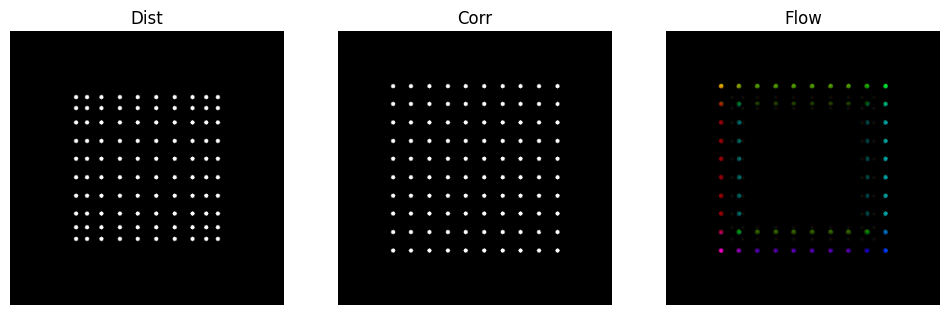

Train 2/100:  21%|██        | 8/38 [02:31<09:28, 18.95s/it]


KeyboardInterrupt: 

In [57]:
if __name__ == '__main__':
    model = train_border_model(
        train_dir='data/Compression/distorted_train/npy',
        val_dir='data/Compression/distorted_val/npy',
        original_npy_path='data/originals/uniform_points.npy',
        epochs=100,
        batch_size=4,
        height=400,
        width=400,
        checkpoint_path='flow_centroid_compression.pth'  # aquí se usa el nombre coherente
    )
    torch.save(model.state_dict(), 'flow_centroid_compression.pth')

Utilizamos la función apply_and_save() modificando el modelo utilizado y las rutas para aplicar el modelo a las imágenes distorsionadas correctas y guardar los resultado en las carpetas deseadas.

In [58]:
apply_and_save(
     model_class=UNetFlowBorder,
     model_path='flow_centroid_compression.pth',
     input_npy_dir='/content/data/Compression/Prueba/npy',
     output_npy_dir='/content/data/Compression/Prueba/Corrected',
     output_fig_dir='//content/data/Compression/Prueba/Figuras'
)

Dado que el objetivo es comparar los resultados obtenidos con aquellos obtenidos por los algoritmos tradicionales, la celda siguiente coge las imágenes corregidas y las compara con la original, para obtener los valores de las métricas de corrección, al igual que con los métodos tradicionales, y guarda estos resultados junto con los de antes.

In [59]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

base_path = Path("/content/data/Compression/Prueba")


nn_img_dir = base_path / "Figuras" / "only_corr"

img_ref = imread("/content/data/originals/uniform_points.png")


df = pd.read_csv(base_path / "metricas_correccion.csv")


l1_nn_list = []
l2_nn_list = []
ssim_nn_list = []

for i, filename in enumerate(df["filename"]):

    base_name = Path(filename).stem.replace("_distorsion", "")
    nn_file = nn_img_dir / f"{base_name}_only_corr.png"

    if not nn_file.exists():
        print(f"⚠️ No se encontró la imagen {nn_file.name}, se rellenan NaN.")
        l1_nn_list.append(np.nan)
        l2_nn_list.append(np.nan)
        ssim_nn_list.append(np.nan)
        continue


    img_nn = imread(nn_file)
    if img_nn.ndim == 3:
        if img_nn.shape[2] == 4:
            img_nn = img_nn[:, :, :3]
        img_nn = rgb2gray(img_nn)
    img_nn = img_nn.astype(np.float32)
    img_nn /= 255.0 if img_nn.max() > 1 else 1


    if img_nn.shape != img_ref.shape:
        img_nn = resize(img_nn, img_ref.shape, anti_aliasing=True)


    l1, ssim_val, l2 = compute_l1_ssim(img_nn, img_ref)
    l1_nn_list.append(l1)
    l2_nn_list.append(l2)
    ssim_nn_list.append(ssim_val)

    print(f"🧠 NN: {nn_file.name} → L1 = {l1:.5f}, SSIM = {ssim_val:.5f}, L2 = {l2:.5f}")


df["L1_NN"] = l1_nn_list
df["L2_NN"] = l2_nn_list
df["SSIM_NN"] = ssim_nn_list


df.to_csv(base_path / "metricas_correccion.csv", index=False)

print("\n✅ Métricas de red neuronal añadidas al CSV.")


🧠 NN: distorted_image_000_only_corr.png → L1 = 0.02349, SSIM = 0.99981, L2 = 0.22055
🧠 NN: distorted_image_001_only_corr.png → L1 = 0.03718, SSIM = 0.99881, L2 = 0.74754
🧠 NN: distorted_image_002_only_corr.png → L1 = 0.02167, SSIM = 0.99988, L2 = 0.13109
🧠 NN: distorted_image_003_only_corr.png → L1 = 0.02623, SSIM = 0.99850, L2 = 0.20949
🧠 NN: distorted_image_004_only_corr.png → L1 = 0.02714, SSIM = 0.99863, L2 = 0.22863
🧠 NN: distorted_image_005_only_corr.png → L1 = 0.04184, SSIM = 0.99963, L2 = 0.82663
🧠 NN: distorted_image_006_only_corr.png → L1 = 0.03788, SSIM = 0.99692, L2 = 1.94319
🧠 NN: distorted_image_007_only_corr.png → L1 = 0.02782, SSIM = 0.99974, L2 = 0.33026
🧠 NN: distorted_image_008_only_corr.png → L1 = 0.03489, SSIM = 0.99756, L2 = 0.54714
🧠 NN: distorted_image_009_only_corr.png → L1 = 0.07276, SSIM = 0.99726, L2 = 8.13889
🧠 NN: distorted_image_010_only_corr.png → L1 = 0.02683, SSIM = 0.99759, L2 = 0.36111
🧠 NN: distorted_image_011_only_corr.png → L1 = 0.02937, SSIM = 0.

## 5.4 Ruido y pérdida de brillo en los bordes

Esta celda vuelve a generar todo lo necesario para entrenar la red neuronal para la distorsion de ruido y atenuación en lor bordes. El código es distinto a los dos presentados antes, principalmente porque además de predecir los flujos, esta red también obtienes los mapas de corrección de ganancia para lidiar con la atenuación fotométrica

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

# Dataset
class EdgeIntensityDataset(Dataset):
    def __init__(self, npy_dir, original_npy_path):
        self.npy_files = sorted(Path(npy_dir).glob("*.npy"))
        self.original = np.load(original_npy_path).astype(np.float32)  # [H,W]

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        distorted = np.load(self.npy_files[idx]).astype(np.float32)  # [H,W]
        x = torch.from_numpy(distorted).unsqueeze(0)                 # [1,H,W]
        y = torch.from_numpy(self.original).unsqueeze(0)             # [1,H,W]
        return x, y

#  Spatial transformer + aplicación de α
class CorrectionModule(nn.Module):
    def __init__(self, height, width):
        super().__init__()
        ys = torch.linspace(-1,1,height)
        xs = torch.linspace(-1,1,width)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
        self.register_buffer('base_grid', torch.stack((grid_x, grid_y), dim=2))  # [H,W,2]

    def forward(self, img, flow3):
        B,_,H,W = img.shape
        dx = flow3[:,0:1]    # [B,1,H,W]
        dy = flow3[:,1:2]
        alpha = flow3[:,2:3] # [B,1,H,W], ya ≥1

        # construimos sampling_grid inverso

        grid = self.base_grid.unsqueeze(0).expand(B,-1,-1,-1)       # [B,H,W,2]
        disp = torch.cat((dx, dy), dim=1).permute(0,2,3,1)            # [B,H,W,2]
        sampling_grid = grid - disp                                 # inverso

        # Warp inverso

        warped = F.grid_sample(img, sampling_grid,
                               mode='bilinear',
                               padding_mode='zeros',
                               align_corners=True)

        corrected = warped * alpha
        return corrected.clamp(0.0, 1.0)

# U-Net que predice tres canales

class UNet3(nn.Module):
    def __init__(self, in_ch=1, wf=32, depth=4, scale_flow=0.1):
        super().__init__()
        self.scale_flow = scale_flow
        self.downs, self.ups = nn.ModuleList(), nn.ModuleList()
        for i in range(depth):
            c_in = in_ch if i==0 else wf*(2**(i-1))
            c_out = wf*(2**i)
            self.downs.append(nn.Sequential(
                nn.Conv2d(c_in, c_out, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, 3, padding=1), nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(
            nn.Conv2d(wf*(2**(depth-1)), wf*(2**depth), 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(wf*(2**depth), wf*(2**depth), 3, padding=1), nn.ReLU(inplace=True)
        )
        for i in range(depth):
            c_in = wf*(2**(depth-i))
            c_out = wf*(2**(depth-i-1))
            self.ups.append(nn.ConvTranspose2d(c_in, c_out, 2, stride=2))
            self.ups.append(nn.Sequential(
                nn.Conv2d(c_out*2, c_out, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, 3, padding=1), nn.ReLU(inplace=True)
            ))
        self.head_flow = nn.Conv2d(wf, 2, kernel_size=1)
        self.head_gain = nn.Conv2d(wf, 1, kernel_size=1)

    def forward(self, x):
        feats, out = [], x
        for down in self.downs:
            out = down(out); feats.append(out)
            out = F.max_pool2d(out, 2)
        out = self.bottleneck(out)
        for i in range(0, len(self.ups), 2):
            out = self.ups[i](out)
            skip = feats[-(i//2+1)]
            out = torch.cat([out, skip], dim=1)
            out = self.ups[i+1](out)
        flow = torch.tanh(self.head_flow(out)) * self.scale_flow  # [-scale, +scale]
        gain = F.softplus(self.head_gain(out)) + 1.0             # α ≥ 1
        return torch.cat([flow, gain], dim=1)                    # [B,3,H,W]

# Bucle de entramiento
def train_edge_intensity_model(
    train_dir, val_dir, original_path,
    epochs=60, batch_size=4, lr=1e-3,
    height=400, width=400,
    checkpoint_path="flow_centroid_border_aberration.pth"
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_ds = EdgeIntensityDataset(train_dir, original_path)
    val_ds   = EdgeIntensityDataset(val_dir, original_path)
    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                              shuffle=False, num_workers=2, pin_memory=True)

    model = UNet3().to(device)
    corr_mod = CorrectionModule(height, width).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    # Cargamos checkpoint si existe

    if Path(checkpoint_path).exists():
        print(f"Cargando pesos desde {checkpoint_path}")
        state = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state)

    for ep in range(1, epochs+1):
        model.train(); total=0.0
        for x,y in tqdm(train_loader, desc=f"Train {ep}/{epochs}"):
            x,y = x.to(device), y.to(device)
            flow3 = model(x)
            y_pred = corr_mod(x, flow3)
            loss = F.mse_loss(y_pred, y)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        print(f"[{ep}] train MSE={total/len(train_loader):.6f}")

        # Validación
        model.eval(); tot=0.0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                f3 = model(x)
                tot += F.mse_loss(corr_mod(x, f3), y).item()
            print(f"[{ep}] val   MSE={tot/len(val_loader):.6f}")

            # Visualización al final de cada época de la imagen corregida junto con los mapas de corrección

            xv,yv = random.choice(val_ds)
            xv = xv.unsqueeze(0).to(device)
            yv = yv.unsqueeze(0).to(device)
            f3 = model(xv)
            yp = corr_mod(xv, f3)
            dxdy = f3[0, :2]                 # [2,H,W]
            alpha = f3[0, 2].cpu().numpy()   # [H,W]

            fig, axs = plt.subplots(1,5,figsize=(15,4))
            for ax in axs:
                ax.set_aspect('equal')
            axs[0].imshow(xv[0,0].cpu(), cmap='gray', vmin=0, vmax=1)
            axs[0].set_title("Distorsionada"); axs[0].axis('off')
            axs[1].imshow(yp[0,0].cpu(), cmap='gray', vmin=0, vmax=1)
            axs[1].set_title("Corregida");    axs[1].axis('off')
            axs[2].imshow(yv[0,0].cpu(), cmap='gray', vmin=0, vmax=1)
            axs[2].set_title("Original");     axs[2].axis('off')
            axs[3].imshow(flow_to_rgb(dxdy)); axs[3].set_title("Flow"); axs[3].axis('off')
            im = axs[4].imshow(alpha, cmap='viridis', vmin=1, vmax=2)
            axs[4].set_title("Ganancia α");   axs[4].axis('off')
            cbar = fig.colorbar(im, ax=axs[4], fraction=0.046, pad=0.04)
            cbar.set_label("α")
            plt.tight_layout()
            plt.show()

        # Guardamos checkpoint tras cada epoch

        torch.save(model.state_dict(), checkpoint_path)

    return model



Una vez ejecutada la celda de arriba, la siguiente celda realiza el entrenamiento al introducir las rutas de los conjuntos de entrenamiento, validación y la imagen original. La celda siguiente realiza el entrenamiento según un número de épocas, y el tamaño de los batches, parámetros que se puede modificar. En el caso de que se proporcionen los pesos de la red ya entrenada (flow_centroid_border_aberration.pth), no es necesario ejecutar la celda siguiente.

Cargando pesos desde flow_centroid_border_aberration.pth


Train 1/60: 100%|██████████| 38/38 [10:44<00:00, 16.96s/it]

[1] train MSE=0.001520


[1] val   MSE=0.001245


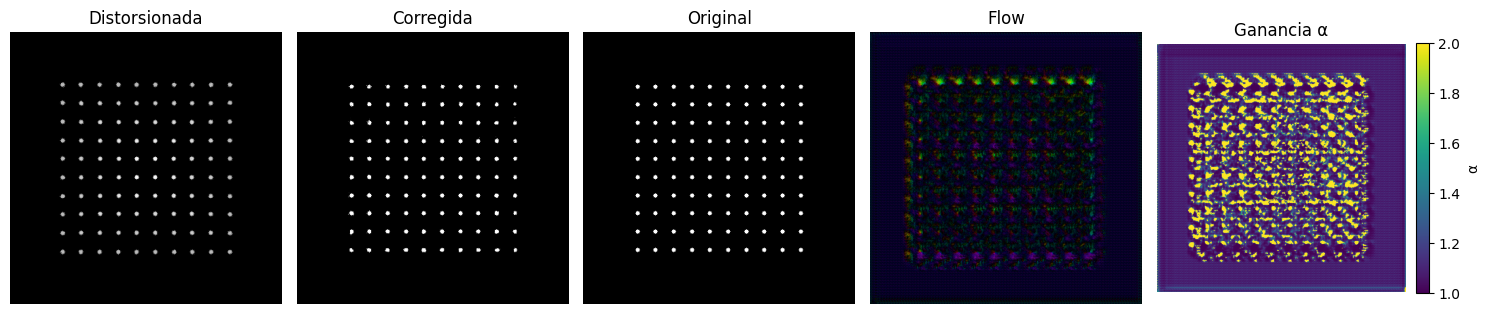

Train 2/60:  16%|█▌        | 6/38 [02:07<11:22, 21.31s/it]


KeyboardInterrupt: 

In [61]:
if __name__ == "__main__":
    model = train_edge_intensity_model(
        train_dir="data/Border_Noise/distorted_train/npy",
        val_dir="data/Border_Noise/distorted_val/npy",
        original_path="data/originals/uniform_points.npy",
        epochs=60,
        batch_size=4
    )
    torch.save(model.state_dict(), 'flow_centroid_border_aberration.pth')

Dado que la red neuronal devuelve el mapa de corrección de flujo óptico junto con el mapa de ganancia, la celda siguiente modifica la función apply_and_save() para que sea compatible con esta nueva red

In [62]:
def apply_and_save2(model_class, model_path, input_npy_dir, output_npy_dir,
                    output_fig_dir=None, height=400, width=400):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    transformer = CorrectionModule(height, width).to(device)

    inp_dir = Path(input_npy_dir)
    out_dir = Path(output_npy_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    if output_fig_dir:
        only_corr_dir = Path(output_fig_dir) / "only_corr"
        triple_dir = Path(output_fig_dir) / "triple"
        only_corr_dir.mkdir(parents=True, exist_ok=True)
        triple_dir.mkdir(parents=True, exist_ok=True)

    for npy_file in sorted(inp_dir.glob("*.npy")):
        data = np.load(npy_file).astype(np.float32)
        x = torch.from_numpy(data).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]

        with torch.no_grad():
            flow3 = model(x)                      # [1,3,H,W]
            x_corr = transformer(x, flow3)        # [1,1,H,W]

        corr = x_corr.squeeze().cpu().numpy()     # (H,W)
        np.save(out_dir / npy_file.name, corr)

        if output_fig_dir:
            corr_img = np.clip(corr * 255.0, 0, 255).astype(np.uint8)
            dist_img = np.clip(data * 255.0, 0, 255).astype(np.uint8)

            dxdy = flow3[0, :2].detach().cpu()     # [2,H,W]
            flow_rgb = flow_to_rgb(dxdy)

            cv2.imwrite(str(only_corr_dir / f"{npy_file.stem}_only_corr.png"), corr_img)

            fig, ax = plt.subplots(1, 3, figsize=(14, 5))
            ax[0].imshow(dist_img, cmap='gray')
            ax[0].set_title("Imagen distorsionada")
            ax[0].axis("off")

            ax[1].imshow(corr_img, cmap='gray')
            ax[1].set_title("Imagen corregida (Red neuronal)")
            ax[1].axis("off")

            ax[2].imshow(dist_img, cmap='gray')
            ax[2].imshow(flow_rgb, alpha=0.7)
            ax[2].set_title("Flujo sobre imagen distorsionada")
            ax[2].axis("off")

            fig.savefig(triple_dir / f"{npy_file.stem}_triple.png", bbox_inches="tight", dpi=100)
            plt.close(fig)




Aplicamos la función modificada de la misma manera que para las redes neuronales

In [63]:
apply_and_save2(
     model_class=UNet3,
     model_path='flow_centroid_border_aberration.pth',
     input_npy_dir='/content/data/Border_Noise/Prueba/npy',
     output_npy_dir='/content/data/Border_Noise/Prueba/Corrected',
     output_fig_dir='/content/data/Border_Noise/Prueba/Figuras'
)

Dado que el objetivo es comparar los resultados obtenidos con aquellos obtenidos por los algoritmos tradicionales, la celda siguiente coge las imágenes corregidas y las compara con la original, para obtener los valores de las métricas de corrección, al igual que con los métodos tradicionales, y guarda estos resultados junto con los de antes.

In [64]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

base_path = Path("/content/data/Border_Noise/Prueba")

nn_img_dir = base_path / "Figuras" / "only_corr"

img_ref = imread("/content/data/originals/uniform_points.png")

df = pd.read_csv(base_path / "metricas_correccion.csv")

l1_nn_list = []
l2_nn_list = []
ssim_nn_list = []

for i, filename in enumerate(df["filename"]):

    base_name = Path(filename).stem.replace("_distorsion", "")
    nn_file = nn_img_dir / f"{base_name}_only_corr.png"

    if not nn_file.exists():
        print(f"⚠️ No se encontró la imagen {nn_file.name}, se rellenan NaN.")
        l1_nn_list.append(np.nan)
        l2_nn_list.append(np.nan)
        ssim_nn_list.append(np.nan)
        continue


    img_nn = imread(nn_file)
    if img_nn.ndim == 3:
        if img_nn.shape[2] == 4:
            img_nn = img_nn[:, :, :3]
        img_nn = rgb2gray(img_nn)
    img_nn = img_nn.astype(np.float32)
    img_nn /= 255.0 if img_nn.max() > 1 else 1


    if img_nn.shape != img_ref.shape:
        img_nn = resize(img_nn, img_ref.shape, anti_aliasing=True)


    l1, ssim_val, l2 = compute_l1_ssim(img_nn, img_ref)
    l1_nn_list.append(l1)
    l2_nn_list.append(l2)
    ssim_nn_list.append(ssim_val)

    print(f"🧠 NN: {nn_file.name} → L1 = {l1:.5f}, SSIM = {ssim_val:.5f}, L2 = {l2:.5f}")


df["L1_NN"] = l1_nn_list
df["L2_NN"] = l2_nn_list
df["SSIM_NN"] = ssim_nn_list


df.to_csv(base_path / "metricas_correccion.csv", index=False)

print("\n✅ Métricas de red neuronal añadidas al CSV.")

🧠 NN: distorted_image_000_only_corr.png → L1 = 0.48429, SSIM = 0.97594, L2 = 87.56805
🧠 NN: distorted_image_001_only_corr.png → L1 = 0.21026, SSIM = 0.99255, L2 = 35.36400
🧠 NN: distorted_image_002_only_corr.png → L1 = 0.32801, SSIM = 0.99044, L2 = 59.32850
🧠 NN: distorted_image_003_only_corr.png → L1 = 0.75909, SSIM = 0.97399, L2 = 164.54079
🧠 NN: distorted_image_004_only_corr.png → L1 = 0.54433, SSIM = 0.98400, L2 = 113.84390
🧠 NN: distorted_image_005_only_corr.png → L1 = 0.25152, SSIM = 0.99299, L2 = 44.98809
🧠 NN: distorted_image_006_only_corr.png → L1 = 0.40051, SSIM = 0.98781, L2 = 80.94991
🧠 NN: distorted_image_007_only_corr.png → L1 = 0.66006, SSIM = 0.97992, L2 = 136.36253
🧠 NN: distorted_image_008_only_corr.png → L1 = 0.57699, SSIM = 0.98367, L2 = 115.79401
🧠 NN: distorted_image_009_only_corr.png → L1 = 1.53469, SSIM = 0.95388, L2 = 349.51163
🧠 NN: distorted_image_010_only_corr.png → L1 = 0.22824, SSIM = 0.98682, L2 = 31.13186
🧠 NN: distorted_image_011_only_corr.png → L1 = 0.

## 5.5 Combinación de distorsiones

Código análogo al presentado en el apartado anterior, modificado para funcionar con imágenes distorsionadas por una combinación de las distorsiones ya estudiadas

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

# Dataset para distorsiones combinadas
class CombinedDistortionsDataset(Dataset):
    def __init__(self, npy_dir, original_npy_path):
        self.npy_files = sorted(Path(npy_dir).glob("*.npy"))
        self.original = np.load(original_npy_path).astype(np.float32)

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        distorted = np.load(self.npy_files[idx]).astype(np.float32)
        x = torch.from_numpy(distorted).unsqueeze(0)
        y = torch.from_numpy(self.original).unsqueeze(0)
        return x, y

# Módulo de corrección para distorsiones combinadas
class CorrectionModuleCombined(nn.Module):
    def __init__(self, height, width):
        super().__init__()
        ys = torch.linspace(-1, 1, height)
        xs = torch.linspace(-1, 1, width)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
        self.register_buffer('base_grid', torch.stack((grid_x, grid_y), dim=2))

    def forward(self, img, flow3):
        B, _, H, W = img.shape
        dx = flow3[:, 0:1]
        dy = flow3[:, 1:2]
        alpha = flow3[:, 2:3]

        grid = self.base_grid.unsqueeze(0).expand(B, -1, -1, -1)
        disp = torch.cat((dx, dy), dim=1).permute(0, 2, 3, 1)
        sampling_grid = grid - disp

        warped = F.grid_sample(img, sampling_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
        corrected = warped * alpha
        return corrected.clamp(0.0, 1.0)

# U-Net adaptado
class UNet3_Combined(nn.Module):
    def __init__(self, in_ch=1, wf=32, depth=4, scale_flow=0.2):
        super().__init__()
        self.scale_flow = scale_flow
        self.downs, self.ups = nn.ModuleList(), nn.ModuleList()
        for i in range(depth):
            c_in = in_ch if i == 0 else wf * (2 ** (i - 1))
            c_out = wf * (2 ** i)
            self.downs.append(nn.Sequential(
                nn.Conv2d(c_in, c_out, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, 3, padding=1), nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(
            nn.Conv2d(wf * (2 ** (depth - 1)), wf * (2 ** depth), 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(wf * (2 ** depth), wf * (2 ** depth), 3, padding=1), nn.ReLU(inplace=True)
        )
        for i in range(depth):
            c_in = wf * (2 ** (depth - i))
            c_out = wf * (2 ** (depth - i - 1))
            self.ups.append(nn.ConvTranspose2d(c_in, c_out, 2, stride=2))
            self.ups.append(nn.Sequential(
                nn.Conv2d(c_out * 2, c_out, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, 3, padding=1), nn.ReLU(inplace=True)
            ))
        self.head_flow = nn.Conv2d(wf, 2, kernel_size=1)
        self.head_gain = nn.Conv2d(wf, 1, kernel_size=1)

    def forward(self, x):
        feats, out = [], x
        for down in self.downs:
            out = down(out)
            feats.append(out)
            out = F.max_pool2d(out, 2)
        out = self.bottleneck(out)
        for i in range(0, len(self.ups), 2):
            out = self.ups[i](out)
            skip = feats[-(i // 2 + 1)]
            out = torch.cat([out, skip], dim=1)
            out = self.ups[i + 1](out)
        flow = torch.tanh(self.head_flow(out)) * self.scale_flow
        gain = torch.sigmoid(self.head_gain(out)) * 2.0  # α in [0, 2]
        return torch.cat([flow, gain], dim=1)

# Función auxiliar: regularización de suavidad del flujo
def gradient_loss(f):
    dx = f[..., :, 1:] - f[..., :, :-1]
    dy = f[..., 1:, :] - f[..., :-1, :]
    return dx.abs().mean() + dy.abs().mean()

# Entrenamiento para distorsiones combinadas
def train_combined_distortions_model(
    train_dir, val_dir, original_path,
    epochs=60, batch_size=4, lr=1e-3,
    height=400, width=400,
    checkpoint_path="flow_combined_distortions.pth"
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_ds = CombinedDistortionsDataset(train_dir, original_path)
    val_ds = CombinedDistortionsDataset(val_dir, original_path)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = UNet3_Combined().to(device)
    corr_mod = CorrectionModuleCombined(height, width).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    if Path(checkpoint_path).exists():
        print(f"Cargando pesos desde {checkpoint_path}")
        state = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state)

    for ep in range(1, epochs + 1):
        model.train(); total = 0.0
        for x, y in tqdm(train_loader, desc=f"Train {ep}/{epochs}"):
            x, y = x.to(device), y.to(device)
            flow3 = model(x)
            y_pred = corr_mod(x, flow3)
            alpha = flow3[:, 2:3]

            loss_image = F.mse_loss(y_pred, y)
            loss_gain = F.mse_loss(alpha, torch.ones_like(alpha))
            loss_smooth = gradient_loss(flow3[:, :2])
            loss = loss_image + 0.1 * loss_gain + 0.01 * loss_smooth

            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        print(f"[{ep}] train loss={total / len(train_loader):.6f}")

        model.eval(); tot = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                f3 = model(x)
                yp = corr_mod(x, f3)
                tot += F.mse_loss(yp, y).item()
            print(f"[{ep}] val   MSE={tot / len(val_loader):.6f}")

            # Visualización durante el entrenamiento de los resultados

            xv,yv = random.choice(val_ds)
            xv = xv.unsqueeze(0).to(device)
            yv = yv.unsqueeze(0).to(device)
            f3 = model(xv)
            yp = corr_mod(xv, f3)
            dxdy = f3[0, :2]
            alpha = f3[0, 2].cpu().numpy()

            fig, axs = plt.subplots(1,5,figsize=(15,4))
            for ax in axs:
                ax.set_aspect('equal')
            axs[0].imshow(xv[0,0].cpu(), cmap='gray', vmin=0, vmax=1)
            axs[0].set_title("Distorsionada"); axs[0].axis('off')
            axs[1].imshow(yp[0,0].cpu(), cmap='gray', vmin=0, vmax=1)
            axs[1].set_title("Corregida");    axs[1].axis('off')
            axs[2].imshow(yv[0,0].cpu(), cmap='gray', vmin=0, vmax=1)
            axs[2].set_title("Original");     axs[2].axis('off')
            axs[3].imshow(flow_to_rgb(dxdy)); axs[3].set_title("Flow"); axs[3].axis('off')
            im = axs[4].imshow(alpha, cmap='viridis', vmin=1, vmax=2)
            axs[4].set_title("Ganancia α");   axs[4].axis('off')
            cbar = fig.colorbar(im, ax=axs[4], fraction=0.046, pad=0.04)
            cbar.set_label("α")
            plt.tight_layout()
            plt.show()

        torch.save(model.state_dict(), f"{checkpoint_dir}/flow_combined_distortions.pth")

    return model


Ya que este entrenamiento ha sido más pesado que los demás, se ha montado el dribe para guardar los pesos a medida que este se iba entrenando, por si el Colab se desconectaba del entorno.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_dir = "/content/drive/MyDrive/model_checkpoints"

from pathlib import Path
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

Una vez ejecutada la celda de arriba, la siguiente celda realiza el entrenamiento al introducir las rutas de los conjuntos de entrenamiento, validación y la imagen original. La celda siguiente realiza el entrenamiento según un número de épocas, y el tamaño de los batches, parámetros que se puede modificar. En el caso de que se proporcionen los pesos de la red ya entrenada (flow_combined_distortions.pth), no es necesario ejecutar la celda siguiente.

Cargando pesos desde flow_combined_distortions.pth


Train 1/2000: 100%|██████████| 47/47 [12:38<00:00, 16.15s/it]

[1] train loss=0.008462


[1] val   MSE=0.007916


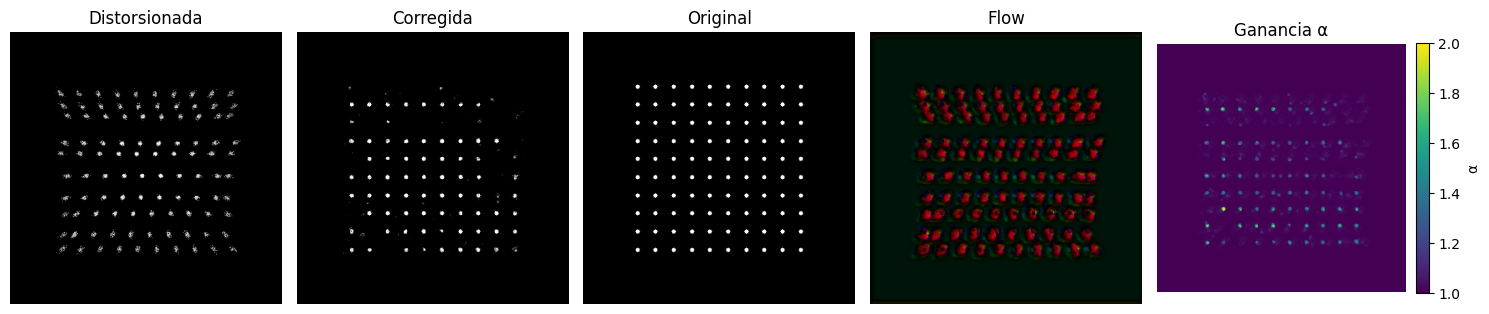

NameError: name 'checkpoint_dir' is not defined

In [66]:
if __name__ == "__main__":
    model = train_combined_distortions_model(
        train_dir="data/Combi/distorted_train/npy",
        val_dir="data/Combi/distorted_val/npy",
        original_path="data/originals/uniform_points.npy",
        epochs=2000,
        batch_size=4
    )
    torch.save(model.state_dict(), 'flow_combined_distortions.pth')

Usamos apply_and_save2() para guardar los resultados.

In [67]:
apply_and_save2(
     model_class=UNet3_Combined,
     model_path='flow_combined_distortions.pth',
     input_npy_dir='/content/data/Combi/Prueba/npy',
     output_npy_dir='/content/data/Combi/Prueba/Corrected',
     output_fig_dir='/content/data/Combi/Prueba/Figuras'
)

Dado que esta red no se ha llegado a perfeccionar del todo, no se han calculado las métricas de corrección.

# 6. Cálculo de errores entre imágenes

Para medir las diferencias entre la imagen original y las corregidas, usaremos métricas de corrección que miden las diferencias según distintos aspectos. Se ha usado L1, L2 y SSIM, todas recogidas en la función siguiente.

In [2]:
pip install scikit-image

In [3]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float, img_as_ubyte

def compute_l1_ssim(img1, img2):

    # Normalizar a float64 en [0,1] si es necesario
    if img1.dtype == np.uint8:
        img1_float = img_as_float(img1)
        img2_float = img_as_float(img2)
        img1_uint8 = img1
        img2_uint8 = img2
    elif np.issubdtype(img1.dtype, np.floating):
        # Suponemos que están en [0,1] si son float
        img1_float = np.clip(img1.astype(np.float64), 0.0, 1.0)
        img2_float = np.clip(img2.astype(np.float64), 0.0, 1.0)
        img1_uint8 = img_as_ubyte(img1_float)
        img2_uint8 = img_as_ubyte(img2_float)
    else:
        raise ValueError("Tipo de imagen no soportado: usa uint8 o float32/float64 en [0,1]")

    # L1 y L2 en uint8
    l1_error = np.mean(np.abs(img1_uint8.astype(np.float32) - img2_uint8.astype(np.float32)))
    l2_error = np.mean((img1_uint8.astype(np.float32) - img2_uint8.astype(np.float32)) ** 2)

    # SSIM en float [0,1]
    ssim_value = ssim(
        img1_float, img2_float,
        data_range=1.0,
        channel_axis=-1 if img1_float.ndim == 3 else None
    )

    return l1_error, ssim_value, l2_error


# 7. Comparación de resultados

## 7.1 Comparación de resultados para la distorsión de rejilla

Para comparar los resultados obtenidos con cada método, se han generado histogramas de las métricas de corrección obtenidas para cada método, en función del número de imágenes de prueba y los valores que se han obtenido para cada una.

✅ Histograma guardado en: data/Cristal_Miss/Pruebas/histograma_errores.png


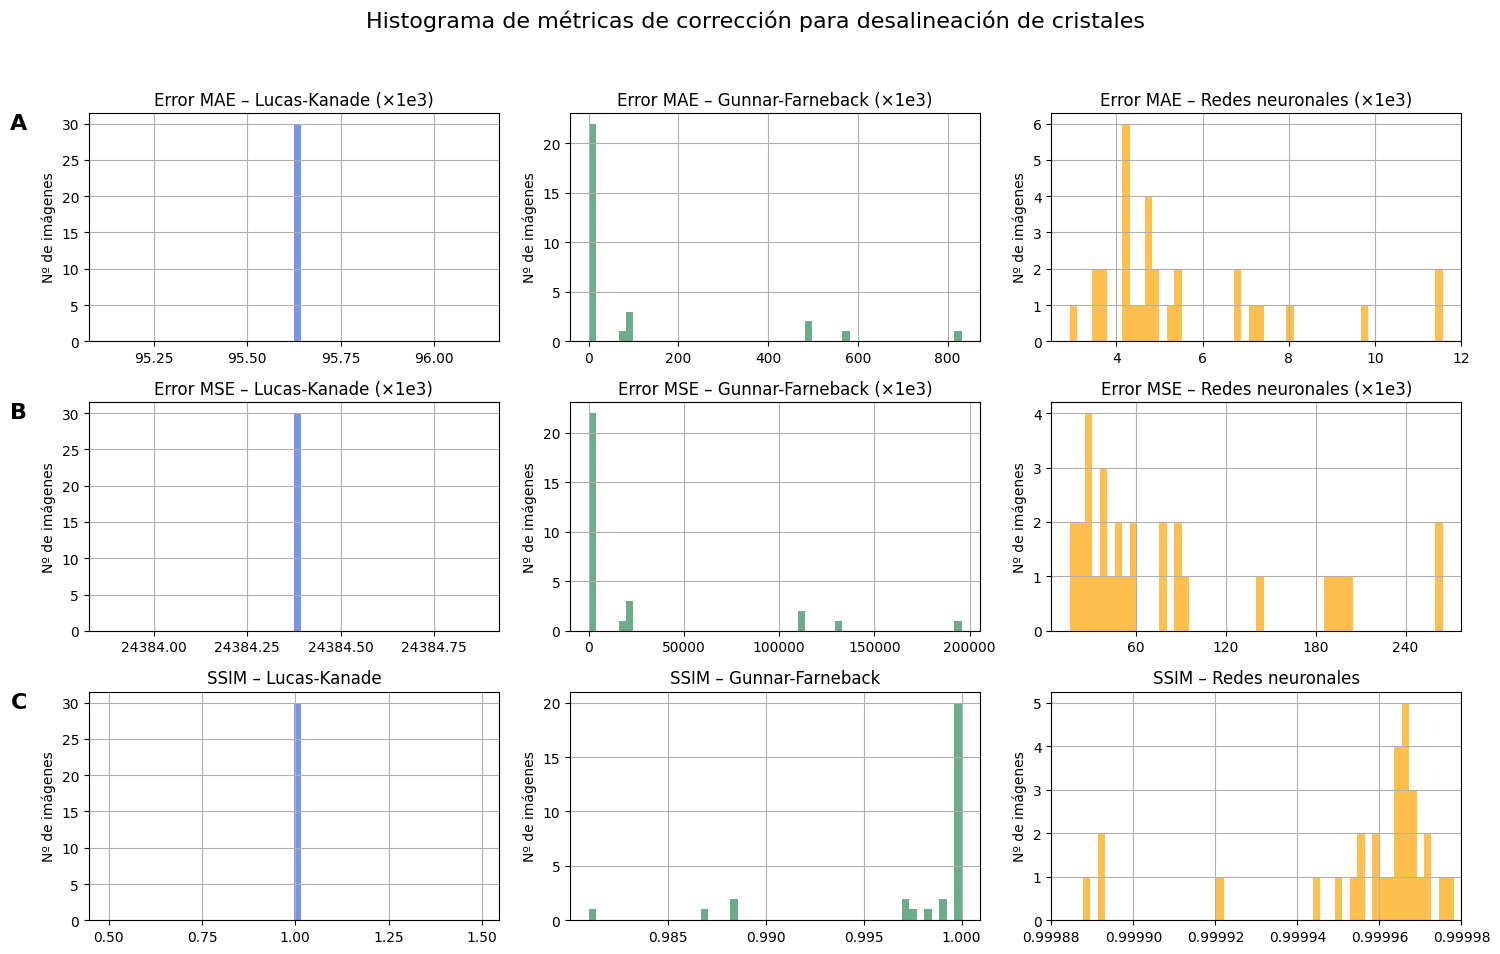

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from matplotlib.ticker import MaxNLocator, ScalarFormatter

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)

# Ruta al archivo CSV
csv_path = Path("data/Cristal_Miss/Pruebas/metricas_correccion.csv")

# Cargamos el DataFrameº
df = pd.read_csv(csv_path)

# Escalamos los errores L1 y L2 en caso necesario
scale_factor = 1e3

# Creamos la figura
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle(f"Histograma de métricas de corrección para desalineación de cristales", fontsize=16)

# Letras de fila
row_labels = ['A', 'B', 'C']

# Histograma L1
axs[0, 0].hist(df["L1_LK"] * scale_factor, bins=50, alpha=0.7, color="royalblue")
axs[0, 0].set_title("Error MAE – Lucas-Kanade (×1e3)")

axs[0, 1].hist(df["L1_GF"] * scale_factor, bins=50, alpha=0.7, color="seagreen")
axs[0, 1].set_title("Error MAE – Gunnar-Farneback (×1e3)")

axs[0, 2].hist(df["L1_NN"] * scale_factor, bins=50, alpha=0.7, color="orange")
axs[0, 2].set_title("Error MAE – Redes neuronales (×1e3)")

# Histograma L2

axs[1, 0].hist(df["L2_LK"] * scale_factor, bins=50, alpha=0.7, color="royalblue")
axs[1, 0].set_title("Error MSE – Lucas-Kanade (×1e3)")
axs[1, 0].xaxis.set_major_formatter(formatter)
axs[1, 0].ticklabel_format(style='plain', axis='x')



axs[1, 1].hist(df["L2_GF"] * scale_factor, bins=50, alpha=0.7, color="seagreen")
axs[1, 1].set_title("Error MSE – Gunnar-Farneback (×1e3)")

axs[1, 2].hist(df["L2_NN"] * scale_factor, bins=50, alpha=0.7, color="orange")
axs[1, 2].set_title("Error MSE – Redes neuronales (×1e3)")

# Histograma SSIM
axs[2, 0].hist(df["SSIM_LK"], bins=50, alpha=0.7, color="royalblue")
axs[2, 0].set_title("SSIM – Lucas-Kanade")

axs[2, 1].hist(df["SSIM_GF"], bins=50, alpha=0.7, color="seagreen")
axs[2, 1].set_title("SSIM – Gunnar-Farneback")


axs[2, 2].hist(df["SSIM_NN"], bins=50, alpha=0.7, color="orange")
axs[2, 2].set_title("SSIM – Redes neuronales")
axs[2, 2].set_xlim(0.99988, 0.99998)
axs[2, 2].xaxis.set_major_formatter(ScalarFormatter())
axs[2, 2].ticklabel_format(style='plain', axis='x')


# Añadimos letras A, B, C al margen izquierdo
for row in range(3):
    axs[row, 0].text(
        -0.15, 1.0, row_labels[row], transform=axs[row, 0].transAxes,
        fontsize=16, fontweight='bold', va='top', ha='right'
    )

# Etiquetas y estilo
for ax in axs.flat:
    ax.set_ylabel("Nº de imágenes")
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
save_path = csv_path.parent / "histograma_errores.png"
plt.savefig(save_path)
print(f"✅ Histograma guardado en: {save_path}")
plt.show()

También hemos tomado los promedios, junto con la desviación y los valores máximos y mínimos obtenidos de cada métrica para cada método.

In [70]:
import pandas as pd
from pathlib import Path

ruta = Path("data/Cristal_Miss/Pruebas")

# Cargamos  el CSV
df = pd.read_csv(ruta / "metricas_correccion.csv")

# Definimos los métodos y las métricas
metodos = ["LK", "GF", "NN"]
metricas = ["L1", "L2", "SSIM"]

# Inicializamos la lista para guardar resultados
resultados = []

# Calculamos las estadísticas
for metodo in metodos:
    for metrica in metricas:
        col = f"{metrica}_{metodo}"
        if col not in df.columns:
            continue
        valores = df[col].dropna()
        if valores.empty:
            continue
        resultados.append({
            "Método": metodo,
            "Métrica": metrica,
            "Media": valores.mean(),
            "Desviación": valores.std(),
            "Mínimo": valores.min(),
            "Máximo": valores.max(),
            "N": len(valores)
        })

# Convertimos a DataFrame y mostramos
resumen = pd.DataFrame(resultados)
print(resumen)

resumen.to_csv(ruta / "resumen_metricas.csv", index=False)


  Método Métrica      Media    Desviación     Mínimo      Máximo   N
0     LK      L1   0.095625  4.234510e-17   0.095625    0.095625  30
1     LK      L2  24.384375  1.084034e-14  24.384375   24.384375  30
2     LK    SSIM   0.996226  6.775215e-16   0.996226    0.996226  30
3     GF      L1   0.091478  2.101312e-01   0.000000    0.831131  30
4     GF      L2  21.006861  4.855551e+01   0.000000  195.790700  30
5     GF    SSIM   0.997772  4.847228e-03   0.980960    1.000000  30
6     NN      L1   0.005519  2.217929e-03   0.002925    0.011575  30
7     NN      L2   0.084454  7.493001e-02   0.016112    0.264887  30
8     NN    SSIM   0.999955  2.409831e-05   0.999888    0.999978  30


## 7.2 Compresión de bordes

Análogo al apartado anterior

✅ Histograma guardado en: data/Compression/Prueba/histograma_errores.png


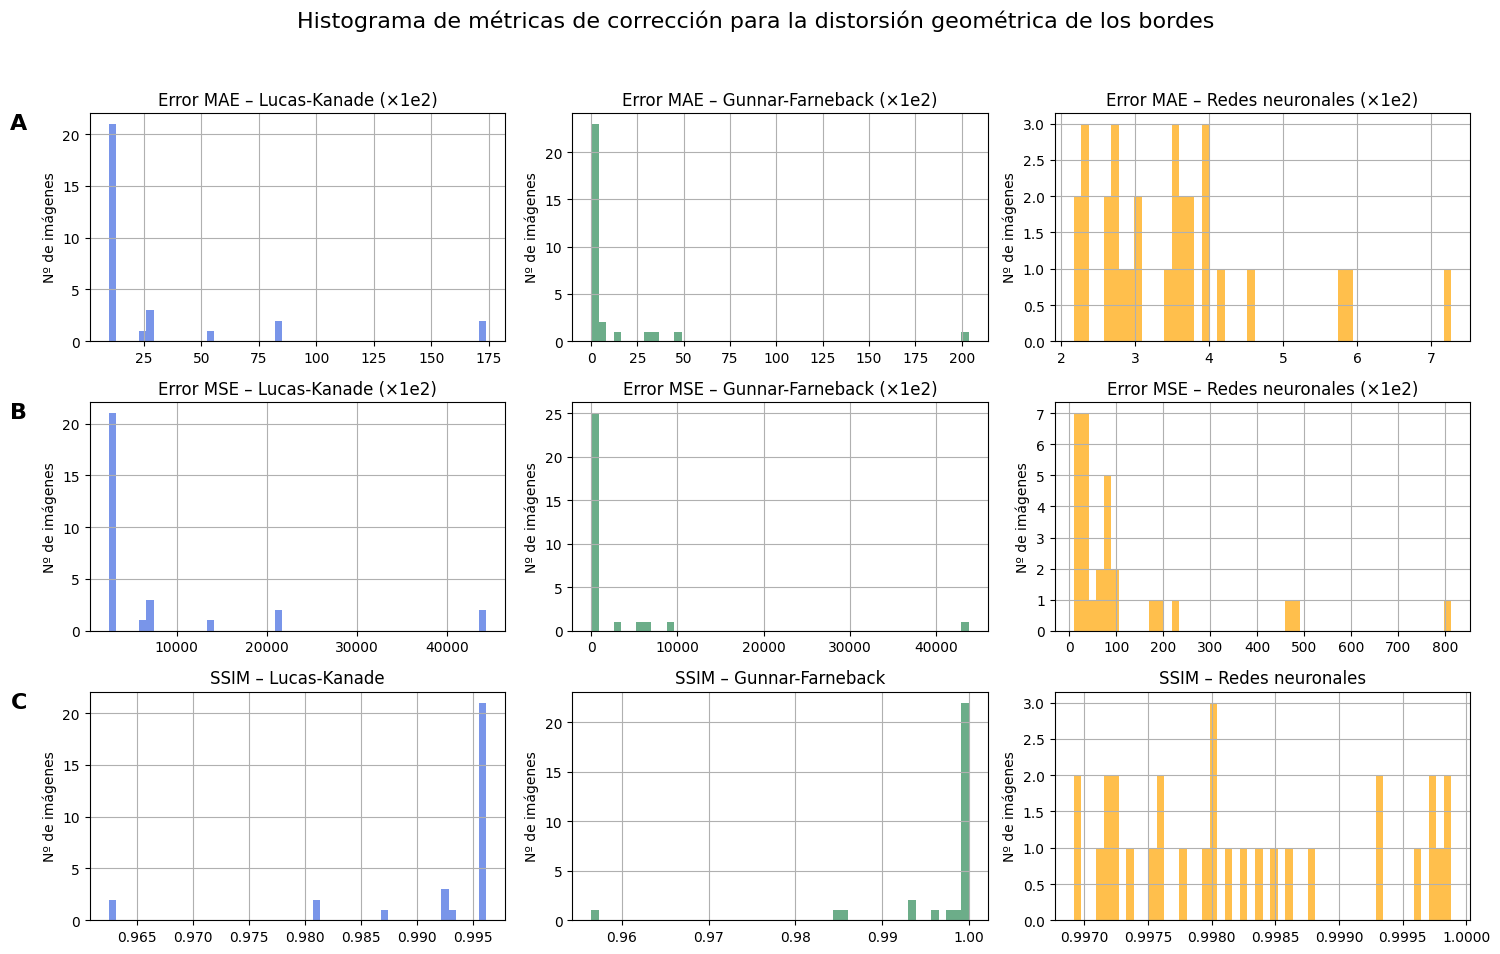

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Ruta al archivo CSV
csv_path = Path("data/Compression/Prueba/metricas_correccion.csv")

# Cargamos el DataFrame
df = pd.read_csv(csv_path)

# -Escalamos los errores L1 y L2 en caso de ser necesario
scale_factor = 1e2

# Creamos la figura
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle(f"Histograma de métricas de corrección para la distorsión geométrica de los bordes", fontsize=16)

# Letras de fila
row_labels = ['A', 'B', 'C']

# Histograma L1
axs[0, 0].hist(df["L1_LK"] * scale_factor, bins=50, alpha=0.7, color="royalblue")
axs[0, 0].set_title("Error MAE – Lucas-Kanade (×1e2)")

axs[0, 1].hist(df["L1_GF"] * scale_factor, bins=50, alpha=0.7, color="seagreen")
axs[0, 1].set_title("Error MAE – Gunnar-Farneback (×1e2)")

axs[0, 2].hist(df["L1_NN"] * scale_factor, bins=50, alpha=0.7, color="orange")
axs[0, 2].set_title("Error MAE – Redes neuronales (×1e2)")

# Histograma L2
axs[1, 0].hist(df["L2_LK"] * scale_factor, bins=50, alpha=0.7, color="royalblue")
axs[1, 0].set_title("Error MSE – Lucas-Kanade (×1e2)")

axs[1, 1].hist(df["L2_GF"] * scale_factor, bins=50, alpha=0.7, color="seagreen")
axs[1, 1].set_title("Error MSE – Gunnar-Farneback (×1e2)")

axs[1, 2].hist(df["L2_NN"] * scale_factor, bins=50, alpha=0.7, color="orange")
axs[1, 2].set_title("Error MSE – Redes neuronales (×1e2)")

# Histograma SSIM
axs[2, 0].hist(df["SSIM_LK"], bins=50, alpha=0.7, color="royalblue")
axs[2, 0].set_title("SSIM – Lucas-Kanade")

axs[2, 1].hist(df["SSIM_GF"], bins=50, alpha=0.7, color="seagreen")
axs[2, 1].set_title("SSIM – Gunnar-Farneback")

axs[2, 2].hist(df["SSIM_NN"], bins=50, alpha=0.7, color="orange")
axs[2, 2].set_title("SSIM – Redes neuronales")

#  Añadimos letras A, B, C al margen izquierdo
for row in range(3):
    axs[row, 0].text(
        -0.15, 1.0, row_labels[row], transform=axs[row, 0].transAxes,
        fontsize=16, fontweight='bold', va='top', ha='right'
    )

#  Etiquetas y estilo
for ax in axs.flat:
    ax.set_ylabel("Nº de imágenes")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
save_path = csv_path.parent / "histograma_errores.png"
plt.savefig(save_path)
print(f"✅ Histograma guardado en: {save_path}")
plt.show()



Para comparar los resultados obtenidos con cada método, se han generado histogramas de las métricas de corrección obtenidas para cada método, en función del número de imágenes de prueba y los valores que se han obtenido para cada una.

In [71]:
import pandas as pd
from pathlib import Path

ruta = Path("data/Compression/Prueba")

# Cargamos el CSV
df = pd.read_csv(ruta / "metricas_correccion.csv")

# Definimos métodos y métricas
metodos = ["LK", "GF", "NN"]
metricas = ["L1", "L2", "SSIM"]

# Inicializamos la  lista para guardar resultados
resultados = []

# Calculamos las estadísticas
for metodo in metodos:
    for metrica in metricas:
        col = f"{metrica}_{metodo}"
        if col not in df.columns:
            continue
        valores = df[col].dropna()
        if valores.empty:
            continue
        resultados.append({
            "Método": metodo,
            "Métrica": metrica,
            "Media": valores.mean(),
            "Desviación": valores.std(),
            "Mínimo": valores.min(),
            "Máximo": valores.max(),
            "N": len(valores)
        })

# Convertimos a DataFrame y mostramos
resumen = pd.DataFrame(resultados)
print(resumen)


resumen.to_csv(ruta / "resumen_metricas.csv", index=False)

  Método Métrica      Media  Desviación     Mínimo      Máximo   N
0     LK      L1   0.292559    0.441335   0.095625    1.740375  30
1     LK      L2  74.602639  112.540482  24.384375  443.795600  30
2     LK    SSIM   0.992184    0.009053   0.962491    0.996226  30
3     GF      L1   0.115824    0.381190   0.000000    2.039294  30
4     GF      L2  23.274739   81.461659   0.000000  438.062840  30
5     GF    SSIM   0.996852    0.008620   0.956454    1.000000  30
6     NN      L1   0.035064    0.011740   0.021669    0.072762  30
7     NN      L2   1.168857    1.763287   0.091331    8.138887  30
8     NN    SSIM   0.998258    0.000994   0.996916    0.999884  30


## 7.3 Aberración en los bordes

Análogo al apartado anterior

✅ Histograma guardado en: data/Border_Noise/Prueba/histograma_errores.png


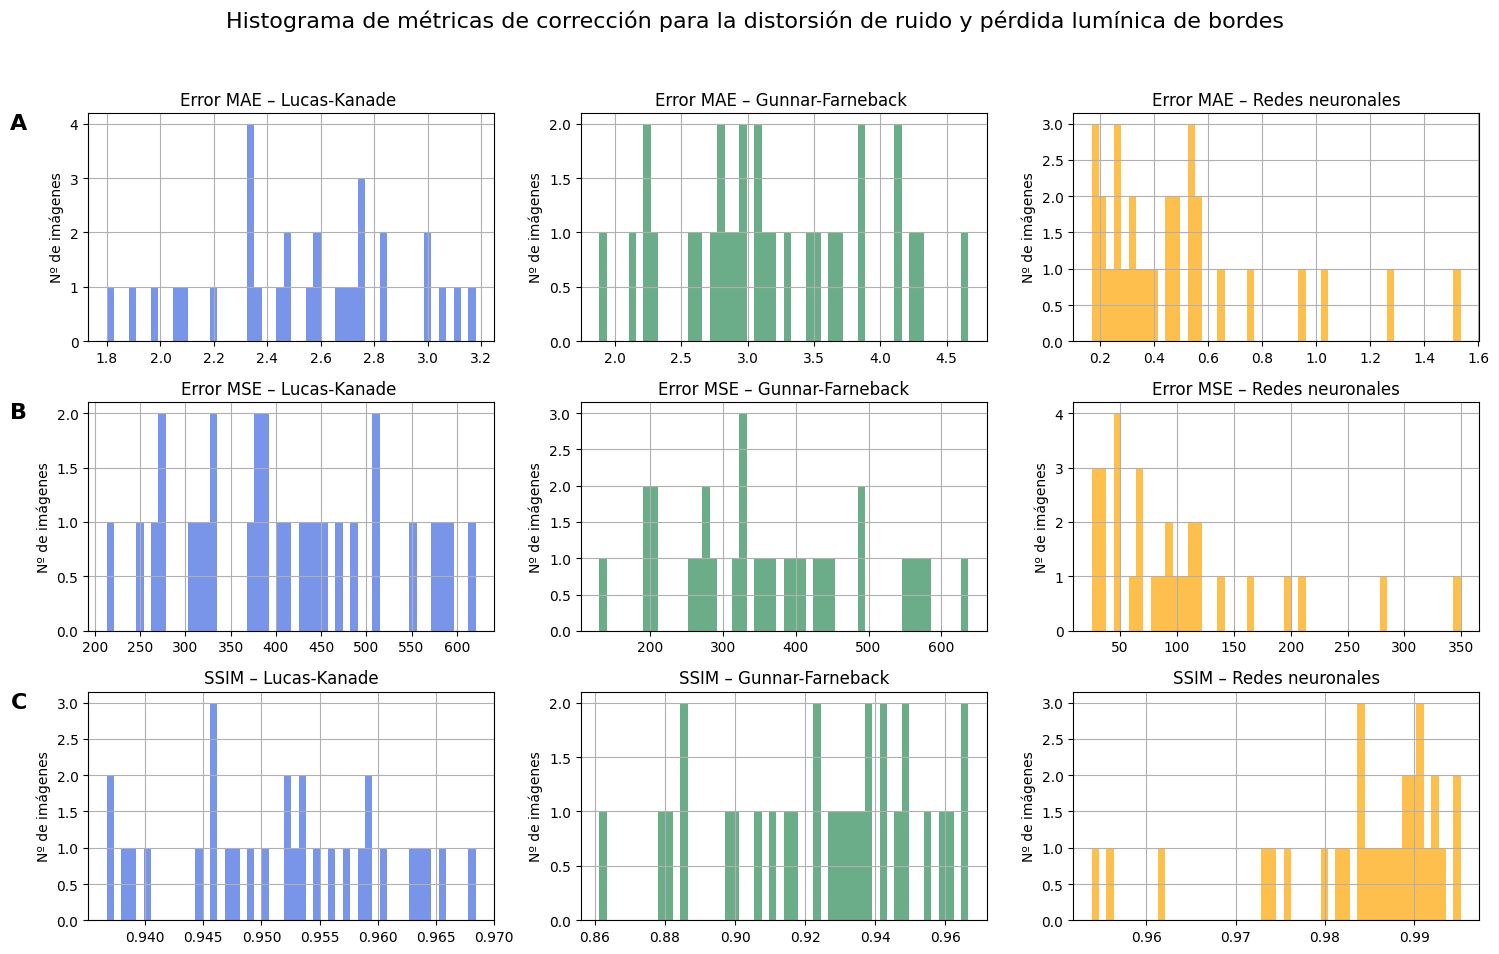

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

#  Ruta al archivo CSV
csv_path = Path("data/Border_Noise/Prueba/metricas_correccion.csv")

#  Cargamos DataFrame
df = pd.read_csv(csv_path)

#  Escalamos los errores L1 y L2 en caso necesario
scale_factor = 1

#  Creamos la figura
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle(f"Histograma de métricas de corrección para la distorsión de ruido y pérdida lumínica de bordes", fontsize=16)

#  Letras de fila
row_labels = ['A', 'B', 'C']

#  Histograma L1
axs[0, 0].hist(df["L1_LK"] * scale_factor, bins=50, alpha=0.7, color="royalblue")
axs[0, 0].set_title("Error MAE – Lucas-Kanade ")

axs[0, 1].hist(df["L1_GF"] * scale_factor, bins=50, alpha=0.7, color="seagreen")
axs[0, 1].set_title("Error MAE – Gunnar-Farneback ")

axs[0, 2].hist(df["L1_NN"] * scale_factor, bins=50, alpha=0.7, color="orange")
axs[0, 2].set_title("Error MAE – Redes neuronales")

#  Histograma L2
axs[1, 0].hist(df["L2_LK"] * scale_factor, bins=50, alpha=0.7, color="royalblue")
axs[1, 0].set_title("Error MSE – Lucas-Kanade ")

axs[1, 1].hist(df["L2_GF"] * scale_factor, bins=50, alpha=0.7, color="seagreen")
axs[1, 1].set_title("Error MSE – Gunnar-Farneback")

axs[1, 2].hist(df["L2_NN"] * scale_factor, bins=50, alpha=0.7, color="orange")
axs[1, 2].set_title("Error MSE – Redes neuronales")

#  Histograma SSIM
axs[2, 0].hist(df["SSIM_LK"], bins=50, alpha=0.7, color="royalblue")
axs[2, 0].set_title("SSIM – Lucas-Kanade")

axs[2, 1].hist(df["SSIM_GF"], bins=50, alpha=0.7, color="seagreen")
axs[2, 1].set_title("SSIM – Gunnar-Farneback")

axs[2, 2].hist(df["SSIM_NN"], bins=50, alpha=0.7, color="orange")
axs[2, 2].set_title("SSIM – Redes neuronales")

#  Añadimos letras A, B, C al margen izquierdo
for row in range(3):
    axs[row, 0].text(
        -0.15, 1.0, row_labels[row], transform=axs[row, 0].transAxes,
        fontsize=16, fontweight='bold', va='top', ha='right'
    )

#  Etiquetas y estilo
for ax in axs.flat:
    ax.set_ylabel("Nº de imágenes")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
save_path = csv_path.parent / "histograma_errores.png"
plt.savefig(save_path)
print(f"✅ Histograma guardado en: {save_path}")
plt.show()





Para comparar los resultados obtenidos con cada método, se han generado histogramas de las métricas de corrección obtenidas para cada método, en función del número de imágenes de prueba y los valores que se han obtenido para cada una.

In [74]:
import pandas as pd
from pathlib import Path


ruta = Path("data/Border_Noise/Prueba")

# Cargamos el CSV
df = pd.read_csv(ruta / "metricas_correccion.csv")

# Definimos métodos y métricas
metodos = ["LK", "GF", "NN"]
metricas = ["L1", "L2", "SSIM"]

# Inicializamos la  lista para guardar resultados
resultados = []

# Calculamos las estadísticas
for metodo in metodos:
    for metrica in metricas:
        col = f"{metrica}_{metodo}"
        if col not in df.columns:
            continue
        valores = df[col].dropna()
        if valores.empty:
            continue
        resultados.append({
            "Método": metodo,
            "Métrica": metrica,
            "Media": valores.mean(),
            "Desviación": valores.std(),
            "Mínimo": valores.min(),
            "Máximo": valores.max(),
            "N": len(valores)
        })

# Convertimos a DataFrame y mostramos
resumen = pd.DataFrame(resultados)
print(resumen)

resumen.to_csv(ruta / "resumen_metricas.csv", index=False)

  Método Métrica       Media  Desviación      Mínimo      Máximo   N
0     LK      L1    2.541716    0.363819    1.798675    3.179000  30
1     LK      L2  409.315337  111.176121  212.958600  620.950560  30
2     LK    SSIM    0.952056    0.008941    0.936690    0.968419  30
3     GF      L1    3.179679    0.706999    1.882406    4.662150  30
4     GF      L2  369.329909  131.218490  129.401050  637.172360  30
5     GF    SSIM    0.925405    0.028157    0.861187    0.966534  30
6     NN      L1    0.495516    0.328649    0.168325    1.534694  30
7     NN      L2  100.102878   76.282325   25.013063  349.511630  30
8     NN    SSIM    0.983756    0.010674    0.953883    0.995192  30


## 7.4 Imágenes satelitales

Aunque no estemos comparando con ningún método, la siguiente celda muestra los valores promedio de las métricas obtenidas para cada una de la regiones de la imagen del VIIRS

In [75]:
# Directorio base
base_dir = Path("data/sat")

# Procesamos todas las regiones
for region_dir in sorted(base_dir.glob("region*")):
    region_name = region_dir.name  # ej. "region5"
    original_path = region_dir / "original" / f"{region_name}_original.png"
    distorted_dir = region_dir / "distorted"

    # Cargamos la imagen original
    img_ref = cv2.imread(str(original_path), cv2.IMREAD_GRAYSCALE)

    # Heneramos las listas de las métricas
    ssim_list = []
    l1_list = []
    l2_list = []

    for distorted_path in sorted(distorted_dir.glob(f"{region_name}_distorted_*.png")):
        img_dist = cv2.imread(str(distorted_path), cv2.IMREAD_GRAYSCALE)

        # Comparamos la imagen distorsionada con la original
        l1_val, ssim_val, l2_val = compute_l1_ssim(img_ref, img_dist)
        ssim_list.append(ssim_val)
        l1_list.append(l1_val)
        l2_list.append(l2_val)


    # Promedio por región
    if ssim_list:
        avg_ssim = np.mean(ssim_list)
        avg_l1 = np.mean(l1_list)
        avg_l2 = np.mean(l2_list)
        print(f"{region_name}: SSIM promedio = {avg_ssim:.4f}, L1 promedio = {avg_l1:.4f}, L2 promedio = {avg_l2:.4f}")
    else:
        print(f"{region_name}: No se encontraron imágenes distorsionadas.")

region1: SSIM promedio = 0.8698, L1 promedio = 3.1207, L2 promedio = 117.0932
region10: SSIM promedio = 0.9276, L1 promedio = 2.0433, L2 promedio = 106.7825
region2: SSIM promedio = 0.8874, L1 promedio = 2.5151, L2 promedio = 93.0316
region3: SSIM promedio = 0.8971, L1 promedio = 2.5559, L2 promedio = 120.5527
region4: SSIM promedio = 0.8860, L1 promedio = 2.9548, L2 promedio = 155.1718
region5: SSIM promedio = 0.9187, L1 promedio = 2.0067, L2 promedio = 93.6858
region6: SSIM promedio = 0.9010, L1 promedio = 2.4093, L2 promedio = 100.9167
region7: SSIM promedio = 0.9230, L1 promedio = 1.9093, L2 promedio = 88.0903
region8: SSIM promedio = 0.9256, L1 promedio = 1.9459, L2 promedio = 95.1641
region9: SSIM promedio = 0.9229, L1 promedio = 1.9986, L2 promedio = 102.6121
